In [1]:
import os

import pandas as pd
import numpy as np

from scipy import stats
from tqdm import tqdm
import optuna

from sklearn.model_selection import GridSearchCV
from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization import plot_optimization_history

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, \
    mean_squared_log_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from get_metrics import get_metrics_regression
from sklearn.neighbors import KNeighborsRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import catboost as cb

from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings("ignore")

RAND = 10
N_FOLDS = 5

# Чтение данных

In [2]:
cian = pd.read_csv('data/cian.csv').drop_duplicates()

In [3]:
col_cats = cian.select_dtypes('object').columns
cian[col_cats] = cian[col_cats].astype('category')

In [4]:
cian[:5]

,author,link,floor,floors_count,rooms_count,total_meters,price,district,street,underground,...,entertainment_infrastructure_rating,square,population,housing_fund_area,line_count,author_count,floor_position,author_more,house_category,population_density
0,Sminex-Интеко,https://www.cian.ru/sale/flat/281914898/,3,5,2,67.07,149930000,Тверской,None,Площадь Революции,...,100,7.27,77864,1253.3,1,193,0,1,2,10710.32
1,MR Group,https://www.cian.ru/sale/flat/285682464/,3,10,2,62.70,34485000,Беговой,Северный ао,Белорусская,...,97,5.56,42781,791.1,4,307,0,1,3,7694.42
2,GloraX,https://www.cian.ru/sale/flat/277738124/,5,21,2,77.85,34069999,Беговой,1-я Ямского Поля,Белорусская,...,97,5.56,42781,791.1,4,40,0,1,5,7694.42
3,ANT Development,https://www.cian.ru/sale/flat/283856161/,27,32,2,50.90,40703799,Дорогомилово,Поклонная,Парк Победы,...,96,7.95,76093,1906.2,4,86,0,1,5,9571.45
4,Sminex-Интеко,https://www.cian.ru/sale/flat/281051002/,6,14,2,85.60,187560000,Якиманка,None,Полянка,...,98,4.80,27672,788.7,1,193,0,1,4,5765.00


In [5]:
cian.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12159 entries, 0 to 12158
Data columns (total 34 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   author                               12159 non-null  category
 1   link                                 12159 non-null  category
 2   floor                                12159 non-null  int64   
 3   floors_count                         12159 non-null  int64   
 4   rooms_count                          12159 non-null  int64   
 5   total_meters                         12159 non-null  float64 
 6   price                                12159 non-null  int64   
 7   district                             12159 non-null  category
 8   street                               12159 non-null  category
 9   underground                          12159 non-null  category
 10  residential_complex                  12159 non-null  category
 11  author_type    

In [6]:
def remove_outliers(df: pd.DataFrame,
                    column: pd.Series,
                    threshold: float = 1.5) -> pd.DataFrame:
    """
    Удаление выбросов
    """
    data = df[column].values
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    upper_bound = q3 + threshold * iqr

    filtered_df = df[df[column] <= upper_bound]
    return filtered_df

Для улучшения точности медели подберём гиперпараметры для моделей CatBoost и LightGBM, а так же построим стекинг

In [7]:
cian = remove_outliers(cian, 'price')

In [8]:
cian.drop(['link', 'price_per_m2'], axis=1, inplace=True)

In [9]:
def check_overfitting_df(model, X_train: pd.DataFrame, y_train: pd.DataFrame,
                         X_test: pd.DataFrame, y_test: pd.DataFrame,
                         metric_fun, name: str) -> pd.DataFrame:
    """
    Проверка на overfitting и добавление в таблицу
    """
    df_check_overfitting = pd.DataFrame()

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    value_train = metric_fun(y_train, y_pred_train)
    value_test = metric_fun(y_test, y_pred_test)

    df_check_overfitting['model'] = [name]

    df_check_overfitting['metric'] = [metric_fun.__name__]
    df_check_overfitting['value_train'] = [value_train]
    df_check_overfitting['value_test'] = [value_test]
    df_check_overfitting['overfitting'] = [
        abs(value_train - value_test) / value_test * 100
    ]

    return df_check_overfitting

In [10]:
X = cian.drop(columns=['price'],
                  axis=1)
y = cian['price'].values

In [11]:
X_train_bin, X_test_bin, y_train, y_test = train_test_split(
    pd.get_dummies(X),
    y,
    test_size=0.2,
    random_state=RAND)


# без бинаризации
X[X.select_dtypes('object').columns] = X[X.select_dtypes('object').columns].astype('category')

X_train = X.loc[X_train_bin.index]
X_test = X.loc[X_test_bin.index]

cat_features = X.select_dtypes('category').columns.tolist()

In [12]:
X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.16,
                                                    shuffle=True,
                                                    random_state=RAND)

eval_set = [(X_val, y_val)]

# Tuning CatBoost

In [13]:
grid = {
    "n_estimators": [700],
    #"learning_rate": np.linspace(0.001, 0.9),
    #0.2945510204081633 700
    #0.056040816326530615 1000
    "learning_rate" : [0.2945510204081633],
    "max_depth": list(range(3, 12)),
    "l2_leaf_reg": np.logspace(-5, 3, 7),
    'border_count': [128, 254],
    #'grow_policy': ["Depthwise", "Lossguide"],
    #"colsample_bylevel": np.arange(0.5, 1.0),
    #'subsample': np.linspace(0.001, 0.99),
    #'od_wait': list(range(500, 2000)),
    #'leaf_estimation_method': ["Newton", "Gradient"],
    #'bagging_temperature': [0.0, 1.0, 10.0],
    #'max_leaves': [31, 63, 127],
    #'random_strength': list(range(10, 50)),
    #'min_data_in_leaf': [1, 2, 4],
    #'od_wait': list(range(500, 2000)),
    #'leaf_estimation_iterations': list(range(1, 15)),
    "random_state": [RAND]
}

ctb = CatBoostRegressor(eval_metric="MAE",
                        cat_features=cat_features)
grid_search_result = ctb.randomized_search(grid,
                                             X=X_train,
                                             y=y_train,
                                             plot=False)

0:	learn: 23235948.4806656	test: 23422172.8367331	best: 23422172.8367331 (0)	total: 186ms	remaining: 2m 10s
1:	learn: 16892141.9968291	test: 17117802.8404075	best: 17117802.8404075 (1)	total: 208ms	remaining: 1m 12s
2:	learn: 13282022.6617376	test: 13427441.3005000	best: 13427441.3005000 (2)	total: 226ms	remaining: 52.5s
3:	learn: 11166727.7820009	test: 11317828.6450528	best: 11317828.6450528 (3)	total: 247ms	remaining: 43s
4:	learn: 9982931.6358481	test: 10125411.6770748	best: 10125411.6770748 (4)	total: 269ms	remaining: 37.4s
5:	learn: 9114632.8784399	test: 9255238.1583155	best: 9255238.1583155 (5)	total: 288ms	remaining: 33.3s
6:	learn: 8463978.9283197	test: 8583104.6322741	best: 8583104.6322741 (6)	total: 306ms	remaining: 30.3s
7:	learn: 8121271.7968719	test: 8223863.0811054	best: 8223863.0811054 (7)	total: 323ms	remaining: 27.9s
8:	learn: 7943763.5445343	test: 7997494.4942778	best: 7997494.4942778 (8)	total: 339ms	remaining: 26s
9:	learn: 7780756.4747124	test: 7819698.6127596	best

79:	learn: 5742253.6751882	test: 6131719.0676394	best: 6130861.7554591 (78)	total: 1.62s	remaining: 12.5s
80:	learn: 5736879.9603678	test: 6131753.3217378	best: 6130861.7554591 (78)	total: 1.64s	remaining: 12.5s
81:	learn: 5727307.2208660	test: 6129691.9349167	best: 6129691.9349167 (81)	total: 1.65s	remaining: 12.5s
82:	learn: 5712061.0682863	test: 6113573.0458604	best: 6113573.0458604 (82)	total: 1.67s	remaining: 12.4s
83:	learn: 5692414.1595173	test: 6117633.0916097	best: 6113573.0458604 (82)	total: 1.69s	remaining: 12.4s
84:	learn: 5688125.4787837	test: 6111922.7459765	best: 6111922.7459765 (84)	total: 1.71s	remaining: 12.4s
85:	learn: 5684809.6252349	test: 6107478.5930647	best: 6107478.5930647 (85)	total: 1.73s	remaining: 12.3s
86:	learn: 5674473.7087500	test: 6107276.4959686	best: 6107276.4959686 (86)	total: 1.74s	remaining: 12.3s
87:	learn: 5664953.9428173	test: 6107705.7462206	best: 6107276.4959686 (86)	total: 1.76s	remaining: 12.3s
88:	learn: 5638333.9087757	test: 6092673.08612

160:	learn: 5058624.9555256	test: 5804495.6599277	best: 5797053.4479229 (156)	total: 3.03s	remaining: 10.1s
161:	learn: 5056650.8030072	test: 5804455.6613202	best: 5797053.4479229 (156)	total: 3.05s	remaining: 10.1s
162:	learn: 5047983.9579782	test: 5792613.8294731	best: 5792613.8294731 (162)	total: 3.06s	remaining: 10.1s
163:	learn: 5044774.0284156	test: 5788170.7224770	best: 5788170.7224770 (163)	total: 3.08s	remaining: 10.1s
164:	learn: 5036820.8916667	test: 5777827.2059318	best: 5777827.2059318 (164)	total: 3.1s	remaining: 10s
165:	learn: 5027233.9831027	test: 5774204.0863367	best: 5774204.0863367 (165)	total: 3.12s	remaining: 10s
166:	learn: 5024557.9091124	test: 5772588.4431233	best: 5772588.4431233 (166)	total: 3.13s	remaining: 10s
167:	learn: 5016792.2624388	test: 5767197.4582221	best: 5767197.4582221 (167)	total: 3.15s	remaining: 9.98s
168:	learn: 5003793.1618128	test: 5759172.5828474	best: 5759172.5828474 (168)	total: 3.17s	remaining: 9.95s
169:	learn: 4999139.9435027	test: 5

243:	learn: 4636201.1623156	test: 5650405.0025043	best: 5647164.1515317 (234)	total: 4.46s	remaining: 8.33s
244:	learn: 4633794.0644483	test: 5652887.6649212	best: 5647164.1515317 (234)	total: 4.47s	remaining: 8.31s
245:	learn: 4633078.9174308	test: 5652896.1413246	best: 5647164.1515317 (234)	total: 4.49s	remaining: 8.29s
246:	learn: 4628757.7779858	test: 5649396.5954247	best: 5647164.1515317 (234)	total: 4.51s	remaining: 8.27s
247:	learn: 4623057.3692547	test: 5653592.9707536	best: 5647164.1515317 (234)	total: 4.53s	remaining: 8.25s
248:	learn: 4618380.2019587	test: 5652876.3230267	best: 5647164.1515317 (234)	total: 4.54s	remaining: 8.23s
249:	learn: 4617060.1060746	test: 5652376.1827355	best: 5647164.1515317 (234)	total: 4.56s	remaining: 8.21s
250:	learn: 4612899.8356188	test: 5654732.0326730	best: 5647164.1515317 (234)	total: 4.58s	remaining: 8.19s
251:	learn: 4605518.0097542	test: 5652566.6849977	best: 5647164.1515317 (234)	total: 4.59s	remaining: 8.17s
252:	learn: 4601784.0936515	

326:	learn: 4326273.2367359	test: 5597521.6994727	best: 5590536.1624314 (317)	total: 5.92s	remaining: 6.75s
327:	learn: 4323916.5319252	test: 5596936.5161275	best: 5590536.1624314 (317)	total: 5.93s	remaining: 6.73s
328:	learn: 4315616.3483819	test: 5580665.3014879	best: 5580665.3014879 (328)	total: 5.95s	remaining: 6.71s
329:	learn: 4313565.4557554	test: 5578468.7596976	best: 5578468.7596976 (329)	total: 5.97s	remaining: 6.69s
330:	learn: 4307663.5663020	test: 5580506.4516445	best: 5578468.7596976 (329)	total: 5.99s	remaining: 6.67s
331:	learn: 4306053.9880827	test: 5580903.8568464	best: 5578468.7596976 (329)	total: 6s	remaining: 6.65s
332:	learn: 4303667.9034472	test: 5581099.5695740	best: 5578468.7596976 (329)	total: 6.02s	remaining: 6.63s
333:	learn: 4302396.5979616	test: 5580979.1459827	best: 5578468.7596976 (329)	total: 6.04s	remaining: 6.62s
334:	learn: 4302129.9883098	test: 5577082.0734950	best: 5577082.0734950 (334)	total: 6.05s	remaining: 6.6s
335:	learn: 4297410.5754369	test

410:	learn: 4067654.4182869	test: 5522379.1723182	best: 5513155.5994939 (395)	total: 7.38s	remaining: 5.19s
411:	learn: 4066626.2542525	test: 5513470.0508922	best: 5513155.5994939 (395)	total: 7.39s	remaining: 5.17s
412:	learn: 4059151.6289065	test: 5516017.7501375	best: 5513155.5994939 (395)	total: 7.41s	remaining: 5.15s
413:	learn: 4057421.1362067	test: 5514936.7903251	best: 5513155.5994939 (395)	total: 7.43s	remaining: 5.13s
414:	learn: 4053304.2328522	test: 5515308.6276465	best: 5513155.5994939 (395)	total: 7.45s	remaining: 5.11s
415:	learn: 4051454.9699576	test: 5518507.1828516	best: 5513155.5994939 (395)	total: 7.46s	remaining: 5.1s
416:	learn: 4050405.3303812	test: 5518441.6616438	best: 5513155.5994939 (395)	total: 7.48s	remaining: 5.08s
417:	learn: 4045972.3919708	test: 5518244.5553873	best: 5513155.5994939 (395)	total: 7.5s	remaining: 5.06s
418:	learn: 4041016.5309207	test: 5515486.5290409	best: 5513155.5994939 (395)	total: 7.52s	remaining: 5.04s
419:	learn: 4035997.2705402	te

487:	learn: 3861757.3303074	test: 5472611.2487547	best: 5471410.4182981 (486)	total: 8.79s	remaining: 3.82s
488:	learn: 3859596.6028927	test: 5475961.7598875	best: 5471410.4182981 (486)	total: 8.8s	remaining: 3.8s
489:	learn: 3854017.5943654	test: 5478413.6921780	best: 5471410.4182981 (486)	total: 8.82s	remaining: 3.78s
490:	learn: 3852079.9151408	test: 5480055.7522295	best: 5471410.4182981 (486)	total: 8.84s	remaining: 3.76s
491:	learn: 3850286.3676325	test: 5480421.0618788	best: 5471410.4182981 (486)	total: 8.86s	remaining: 3.74s
492:	learn: 3848055.4429009	test: 5476463.6774591	best: 5471410.4182981 (486)	total: 8.87s	remaining: 3.73s
493:	learn: 3845533.4983645	test: 5473373.8302343	best: 5471410.4182981 (486)	total: 8.89s	remaining: 3.71s
494:	learn: 3843067.6318974	test: 5470386.6273763	best: 5470386.6273763 (494)	total: 8.91s	remaining: 3.69s
495:	learn: 3841948.6234241	test: 5471196.3810455	best: 5470386.6273763 (494)	total: 8.92s	remaining: 3.67s
496:	learn: 3838757.8107486	te

570:	learn: 3668631.8495263	test: 5468591.9988010	best: 5462694.8841155 (538)	total: 10.2s	remaining: 2.31s
571:	learn: 3665555.0552868	test: 5464112.0955794	best: 5462694.8841155 (538)	total: 10.3s	remaining: 2.29s
572:	learn: 3663199.1565751	test: 5469986.5036387	best: 5462694.8841155 (538)	total: 10.3s	remaining: 2.28s
573:	learn: 3662917.3677584	test: 5469808.2746364	best: 5462694.8841155 (538)	total: 10.3s	remaining: 2.26s
574:	learn: 3661613.6885918	test: 5469041.0470684	best: 5462694.8841155 (538)	total: 10.3s	remaining: 2.24s
575:	learn: 3660548.0337046	test: 5470173.4147680	best: 5462694.8841155 (538)	total: 10.3s	remaining: 2.22s
576:	learn: 3657690.3853016	test: 5472588.0461691	best: 5462694.8841155 (538)	total: 10.3s	remaining: 2.2s
577:	learn: 3655674.4086449	test: 5471049.6993804	best: 5462694.8841155 (538)	total: 10.4s	remaining: 2.19s
578:	learn: 3652770.2512621	test: 5474396.5802680	best: 5462694.8841155 (538)	total: 10.4s	remaining: 2.17s
579:	learn: 3650989.7493088	t

654:	learn: 3516645.6837059	test: 5468366.6424640	best: 5462694.8841155 (538)	total: 11.7s	remaining: 804ms
655:	learn: 3514538.3452756	test: 5468713.9136050	best: 5462694.8841155 (538)	total: 11.7s	remaining: 786ms
656:	learn: 3511777.5747223	test: 5470842.1930544	best: 5462694.8841155 (538)	total: 11.7s	remaining: 768ms
657:	learn: 3506969.5250294	test: 5465014.1820831	best: 5462694.8841155 (538)	total: 11.7s	remaining: 750ms
658:	learn: 3504579.2621448	test: 5465002.5060806	best: 5462694.8841155 (538)	total: 11.8s	remaining: 732ms
659:	learn: 3504462.7256080	test: 5464732.3621940	best: 5462694.8841155 (538)	total: 11.8s	remaining: 714ms
660:	learn: 3501978.2346241	test: 5464375.5356436	best: 5462694.8841155 (538)	total: 11.8s	remaining: 696ms
661:	learn: 3501114.7963973	test: 5461877.3965257	best: 5461877.3965257 (661)	total: 11.8s	remaining: 678ms
662:	learn: 3495568.0420889	test: 5468112.3845768	best: 5461877.3965257 (661)	total: 11.8s	remaining: 660ms
663:	learn: 3494134.6659477	

32:	learn: 4045544.5633951	test: 5997708.6631785	best: 5997708.6631785 (32)	total: 1.76s	remaining: 35.5s
33:	learn: 3999833.9596887	test: 5976886.2822654	best: 5976886.2822654 (33)	total: 1.81s	remaining: 35.5s
34:	learn: 3968056.6556731	test: 5971182.9087486	best: 5971182.9087486 (34)	total: 1.86s	remaining: 35.4s
35:	learn: 3898456.5478555	test: 5947782.9477684	best: 5947782.9477684 (35)	total: 1.91s	remaining: 35.3s
36:	learn: 3833201.7931484	test: 5922163.6462536	best: 5922163.6462536 (36)	total: 1.97s	remaining: 35.2s
37:	learn: 3767975.2895899	test: 5894178.1177274	best: 5894178.1177274 (37)	total: 2.02s	remaining: 35.2s
38:	learn: 3715269.6207751	test: 5882845.0330175	best: 5882845.0330175 (38)	total: 2.08s	remaining: 35.3s
39:	learn: 3676179.7703640	test: 5886628.5696877	best: 5882845.0330175 (38)	total: 2.14s	remaining: 35.3s
40:	learn: 3626836.5100900	test: 5848424.9729530	best: 5848424.9729530 (40)	total: 2.19s	remaining: 35.2s
41:	learn: 3550679.6959472	test: 5852567.31515

110:	learn: 1958930.6870827	test: 5576900.5323554	best: 5576900.5323554 (110)	total: 7.93s	remaining: 42.1s
111:	learn: 1950494.2459772	test: 5574582.3420720	best: 5574582.3420720 (111)	total: 8.07s	remaining: 42.4s
112:	learn: 1932433.0028506	test: 5563693.0245589	best: 5563693.0245589 (112)	total: 8.21s	remaining: 42.7s
113:	learn: 1913708.7611028	test: 5564105.5799475	best: 5563693.0245589 (112)	total: 8.36s	remaining: 43s
114:	learn: 1900248.7842133	test: 5560480.9221003	best: 5560480.9221003 (114)	total: 8.49s	remaining: 43.2s
115:	learn: 1880823.1691178	test: 5568963.3852369	best: 5560480.9221003 (114)	total: 8.63s	remaining: 43.4s
116:	learn: 1876486.7117067	test: 5571678.5581652	best: 5560480.9221003 (114)	total: 8.76s	remaining: 43.6s
117:	learn: 1868674.9322689	test: 5571603.1807839	best: 5560480.9221003 (114)	total: 8.91s	remaining: 44s
118:	learn: 1843975.1080469	test: 5574222.3717143	best: 5560480.9221003 (114)	total: 9.07s	remaining: 44.3s
119:	learn: 1822354.5400726	test

188:	learn: 1208580.1577811	test: 5480367.8490453	best: 5480367.8490453 (188)	total: 14s	remaining: 37.8s
189:	learn: 1198067.0807754	test: 5480264.9252570	best: 5480264.9252570 (189)	total: 14.1s	remaining: 37.7s
190:	learn: 1189983.8486888	test: 5484340.6805388	best: 5480264.9252570 (189)	total: 14.1s	remaining: 37.6s
191:	learn: 1186929.7723471	test: 5483228.3458660	best: 5480264.9252570 (189)	total: 14.2s	remaining: 37.5s
192:	learn: 1174142.3356314	test: 5483244.4377750	best: 5480264.9252570 (189)	total: 14.2s	remaining: 37.4s
193:	learn: 1170757.4844275	test: 5481728.5094390	best: 5480264.9252570 (189)	total: 14.3s	remaining: 37.2s
194:	learn: 1166149.3263283	test: 5479325.5546206	best: 5479325.5546206 (194)	total: 14.3s	remaining: 37.1s
195:	learn: 1157463.1801504	test: 5478308.2643249	best: 5478308.2643249 (195)	total: 14.4s	remaining: 37s
196:	learn: 1150382.2371129	test: 5477141.3683000	best: 5477141.3683000 (196)	total: 14.4s	remaining: 36.9s
197:	learn: 1144786.1288941	test

266:	learn: 778144.9822776	test: 5461987.6638371	best: 5461987.6638371 (266)	total: 19.3s	remaining: 31.2s
267:	learn: 773861.0399939	test: 5462464.4172603	best: 5461987.6638371 (266)	total: 19.4s	remaining: 31.3s
268:	learn: 771297.9898290	test: 5462890.8477595	best: 5461987.6638371 (266)	total: 19.5s	remaining: 31.2s
269:	learn: 765687.1270947	test: 5461631.2511716	best: 5461631.2511716 (269)	total: 19.5s	remaining: 31.1s
270:	learn: 763782.8725614	test: 5461340.0906586	best: 5461340.0906586 (270)	total: 19.6s	remaining: 31s
271:	learn: 760418.5564097	test: 5462681.2355327	best: 5461340.0906586 (270)	total: 19.6s	remaining: 30.9s
272:	learn: 758394.4797778	test: 5462718.2855746	best: 5461340.0906586 (270)	total: 19.7s	remaining: 30.8s
273:	learn: 755638.4035924	test: 5462882.9829812	best: 5461340.0906586 (270)	total: 19.7s	remaining: 30.7s
274:	learn: 751472.1844919	test: 5458713.1267910	best: 5458713.1267910 (274)	total: 19.8s	remaining: 30.6s
275:	learn: 745938.8719502	test: 545899

343:	learn: 544692.9589133	test: 5455608.7838009	best: 5448148.9403833 (329)	total: 25.4s	remaining: 26.3s
344:	learn: 542184.0225147	test: 5455791.4638280	best: 5448148.9403833 (329)	total: 25.5s	remaining: 26.3s
345:	learn: 540624.3519154	test: 5455775.6528612	best: 5448148.9403833 (329)	total: 25.6s	remaining: 26.2s
346:	learn: 538661.5870387	test: 5455057.4769290	best: 5448148.9403833 (329)	total: 25.7s	remaining: 26.2s
347:	learn: 536873.9864935	test: 5456082.6609772	best: 5448148.9403833 (329)	total: 25.8s	remaining: 26.1s
348:	learn: 535550.8204290	test: 5455968.6722115	best: 5448148.9403833 (329)	total: 25.9s	remaining: 26.1s
349:	learn: 533791.8843650	test: 5455719.8334962	best: 5448148.9403833 (329)	total: 26s	remaining: 26s
350:	learn: 531130.5731651	test: 5455158.7335241	best: 5448148.9403833 (329)	total: 26s	remaining: 25.9s
351:	learn: 530089.8412306	test: 5455162.9244380	best: 5448148.9403833 (329)	total: 26.1s	remaining: 25.8s
352:	learn: 528241.3600634	test: 5453349.66

422:	learn: 386583.0664110	test: 5456540.0511153	best: 5448148.9403833 (329)	total: 31.8s	remaining: 20.8s
423:	learn: 384511.1262606	test: 5455374.5930160	best: 5448148.9403833 (329)	total: 31.8s	remaining: 20.7s
424:	learn: 383929.6757534	test: 5454986.0313269	best: 5448148.9403833 (329)	total: 31.9s	remaining: 20.6s
425:	learn: 382242.5927385	test: 5454824.2332009	best: 5448148.9403833 (329)	total: 31.9s	remaining: 20.5s
426:	learn: 380887.0150168	test: 5454317.0729512	best: 5448148.9403833 (329)	total: 32s	remaining: 20.4s
427:	learn: 379583.3471082	test: 5454165.4723455	best: 5448148.9403833 (329)	total: 32s	remaining: 20.4s
428:	learn: 377311.2621581	test: 5454445.6407031	best: 5448148.9403833 (329)	total: 32.1s	remaining: 20.3s
429:	learn: 376744.8814048	test: 5453528.3457144	best: 5448148.9403833 (329)	total: 32.2s	remaining: 20.2s
430:	learn: 375586.6694446	test: 5452130.0213783	best: 5448148.9403833 (329)	total: 32.2s	remaining: 20.1s
431:	learn: 373264.0178727	test: 5451757.

500:	learn: 288405.4748025	test: 5449062.1953208	best: 5446103.1475746 (464)	total: 41.3s	remaining: 16.4s
501:	learn: 287413.5395489	test: 5448807.5197361	best: 5446103.1475746 (464)	total: 41.4s	remaining: 16.3s
502:	learn: 286677.6541864	test: 5448991.2528040	best: 5446103.1475746 (464)	total: 41.4s	remaining: 16.2s
503:	learn: 285918.7286639	test: 5449126.1976656	best: 5446103.1475746 (464)	total: 41.5s	remaining: 16.1s
504:	learn: 285567.6876168	test: 5449326.9142109	best: 5446103.1475746 (464)	total: 41.6s	remaining: 16s
505:	learn: 284257.2284828	test: 5448755.9236769	best: 5446103.1475746 (464)	total: 41.6s	remaining: 16s
506:	learn: 283289.9231239	test: 5448508.6960138	best: 5446103.1475746 (464)	total: 41.7s	remaining: 15.9s
507:	learn: 282614.8004135	test: 5448137.6732750	best: 5446103.1475746 (464)	total: 41.7s	remaining: 15.8s
508:	learn: 281218.2042015	test: 5447412.9296511	best: 5446103.1475746 (464)	total: 41.8s	remaining: 15.7s
509:	learn: 280645.9668030	test: 5447174.

578:	learn: 218916.4754336	test: 5451134.8926165	best: 5446103.1475746 (464)	total: 45.7s	remaining: 9.54s
579:	learn: 217966.0047167	test: 5451431.3700389	best: 5446103.1475746 (464)	total: 45.7s	remaining: 9.46s
580:	learn: 217748.9909263	test: 5451599.9215920	best: 5446103.1475746 (464)	total: 45.8s	remaining: 9.38s
581:	learn: 216808.0260835	test: 5451801.1725383	best: 5446103.1475746 (464)	total: 45.8s	remaining: 9.3s
582:	learn: 216436.3588472	test: 5451695.1310939	best: 5446103.1475746 (464)	total: 45.9s	remaining: 9.21s
583:	learn: 215471.5416229	test: 5451443.2300877	best: 5446103.1475746 (464)	total: 46s	remaining: 9.13s
584:	learn: 214828.4880613	test: 5451702.8195639	best: 5446103.1475746 (464)	total: 46s	remaining: 9.04s
585:	learn: 214469.2154706	test: 5451577.1085660	best: 5446103.1475746 (464)	total: 46.1s	remaining: 8.96s
586:	learn: 213555.7244375	test: 5451902.2566356	best: 5446103.1475746 (464)	total: 46.1s	remaining: 8.88s
587:	learn: 213101.8813809	test: 5451768.6

657:	learn: 169232.3098299	test: 5451274.0317303	best: 5446103.1475746 (464)	total: 50.3s	remaining: 3.21s
658:	learn: 168711.1616030	test: 5451184.4535698	best: 5446103.1475746 (464)	total: 50.3s	remaining: 3.13s
659:	learn: 168277.8557108	test: 5451166.6549516	best: 5446103.1475746 (464)	total: 50.4s	remaining: 3.05s
660:	learn: 167692.5530458	test: 5450811.8353825	best: 5446103.1475746 (464)	total: 50.4s	remaining: 2.98s
661:	learn: 167010.4096599	test: 5450603.5767671	best: 5446103.1475746 (464)	total: 50.5s	remaining: 2.9s
662:	learn: 165841.0675173	test: 5450774.1237003	best: 5446103.1475746 (464)	total: 50.6s	remaining: 2.82s
663:	learn: 165347.8465793	test: 5450664.7501891	best: 5446103.1475746 (464)	total: 50.6s	remaining: 2.74s
664:	learn: 164866.6473799	test: 5450696.8511580	best: 5446103.1475746 (464)	total: 50.7s	remaining: 2.67s
665:	learn: 164538.7713791	test: 5450968.1555586	best: 5446103.1475746 (464)	total: 50.7s	remaining: 2.59s
666:	learn: 164062.3933153	test: 54509

34:	learn: 3432675.5616796	test: 5941778.2719248	best: 5941778.2719248 (34)	total: 2.04s	remaining: 38.9s
35:	learn: 3401220.7216817	test: 5938174.3973540	best: 5938174.3973540 (35)	total: 2.1s	remaining: 38.8s
36:	learn: 3360283.8650437	test: 5948860.6966338	best: 5938174.3973540 (35)	total: 2.16s	remaining: 38.7s
37:	learn: 3297508.2889539	test: 5951701.6145414	best: 5938174.3973540 (35)	total: 2.22s	remaining: 38.7s
38:	learn: 3247243.3600519	test: 5933284.9490987	best: 5933284.9490987 (38)	total: 2.27s	remaining: 38.5s
39:	learn: 3185561.1754548	test: 5913035.1938215	best: 5913035.1938215 (39)	total: 2.33s	remaining: 38.4s
40:	learn: 3148509.5373401	test: 5920732.5399688	best: 5913035.1938215 (39)	total: 2.39s	remaining: 38.4s
41:	learn: 3107535.2692938	test: 5876897.5056914	best: 5876897.5056914 (41)	total: 2.44s	remaining: 38.3s
42:	learn: 3058405.1521185	test: 5868148.7022600	best: 5868148.7022600 (42)	total: 2.5s	remaining: 38.2s
43:	learn: 2976461.3219882	test: 5855710.4945888

113:	learn: 1352335.8492987	test: 5662496.5141565	best: 5661846.4573895 (111)	total: 6.71s	remaining: 34.5s
114:	learn: 1341814.9267753	test: 5658603.4700645	best: 5658603.4700645 (114)	total: 6.77s	remaining: 34.4s
115:	learn: 1326241.0832222	test: 5655672.0140329	best: 5655672.0140329 (115)	total: 6.82s	remaining: 34.4s
116:	learn: 1317119.0132056	test: 5657799.6675158	best: 5655672.0140329 (115)	total: 6.88s	remaining: 34.3s
117:	learn: 1308659.0861269	test: 5655482.1821735	best: 5655482.1821735 (117)	total: 6.94s	remaining: 34.2s
118:	learn: 1293034.5339101	test: 5650780.1160763	best: 5650780.1160763 (118)	total: 6.99s	remaining: 34.1s
119:	learn: 1288474.3127444	test: 5647800.8051066	best: 5647800.8051066 (119)	total: 7.05s	remaining: 34.1s
120:	learn: 1278618.9354161	test: 5645202.9875930	best: 5645202.9875930 (120)	total: 7.11s	remaining: 34s
121:	learn: 1271119.3100339	test: 5650209.1321072	best: 5645202.9875930 (120)	total: 7.17s	remaining: 34s
122:	learn: 1263241.6366868	test

191:	learn: 699437.7937143	test: 5599538.9836294	best: 5597525.5857054 (189)	total: 11.4s	remaining: 30.2s
192:	learn: 697835.2303367	test: 5599752.8660409	best: 5597525.5857054 (189)	total: 11.5s	remaining: 30.2s
193:	learn: 690086.2968904	test: 5598742.4555992	best: 5597525.5857054 (189)	total: 11.5s	remaining: 30.1s
194:	learn: 685395.4830099	test: 5597281.3963708	best: 5597281.3963708 (194)	total: 11.6s	remaining: 30.1s
195:	learn: 680061.4277754	test: 5599330.4635450	best: 5597281.3963708 (194)	total: 11.7s	remaining: 30s
196:	learn: 672132.2809427	test: 5598133.2653080	best: 5597281.3963708 (194)	total: 11.7s	remaining: 30s
197:	learn: 667018.7946852	test: 5596223.7494809	best: 5596223.7494809 (197)	total: 11.8s	remaining: 29.9s
198:	learn: 661576.5417471	test: 5597839.3691827	best: 5596223.7494809 (197)	total: 11.8s	remaining: 29.8s
199:	learn: 658016.7123670	test: 5598681.1339843	best: 5596223.7494809 (197)	total: 11.9s	remaining: 29.8s
200:	learn: 654419.1554806	test: 5600759.

271:	learn: 389561.5985342	test: 5592794.3501111	best: 5587420.9963092 (229)	total: 16.4s	remaining: 25.8s
272:	learn: 386935.8697181	test: 5593570.4528290	best: 5587420.9963092 (229)	total: 16.4s	remaining: 25.7s
273:	learn: 385055.8033426	test: 5592657.6759067	best: 5587420.9963092 (229)	total: 16.5s	remaining: 25.6s
274:	learn: 382739.8606415	test: 5593398.7785822	best: 5587420.9963092 (229)	total: 16.5s	remaining: 25.6s
275:	learn: 379007.4734577	test: 5593596.9944119	best: 5587420.9963092 (229)	total: 16.6s	remaining: 25.5s
276:	learn: 376591.2507009	test: 5593171.7106301	best: 5587420.9963092 (229)	total: 16.7s	remaining: 25.5s
277:	learn: 374991.4049131	test: 5593500.3589929	best: 5587420.9963092 (229)	total: 16.8s	remaining: 25.4s
278:	learn: 372400.5820595	test: 5594194.7909901	best: 5587420.9963092 (229)	total: 16.8s	remaining: 25.4s
279:	learn: 369933.5710518	test: 5594851.6819818	best: 5587420.9963092 (229)	total: 16.9s	remaining: 25.3s
280:	learn: 367928.1670312	test: 5594

348:	learn: 241189.2198126	test: 5586781.9275101	best: 5583791.4992573 (332)	total: 21.2s	remaining: 21.4s
349:	learn: 240567.8371341	test: 5586447.9971787	best: 5583791.4992573 (332)	total: 21.3s	remaining: 21.3s
350:	learn: 238817.8840311	test: 5586555.1490095	best: 5583791.4992573 (332)	total: 21.4s	remaining: 21.2s
351:	learn: 237897.2471267	test: 5587648.9466378	best: 5583791.4992573 (332)	total: 21.4s	remaining: 21.2s
352:	learn: 236640.8580612	test: 5588286.7269354	best: 5583791.4992573 (332)	total: 21.5s	remaining: 21.1s
353:	learn: 235390.0681591	test: 5588541.2786347	best: 5583791.4992573 (332)	total: 21.5s	remaining: 21s
354:	learn: 234786.7628571	test: 5588484.1300140	best: 5583791.4992573 (332)	total: 21.6s	remaining: 21s
355:	learn: 233906.4050390	test: 5588564.1760767	best: 5583791.4992573 (332)	total: 21.6s	remaining: 20.9s
356:	learn: 231429.6844815	test: 5588573.7604008	best: 5583791.4992573 (332)	total: 21.7s	remaining: 20.9s
357:	learn: 230244.7063058	test: 5588658.

427:	learn: 155435.4176300	test: 5588511.7721349	best: 5583791.4992573 (332)	total: 26s	remaining: 16.5s
428:	learn: 155054.8678853	test: 5588154.7344352	best: 5583791.4992573 (332)	total: 26s	remaining: 16.4s
429:	learn: 154458.9100304	test: 5588146.4329860	best: 5583791.4992573 (332)	total: 26.1s	remaining: 16.4s
430:	learn: 153741.0071168	test: 5588045.3050811	best: 5583791.4992573 (332)	total: 26.2s	remaining: 16.3s
431:	learn: 153354.3179408	test: 5588086.4858368	best: 5583791.4992573 (332)	total: 26.2s	remaining: 16.3s
432:	learn: 152464.3503760	test: 5588172.4310145	best: 5583791.4992573 (332)	total: 26.3s	remaining: 16.2s
433:	learn: 151395.3647602	test: 5587894.7297892	best: 5583791.4992573 (332)	total: 26.4s	remaining: 16.2s
434:	learn: 149816.7806816	test: 5587316.9588555	best: 5583791.4992573 (332)	total: 26.5s	remaining: 16.1s
435:	learn: 149039.3988339	test: 5587020.0411579	best: 5583791.4992573 (332)	total: 26.5s	remaining: 16.1s
436:	learn: 148156.3866854	test: 5587301.

505:	learn: 107968.0578361	test: 5587341.9476793	best: 5583791.4992573 (332)	total: 30.7s	remaining: 11.8s
506:	learn: 107740.2123246	test: 5587347.2342965	best: 5583791.4992573 (332)	total: 30.8s	remaining: 11.7s
507:	learn: 107306.3632857	test: 5587447.6259750	best: 5583791.4992573 (332)	total: 30.9s	remaining: 11.7s
508:	learn: 106862.8757072	test: 5587499.6553886	best: 5583791.4992573 (332)	total: 31s	remaining: 11.6s
509:	learn: 106403.4789831	test: 5587572.0924946	best: 5583791.4992573 (332)	total: 31s	remaining: 11.6s
510:	learn: 106012.7208865	test: 5587821.4921365	best: 5583791.4992573 (332)	total: 31.1s	remaining: 11.5s
511:	learn: 105327.9112610	test: 5587786.2264325	best: 5583791.4992573 (332)	total: 31.2s	remaining: 11.4s
512:	learn: 104465.7811349	test: 5587820.0658808	best: 5583791.4992573 (332)	total: 31.2s	remaining: 11.4s
513:	learn: 104032.8440857	test: 5587821.0186869	best: 5583791.4992573 (332)	total: 31.3s	remaining: 11.3s
514:	learn: 103724.8835164	test: 5587792.

583:	learn: 75025.9232198	test: 5588873.6492995	best: 5583791.4992573 (332)	total: 35.8s	remaining: 7.12s
584:	learn: 74912.1629435	test: 5588965.3973339	best: 5583791.4992573 (332)	total: 35.9s	remaining: 7.06s
585:	learn: 74761.2592957	test: 5588883.8235259	best: 5583791.4992573 (332)	total: 36s	remaining: 7s
586:	learn: 74420.8568594	test: 5588838.7098130	best: 5583791.4992573 (332)	total: 36s	remaining: 6.93s
587:	learn: 73805.9286779	test: 5588446.7552022	best: 5583791.4992573 (332)	total: 36.1s	remaining: 6.87s
588:	learn: 73680.5520453	test: 5588393.8675664	best: 5583791.4992573 (332)	total: 36.1s	remaining: 6.81s
589:	learn: 73329.1776472	test: 5588487.3205376	best: 5583791.4992573 (332)	total: 36.2s	remaining: 6.75s
590:	learn: 73123.9411871	test: 5588466.4844042	best: 5583791.4992573 (332)	total: 36.3s	remaining: 6.69s
591:	learn: 72625.2107821	test: 5588488.8263010	best: 5583791.4992573 (332)	total: 36.3s	remaining: 6.63s
592:	learn: 72255.4695985	test: 5588091.3897108	best:

661:	learn: 53653.9533385	test: 5588234.2249760	best: 5583791.4992573 (332)	total: 40.7s	remaining: 2.33s
662:	learn: 53499.9035599	test: 5588363.4348798	best: 5583791.4992573 (332)	total: 40.8s	remaining: 2.27s
663:	learn: 53377.0634985	test: 5588313.8193001	best: 5583791.4992573 (332)	total: 40.8s	remaining: 2.21s
664:	learn: 53266.5439616	test: 5588345.1358515	best: 5583791.4992573 (332)	total: 40.9s	remaining: 2.15s
665:	learn: 53057.8521239	test: 5588414.3442348	best: 5583791.4992573 (332)	total: 41s	remaining: 2.09s
666:	learn: 52913.7284756	test: 5588328.7294882	best: 5583791.4992573 (332)	total: 41s	remaining: 2.03s
667:	learn: 52680.1514896	test: 5588368.0749652	best: 5583791.4992573 (332)	total: 41.1s	remaining: 1.97s
668:	learn: 52538.4545670	test: 5588379.7915942	best: 5583791.4992573 (332)	total: 41.2s	remaining: 1.91s
669:	learn: 52434.7678988	test: 5588351.0895871	best: 5583791.4992573 (332)	total: 41.2s	remaining: 1.85s
670:	learn: 52341.8183236	test: 5588373.8165569	be

52:	learn: 6369092.4710709	test: 6501716.5422104	best: 6501716.5422104 (52)	total: 668ms	remaining: 8.15s
53:	learn: 6367753.0073399	test: 6505994.2122634	best: 6501716.5422104 (52)	total: 685ms	remaining: 8.2s
54:	learn: 6358880.1284100	test: 6504155.9648633	best: 6501716.5422104 (52)	total: 702ms	remaining: 8.23s
55:	learn: 6346489.8299163	test: 6495827.1833198	best: 6495827.1833198 (55)	total: 718ms	remaining: 8.26s
56:	learn: 6326942.6806468	test: 6471092.2454537	best: 6471092.2454537 (56)	total: 739ms	remaining: 8.33s
57:	learn: 6316043.6338536	test: 6476560.4802022	best: 6471092.2454537 (56)	total: 756ms	remaining: 8.37s
58:	learn: 6292935.8121336	test: 6439708.6295668	best: 6439708.6295668 (58)	total: 773ms	remaining: 8.4s
59:	learn: 6276377.9841752	test: 6438989.8478022	best: 6438989.8478022 (59)	total: 789ms	remaining: 8.41s
60:	learn: 6257025.8217296	test: 6432989.0796731	best: 6432989.0796731 (60)	total: 803ms	remaining: 8.41s
61:	learn: 6242060.9460817	test: 6440235.2145216

136:	learn: 5620555.8249284	test: 6069635.2511053	best: 6050548.2986258 (130)	total: 1.88s	remaining: 7.71s
137:	learn: 5616602.4485262	test: 6069778.4198240	best: 6050548.2986258 (130)	total: 1.89s	remaining: 7.69s
138:	learn: 5609394.5275325	test: 6068355.0044008	best: 6050548.2986258 (130)	total: 1.9s	remaining: 7.67s
139:	learn: 5608006.5514272	test: 6065690.5953727	best: 6050548.2986258 (130)	total: 1.91s	remaining: 7.65s
140:	learn: 5601758.9895396	test: 6065562.1498375	best: 6050548.2986258 (130)	total: 1.93s	remaining: 7.63s
141:	learn: 5596208.5814128	test: 6064413.5178666	best: 6050548.2986258 (130)	total: 1.94s	remaining: 7.63s
142:	learn: 5593281.4355960	test: 6060972.7418894	best: 6050548.2986258 (130)	total: 1.95s	remaining: 7.61s
143:	learn: 5590726.1388463	test: 6056057.0601284	best: 6050548.2986258 (130)	total: 1.97s	remaining: 7.61s
144:	learn: 5587410.8461115	test: 6055741.1978467	best: 6050548.2986258 (130)	total: 1.98s	remaining: 7.59s
145:	learn: 5579920.0577788	t

227:	learn: 5215884.0616071	test: 5885649.4926044	best: 5885649.4926044 (227)	total: 3.1s	remaining: 6.41s
228:	learn: 5214635.4841223	test: 5884007.0029129	best: 5884007.0029129 (228)	total: 3.11s	remaining: 6.4s
229:	learn: 5211868.8819211	test: 5886281.3023910	best: 5884007.0029129 (228)	total: 3.13s	remaining: 6.39s
230:	learn: 5205545.6629062	test: 5887332.0492762	best: 5884007.0029129 (228)	total: 3.14s	remaining: 6.38s
231:	learn: 5202870.5478172	test: 5888546.1992040	best: 5884007.0029129 (228)	total: 3.16s	remaining: 6.37s
232:	learn: 5200401.7283890	test: 5889945.3230227	best: 5884007.0029129 (228)	total: 3.18s	remaining: 6.37s
233:	learn: 5195109.2530201	test: 5891926.3634024	best: 5884007.0029129 (228)	total: 3.19s	remaining: 6.36s
234:	learn: 5187859.9444194	test: 5886378.9560860	best: 5884007.0029129 (228)	total: 3.21s	remaining: 6.35s
235:	learn: 5185312.6481516	test: 5886664.0801987	best: 5884007.0029129 (228)	total: 3.23s	remaining: 6.34s
236:	learn: 5180109.9648345	te

316:	learn: 4950232.0049093	test: 5833540.5534063	best: 5832013.7716067 (312)	total: 4.32s	remaining: 5.22s
317:	learn: 4949928.5305647	test: 5833353.4414118	best: 5832013.7716067 (312)	total: 4.33s	remaining: 5.2s
318:	learn: 4947713.9850015	test: 5836232.1579383	best: 5832013.7716067 (312)	total: 4.34s	remaining: 5.19s
319:	learn: 4943388.8708272	test: 5832503.5334209	best: 5832013.7716067 (312)	total: 4.36s	remaining: 5.17s
320:	learn: 4940660.5268642	test: 5832510.0384288	best: 5832013.7716067 (312)	total: 4.37s	remaining: 5.16s
321:	learn: 4932531.4495095	test: 5837273.6287703	best: 5832013.7716067 (312)	total: 4.38s	remaining: 5.14s
322:	learn: 4931990.8687110	test: 5837138.0650685	best: 5832013.7716067 (312)	total: 4.39s	remaining: 5.13s
323:	learn: 4929182.1616935	test: 5838517.2806531	best: 5832013.7716067 (312)	total: 4.41s	remaining: 5.11s
324:	learn: 4926422.7614656	test: 5836549.3427632	best: 5832013.7716067 (312)	total: 4.42s	remaining: 5.1s
325:	learn: 4922687.6965130	te

407:	learn: 4716202.9696571	test: 5771910.1824982	best: 5769293.1786954 (398)	total: 5.5s	remaining: 3.94s
408:	learn: 4714592.9445940	test: 5766145.7842451	best: 5766145.7842451 (408)	total: 5.51s	remaining: 3.92s
409:	learn: 4713161.6732995	test: 5766520.9433040	best: 5766145.7842451 (408)	total: 5.53s	remaining: 3.91s
410:	learn: 4709780.7560950	test: 5766306.0697740	best: 5766145.7842451 (408)	total: 5.54s	remaining: 3.9s
411:	learn: 4707357.7412789	test: 5765217.9931344	best: 5765217.9931344 (411)	total: 5.55s	remaining: 3.88s
412:	learn: 4704905.8691208	test: 5764101.6030533	best: 5764101.6030533 (412)	total: 5.57s	remaining: 3.87s
413:	learn: 4703113.9798468	test: 5765567.6229014	best: 5764101.6030533 (412)	total: 5.58s	remaining: 3.85s
414:	learn: 4702430.7177927	test: 5764086.6022949	best: 5764086.6022949 (414)	total: 5.59s	remaining: 3.84s
415:	learn: 4700509.3407629	test: 5769123.1060814	best: 5764086.6022949 (414)	total: 5.61s	remaining: 3.83s
416:	learn: 4697353.2261703	te

495:	learn: 4577230.3063165	test: 5707775.2003995	best: 5707345.5259804 (494)	total: 6.7s	remaining: 2.76s
496:	learn: 4573876.9604452	test: 5706332.9178399	best: 5706332.9178399 (496)	total: 6.72s	remaining: 2.74s
497:	learn: 4571555.2678945	test: 5705542.8561777	best: 5705542.8561777 (497)	total: 6.73s	remaining: 2.73s
498:	learn: 4570923.0249145	test: 5705889.4589689	best: 5705542.8561777 (497)	total: 6.75s	remaining: 2.72s
499:	learn: 4569489.2512781	test: 5705418.5658988	best: 5705418.5658988 (499)	total: 6.76s	remaining: 2.71s
500:	learn: 4568585.3374760	test: 5701825.4081144	best: 5701825.4081144 (500)	total: 6.78s	remaining: 2.69s
501:	learn: 4565832.0967653	test: 5700097.9332181	best: 5700097.9332181 (501)	total: 6.79s	remaining: 2.68s
502:	learn: 4561359.9234245	test: 5698474.8191824	best: 5698474.8191824 (502)	total: 6.81s	remaining: 2.67s
503:	learn: 4559657.7885133	test: 5702085.1161499	best: 5698474.8191824 (502)	total: 6.83s	remaining: 2.65s
504:	learn: 4558441.0224146	t

577:	learn: 4437187.0990756	test: 5674610.9254839	best: 5663512.7712425 (526)	total: 7.89s	remaining: 1.66s
578:	learn: 4434553.7198137	test: 5672086.0883466	best: 5663512.7712425 (526)	total: 7.9s	remaining: 1.65s
579:	learn: 4432592.5714614	test: 5664177.8472330	best: 5663512.7712425 (526)	total: 7.91s	remaining: 1.64s
580:	learn: 4430822.0958475	test: 5661423.2768861	best: 5661423.2768861 (580)	total: 7.92s	remaining: 1.62s
581:	learn: 4427464.4295399	test: 5665660.5309182	best: 5661423.2768861 (580)	total: 7.94s	remaining: 1.61s
582:	learn: 4425098.3201009	test: 5662057.2580580	best: 5661423.2768861 (580)	total: 7.95s	remaining: 1.59s
583:	learn: 4424192.9538134	test: 5661496.7058333	best: 5661423.2768861 (580)	total: 7.96s	remaining: 1.58s
584:	learn: 4422228.1721120	test: 5660476.2221878	best: 5660476.2221878 (584)	total: 7.97s	remaining: 1.57s
585:	learn: 4421146.5661495	test: 5661316.9035143	best: 5660476.2221878 (584)	total: 7.99s	remaining: 1.55s
586:	learn: 4420032.3791135	t

668:	learn: 4314571.1692864	test: 5642066.3937535	best: 5636080.8419366 (634)	total: 9.07s	remaining: 420ms
669:	learn: 4313950.7922623	test: 5640806.4900298	best: 5636080.8419366 (634)	total: 9.08s	remaining: 407ms
670:	learn: 4312611.9577926	test: 5640022.1195589	best: 5636080.8419366 (634)	total: 9.1s	remaining: 393ms
671:	learn: 4311692.5333033	test: 5637510.3471398	best: 5636080.8419366 (634)	total: 9.11s	remaining: 380ms
672:	learn: 4310658.0358186	test: 5634914.2097245	best: 5634914.2097245 (672)	total: 9.12s	remaining: 366ms
673:	learn: 4306967.8698103	test: 5632425.9374959	best: 5632425.9374959 (673)	total: 9.14s	remaining: 352ms
674:	learn: 4306551.4779962	test: 5630718.2739377	best: 5630718.2739377 (674)	total: 9.15s	remaining: 339ms
675:	learn: 4302524.2593200	test: 5632647.5391850	best: 5630718.2739377 (674)	total: 9.16s	remaining: 325ms
676:	learn: 4299915.6371792	test: 5632943.9708621	best: 5630718.2739377 (674)	total: 9.18s	remaining: 312ms
677:	learn: 4299252.1728669	t

49:	learn: 5609493.8707749	test: 6133944.2972653	best: 6133944.2972653 (49)	total: 1.22s	remaining: 15.9s
50:	learn: 5568460.0028718	test: 6100865.3642847	best: 6100865.3642847 (50)	total: 1.25s	remaining: 15.8s
51:	learn: 5561931.4855493	test: 6094626.6020205	best: 6094626.6020205 (51)	total: 1.27s	remaining: 15.8s
52:	learn: 5543091.5492480	test: 6084981.6042284	best: 6084981.6042284 (52)	total: 1.3s	remaining: 15.9s
53:	learn: 5523959.0452752	test: 6080733.3271052	best: 6080733.3271052 (53)	total: 1.32s	remaining: 15.8s
54:	learn: 5504348.5149616	test: 6085091.3776178	best: 6080733.3271052 (53)	total: 1.37s	remaining: 16s
55:	learn: 5473508.9542752	test: 6071730.3201237	best: 6071730.3201237 (55)	total: 1.4s	remaining: 16.1s
56:	learn: 5456337.2039253	test: 6073311.2495186	best: 6071730.3201237 (55)	total: 1.44s	remaining: 16.3s
57:	learn: 5450300.1017197	test: 6074279.0505561	best: 6071730.3201237 (55)	total: 1.48s	remaining: 16.4s
58:	learn: 5418097.2427160	test: 6068568.3478565	b

127:	learn: 4629229.5797852	test: 5816340.6214166	best: 5809691.2299975 (125)	total: 3.42s	remaining: 15.3s
128:	learn: 4615608.4837674	test: 5814739.5815884	best: 5809691.2299975 (125)	total: 3.46s	remaining: 15.3s
129:	learn: 4605356.0713290	test: 5817082.7145533	best: 5809691.2299975 (125)	total: 3.49s	remaining: 15.3s
130:	learn: 4597465.4012644	test: 5812113.1686445	best: 5809691.2299975 (125)	total: 3.53s	remaining: 15.3s
131:	learn: 4594296.0247100	test: 5811175.1788749	best: 5809691.2299975 (125)	total: 3.56s	remaining: 15.3s
132:	learn: 4591099.7738584	test: 5807914.6890952	best: 5807914.6890952 (132)	total: 3.61s	remaining: 15.4s
133:	learn: 4581477.2284229	test: 5805341.0796624	best: 5805341.0796624 (133)	total: 3.65s	remaining: 15.4s
134:	learn: 4572358.1477544	test: 5800418.8278419	best: 5800418.8278419 (134)	total: 3.68s	remaining: 15.4s
135:	learn: 4556975.5266327	test: 5781476.4386388	best: 5781476.4386388 (135)	total: 3.7s	remaining: 15.4s
136:	learn: 4551132.5119649	t

209:	learn: 4087811.3001978	test: 5615625.9699420	best: 5615625.9699420 (209)	total: 5.63s	remaining: 13.1s
210:	learn: 4080095.6228677	test: 5613706.3328600	best: 5613706.3328600 (210)	total: 5.66s	remaining: 13.1s
211:	learn: 4076048.0746942	test: 5611796.4630972	best: 5611796.4630972 (211)	total: 5.68s	remaining: 13.1s
212:	learn: 4071483.3258875	test: 5601235.9562703	best: 5601235.9562703 (212)	total: 5.71s	remaining: 13.1s
213:	learn: 4063301.8995594	test: 5595567.3918975	best: 5595567.3918975 (213)	total: 5.74s	remaining: 13s
214:	learn: 4058341.3286640	test: 5588486.3949674	best: 5588486.3949674 (214)	total: 5.77s	remaining: 13s
215:	learn: 4051709.2993026	test: 5579988.0939991	best: 5579988.0939991 (215)	total: 5.8s	remaining: 13s
216:	learn: 4042178.5846582	test: 5572390.1346042	best: 5572390.1346042 (216)	total: 5.82s	remaining: 13s
217:	learn: 4038730.4291279	test: 5569349.9859248	best: 5569349.9859248 (217)	total: 5.85s	remaining: 12.9s
218:	learn: 4031890.1711065	test: 556

288:	learn: 3646339.5773486	test: 5451751.1649457	best: 5447816.0720997 (287)	total: 7.53s	remaining: 10.7s
289:	learn: 3641025.8892281	test: 5442106.1813173	best: 5442106.1813173 (289)	total: 7.57s	remaining: 10.7s
290:	learn: 3635442.2389881	test: 5444358.8923021	best: 5442106.1813173 (289)	total: 7.59s	remaining: 10.7s
291:	learn: 3631095.5972861	test: 5439017.3866224	best: 5439017.3866224 (291)	total: 7.62s	remaining: 10.7s
292:	learn: 3626508.0571826	test: 5442987.0537691	best: 5439017.3866224 (291)	total: 7.65s	remaining: 10.6s
293:	learn: 3619131.0935874	test: 5438727.4793822	best: 5438727.4793822 (293)	total: 7.68s	remaining: 10.6s
294:	learn: 3616535.9160656	test: 5438300.3414738	best: 5438300.3414738 (294)	total: 7.71s	remaining: 10.6s
295:	learn: 3614572.6738895	test: 5435842.2664886	best: 5435842.2664886 (295)	total: 7.74s	remaining: 10.6s
296:	learn: 3610361.7261425	test: 5432771.7891198	best: 5432771.7891198 (296)	total: 7.77s	remaining: 10.5s
297:	learn: 3605674.9016506	

367:	learn: 3355884.1992445	test: 5392710.0083259	best: 5382497.1797541 (351)	total: 9.71s	remaining: 8.76s
368:	learn: 3354423.4402410	test: 5394518.1031202	best: 5382497.1797541 (351)	total: 9.75s	remaining: 8.75s
369:	learn: 3349619.5918496	test: 5395651.9643468	best: 5382497.1797541 (351)	total: 9.78s	remaining: 8.72s
370:	learn: 3348672.5336844	test: 5395113.3643991	best: 5382497.1797541 (351)	total: 9.82s	remaining: 8.71s
371:	learn: 3343061.9013627	test: 5387124.4268602	best: 5382497.1797541 (351)	total: 9.85s	remaining: 8.68s
372:	learn: 3339355.8236446	test: 5386916.9795103	best: 5382497.1797541 (351)	total: 9.88s	remaining: 8.66s
373:	learn: 3334872.2958461	test: 5389819.3791828	best: 5382497.1797541 (351)	total: 9.92s	remaining: 8.64s
374:	learn: 3329554.5363615	test: 5386018.2383992	best: 5382497.1797541 (351)	total: 9.95s	remaining: 8.62s
375:	learn: 3326067.6654203	test: 5391232.1847295	best: 5382497.1797541 (351)	total: 9.98s	remaining: 8.6s
376:	learn: 3323128.2923111	t

444:	learn: 3097486.6084500	test: 5342375.6103936	best: 5341803.6306206 (443)	total: 11.9s	remaining: 6.8s
445:	learn: 3096472.7346852	test: 5342183.4558530	best: 5341803.6306206 (443)	total: 11.9s	remaining: 6.78s
446:	learn: 3091776.8588156	test: 5353550.1494203	best: 5341803.6306206 (443)	total: 11.9s	remaining: 6.75s
447:	learn: 3088936.8175058	test: 5352608.3688425	best: 5341803.6306206 (443)	total: 12s	remaining: 6.72s
448:	learn: 3086178.6441167	test: 5351386.0812350	best: 5341803.6306206 (443)	total: 12s	remaining: 6.7s
449:	learn: 3084248.1474411	test: 5351239.2191590	best: 5341803.6306206 (443)	total: 12s	remaining: 6.67s
450:	learn: 3082919.2420940	test: 5351702.5831779	best: 5341803.6306206 (443)	total: 12s	remaining: 6.64s
451:	learn: 3080435.3620960	test: 5348988.6358873	best: 5341803.6306206 (443)	total: 12.1s	remaining: 6.62s
452:	learn: 3075300.6079008	test: 5350727.3241353	best: 5341803.6306206 (443)	total: 12.1s	remaining: 6.6s
453:	learn: 3073150.8639900	test: 53531

522:	learn: 2899425.7628258	test: 5341943.9475426	best: 5334801.3955478 (506)	total: 14.1s	remaining: 4.75s
523:	learn: 2895307.0681706	test: 5338065.6142124	best: 5334801.3955478 (506)	total: 14.1s	remaining: 4.73s
524:	learn: 2891536.0091166	test: 5335765.6170235	best: 5334801.3955478 (506)	total: 14.1s	remaining: 4.7s
525:	learn: 2890294.3387139	test: 5336305.2563826	best: 5334801.3955478 (506)	total: 14.1s	remaining: 4.67s
526:	learn: 2889166.6463127	test: 5336903.9784832	best: 5334801.3955478 (506)	total: 14.2s	remaining: 4.65s
527:	learn: 2885796.2435892	test: 5330067.4586933	best: 5330067.4586933 (527)	total: 14.2s	remaining: 4.62s
528:	learn: 2883768.8388414	test: 5328555.3843824	best: 5328555.3843824 (528)	total: 14.2s	remaining: 4.59s
529:	learn: 2882330.6833248	test: 5328780.5334692	best: 5328555.3843824 (528)	total: 14.2s	remaining: 4.57s
530:	learn: 2879434.7593426	test: 5326025.4166034	best: 5326025.4166034 (530)	total: 14.3s	remaining: 4.54s
531:	learn: 2876833.8846256	t

604:	learn: 2696415.5254341	test: 5282148.0439048	best: 5282148.0439048 (604)	total: 16.4s	remaining: 2.58s
605:	learn: 2693345.9097995	test: 5280355.4211774	best: 5280355.4211774 (605)	total: 16.5s	remaining: 2.55s
606:	learn: 2690677.2212320	test: 5280415.8079051	best: 5280355.4211774 (605)	total: 16.5s	remaining: 2.52s
607:	learn: 2689029.5174461	test: 5282105.7216135	best: 5280355.4211774 (605)	total: 16.5s	remaining: 2.5s
608:	learn: 2687205.4010963	test: 5277673.8358307	best: 5277673.8358307 (608)	total: 16.5s	remaining: 2.47s
609:	learn: 2683759.2077625	test: 5278692.0429834	best: 5277673.8358307 (608)	total: 16.6s	remaining: 2.44s
610:	learn: 2679454.5900387	test: 5277063.4058126	best: 5277063.4058126 (610)	total: 16.6s	remaining: 2.42s
611:	learn: 2676053.3558288	test: 5279788.3566382	best: 5277063.4058126 (610)	total: 16.6s	remaining: 2.39s
612:	learn: 2671967.6415881	test: 5279982.3934688	best: 5277063.4058126 (610)	total: 16.7s	remaining: 2.36s
613:	learn: 2667910.7339548	t

681:	learn: 2531961.3695735	test: 5271230.2023433	best: 5258513.7153269 (637)	total: 18.7s	remaining: 493ms
682:	learn: 2530000.1092053	test: 5270271.9582115	best: 5258513.7153269 (637)	total: 18.7s	remaining: 466ms
683:	learn: 2526227.5517437	test: 5269383.7327749	best: 5258513.7153269 (637)	total: 18.7s	remaining: 438ms
684:	learn: 2524012.0680058	test: 5267597.9635482	best: 5258513.7153269 (637)	total: 18.8s	remaining: 411ms
685:	learn: 2522097.8030930	test: 5267091.6457408	best: 5258513.7153269 (637)	total: 18.8s	remaining: 383ms
686:	learn: 2519617.7063303	test: 5266084.1908520	best: 5258513.7153269 (637)	total: 18.8s	remaining: 356ms
687:	learn: 2517139.5868593	test: 5264260.6519777	best: 5258513.7153269 (637)	total: 18.8s	remaining: 328ms
688:	learn: 2515126.2573412	test: 5263526.4078013	best: 5258513.7153269 (637)	total: 18.9s	remaining: 301ms
689:	learn: 2513088.3819365	test: 5261864.3322977	best: 5258513.7153269 (637)	total: 18.9s	remaining: 274ms
690:	learn: 2509941.5232592	

61:	learn: 5368008.2211919	test: 6057353.0873835	best: 6057353.0873835 (61)	total: 1.66s	remaining: 17.1s
62:	learn: 5337074.2911057	test: 6048892.4865521	best: 6048892.4865521 (62)	total: 1.69s	remaining: 17.1s
63:	learn: 5326161.5765052	test: 6063714.2039237	best: 6048892.4865521 (62)	total: 1.72s	remaining: 17.1s
64:	learn: 5315130.3331464	test: 6071471.9112363	best: 6048892.4865521 (62)	total: 1.76s	remaining: 17.2s
65:	learn: 5306295.7965019	test: 6075659.9675747	best: 6048892.4865521 (62)	total: 1.78s	remaining: 17.1s
66:	learn: 5296610.8149890	test: 6073275.1924671	best: 6048892.4865521 (62)	total: 1.81s	remaining: 17.1s
67:	learn: 5276192.8264627	test: 6051904.0793344	best: 6048892.4865521 (62)	total: 1.84s	remaining: 17.1s
68:	learn: 5263613.3753100	test: 6051035.7192694	best: 6048892.4865521 (62)	total: 1.87s	remaining: 17.1s
69:	learn: 5256611.7105561	test: 6050660.2653640	best: 6048892.4865521 (62)	total: 1.89s	remaining: 17.1s
70:	learn: 5245445.5866515	test: 6033761.35693

142:	learn: 4516491.4532237	test: 5778507.8773762	best: 5775771.8922474 (141)	total: 3.81s	remaining: 14.8s
143:	learn: 4506607.4544613	test: 5766030.4371395	best: 5766030.4371395 (143)	total: 3.84s	remaining: 14.8s
144:	learn: 4501309.7903960	test: 5751417.4206932	best: 5751417.4206932 (144)	total: 3.87s	remaining: 14.8s
145:	learn: 4496800.1146769	test: 5752229.4666074	best: 5751417.4206932 (144)	total: 3.89s	remaining: 14.8s
146:	learn: 4485619.8799827	test: 5745450.3061169	best: 5745450.3061169 (146)	total: 3.92s	remaining: 14.7s
147:	learn: 4472665.5164417	test: 5747955.5211756	best: 5745450.3061169 (146)	total: 3.96s	remaining: 14.8s
148:	learn: 4465726.5211328	test: 5748079.1382236	best: 5745450.3061169 (146)	total: 3.99s	remaining: 14.7s
149:	learn: 4462785.8428782	test: 5743753.2352143	best: 5743753.2352143 (149)	total: 4.02s	remaining: 14.7s
150:	learn: 4455760.8304227	test: 5743115.1544987	best: 5743115.1544987 (150)	total: 4.05s	remaining: 14.7s
151:	learn: 4453936.7646658	

222:	learn: 4010734.6824528	test: 5554403.3958269	best: 5554403.3958269 (222)	total: 6.2s	remaining: 13.3s
223:	learn: 4006951.1820557	test: 5554891.7828700	best: 5554403.3958269 (222)	total: 6.22s	remaining: 13.2s
224:	learn: 4001924.0353217	test: 5554726.0381922	best: 5554403.3958269 (222)	total: 6.25s	remaining: 13.2s
225:	learn: 3996008.2320060	test: 5556061.6386071	best: 5554403.3958269 (222)	total: 6.28s	remaining: 13.2s
226:	learn: 3984865.9308102	test: 5550562.9673912	best: 5550562.9673912 (226)	total: 6.3s	remaining: 13.1s
227:	learn: 3974972.0076490	test: 5548685.1876269	best: 5548685.1876269 (227)	total: 6.33s	remaining: 13.1s
228:	learn: 3962175.8380009	test: 5552694.4539717	best: 5548685.1876269 (227)	total: 6.36s	remaining: 13.1s
229:	learn: 3957156.2292638	test: 5549787.7195868	best: 5548685.1876269 (227)	total: 6.38s	remaining: 13s
230:	learn: 3956375.1185533	test: 5546232.9876843	best: 5546232.9876843 (230)	total: 6.41s	remaining: 13s
231:	learn: 3948318.0415374	test: 

306:	learn: 3566861.3918241	test: 5414997.2357133	best: 5414997.2357133 (306)	total: 8.33s	remaining: 10.7s
307:	learn: 3563292.3061623	test: 5412026.9946694	best: 5412026.9946694 (307)	total: 8.35s	remaining: 10.6s
308:	learn: 3558105.0817563	test: 5413903.6881243	best: 5412026.9946694 (307)	total: 8.37s	remaining: 10.6s
309:	learn: 3553976.3875739	test: 5413397.8800752	best: 5412026.9946694 (307)	total: 8.39s	remaining: 10.6s
310:	learn: 3551394.7960810	test: 5412653.3572653	best: 5412026.9946694 (307)	total: 8.42s	remaining: 10.5s
311:	learn: 3549012.9776615	test: 5414279.8673305	best: 5412026.9946694 (307)	total: 8.44s	remaining: 10.5s
312:	learn: 3546368.0830368	test: 5415366.0551898	best: 5412026.9946694 (307)	total: 8.46s	remaining: 10.5s
313:	learn: 3541800.0948878	test: 5415751.3909880	best: 5412026.9946694 (307)	total: 8.49s	remaining: 10.4s
314:	learn: 3537215.6868306	test: 5415635.0396271	best: 5412026.9946694 (307)	total: 8.51s	remaining: 10.4s
315:	learn: 3534718.8694037	

385:	learn: 3298129.4505676	test: 5386597.3764449	best: 5382257.7434854 (380)	total: 10.2s	remaining: 8.29s
386:	learn: 3294101.3146219	test: 5387340.5682797	best: 5382257.7434854 (380)	total: 10.2s	remaining: 8.26s
387:	learn: 3288745.0264696	test: 5385672.3073529	best: 5382257.7434854 (380)	total: 10.2s	remaining: 8.23s
388:	learn: 3285744.4210458	test: 5388593.3844156	best: 5382257.7434854 (380)	total: 10.3s	remaining: 8.2s
389:	learn: 3280636.4520604	test: 5384888.1151112	best: 5382257.7434854 (380)	total: 10.3s	remaining: 8.17s
390:	learn: 3276655.3137130	test: 5389450.3054148	best: 5382257.7434854 (380)	total: 10.3s	remaining: 8.14s
391:	learn: 3272894.5869025	test: 5392392.4702435	best: 5382257.7434854 (380)	total: 10.3s	remaining: 8.12s
392:	learn: 3269774.2670440	test: 5388273.3792093	best: 5382257.7434854 (380)	total: 10.4s	remaining: 8.09s
393:	learn: 3267502.1551941	test: 5386195.1611865	best: 5382257.7434854 (380)	total: 10.4s	remaining: 8.06s
394:	learn: 3262535.1815712	t

466:	learn: 3034474.3097795	test: 5359516.0490904	best: 5348766.8747716 (445)	total: 12.1s	remaining: 6.03s
467:	learn: 3032016.1720051	test: 5359026.4040462	best: 5348766.8747716 (445)	total: 12.1s	remaining: 6s
468:	learn: 3029536.7182921	test: 5358375.0594357	best: 5348766.8747716 (445)	total: 12.1s	remaining: 5.97s
469:	learn: 3027374.6172809	test: 5359921.0922809	best: 5348766.8747716 (445)	total: 12.2s	remaining: 5.95s
470:	learn: 3025469.3276696	test: 5357763.2807955	best: 5348766.8747716 (445)	total: 12.2s	remaining: 5.93s
471:	learn: 3024060.0561271	test: 5357690.6658582	best: 5348766.8747716 (445)	total: 12.2s	remaining: 5.9s
472:	learn: 3021783.7718460	test: 5357760.7837118	best: 5348766.8747716 (445)	total: 12.2s	remaining: 5.87s
473:	learn: 3020330.5765952	test: 5362541.1886864	best: 5348766.8747716 (445)	total: 12.3s	remaining: 5.85s
474:	learn: 3019835.1210433	test: 5362956.8389086	best: 5348766.8747716 (445)	total: 12.3s	remaining: 5.82s
475:	learn: 3013235.2594809	test

546:	learn: 2841542.9084554	test: 5317353.4528284	best: 5316653.1594376 (543)	total: 14s	remaining: 3.91s
547:	learn: 2839880.5758661	test: 5315952.0528284	best: 5315952.0528284 (547)	total: 14s	remaining: 3.89s
548:	learn: 2835144.6422613	test: 5314128.3948655	best: 5314128.3948655 (548)	total: 14s	remaining: 3.86s
549:	learn: 2835036.1009421	test: 5316783.0573140	best: 5314128.3948655 (548)	total: 14.1s	remaining: 3.83s
550:	learn: 2831410.8296453	test: 5316211.0579801	best: 5314128.3948655 (548)	total: 14.1s	remaining: 3.81s
551:	learn: 2830398.0465663	test: 5314399.7372509	best: 5314128.3948655 (548)	total: 14.1s	remaining: 3.78s
552:	learn: 2828911.4157907	test: 5314195.7516338	best: 5314128.3948655 (548)	total: 14.1s	remaining: 3.76s
553:	learn: 2827704.0889035	test: 5311512.2358500	best: 5311512.2358500 (553)	total: 14.2s	remaining: 3.73s
554:	learn: 2826073.4557572	test: 5311254.6033946	best: 5311254.6033946 (554)	total: 14.2s	remaining: 3.7s
555:	learn: 2824507.4015484	test: 5

627:	learn: 2675882.9746490	test: 5284743.4480745	best: 5276961.5984950 (608)	total: 16s	remaining: 1.83s
628:	learn: 2674005.1585330	test: 5287583.1493996	best: 5276961.5984950 (608)	total: 16s	remaining: 1.8s
629:	learn: 2672438.4556664	test: 5288972.8388897	best: 5276961.5984950 (608)	total: 16s	remaining: 1.78s
630:	learn: 2667313.7853605	test: 5287891.0174800	best: 5276961.5984950 (608)	total: 16s	remaining: 1.75s
631:	learn: 2666306.6500599	test: 5289009.9541910	best: 5276961.5984950 (608)	total: 16.1s	remaining: 1.73s
632:	learn: 2664727.5770536	test: 5289240.6239739	best: 5276961.5984950 (608)	total: 16.1s	remaining: 1.7s
633:	learn: 2662212.1022193	test: 5290744.3993591	best: 5276961.5984950 (608)	total: 16.1s	remaining: 1.68s
634:	learn: 2660060.0927525	test: 5288423.0280367	best: 5276961.5984950 (608)	total: 16.1s	remaining: 1.65s
635:	learn: 2656318.7639932	test: 5289212.1964745	best: 5276961.5984950 (608)	total: 16.1s	remaining: 1.63s
636:	learn: 2654666.0402377	test: 5292

8:	learn: 8104067.9929804	test: 8118872.7100710	best: 8118872.7100710 (8)	total: 206ms	remaining: 15.8s
9:	learn: 7826978.9232585	test: 7859886.1054063	best: 7859886.1054063 (9)	total: 228ms	remaining: 15.7s
10:	learn: 7653967.3063179	test: 7660980.3404812	best: 7660980.3404812 (10)	total: 251ms	remaining: 15.7s
11:	learn: 7534794.4752231	test: 7527724.3690039	best: 7527724.3690039 (11)	total: 273ms	remaining: 15.7s
12:	learn: 7448656.2686063	test: 7417543.8030562	best: 7417543.8030562 (12)	total: 296ms	remaining: 15.7s
13:	learn: 7358751.0687265	test: 7308427.5229553	best: 7308427.5229553 (13)	total: 318ms	remaining: 15.6s
14:	learn: 7271042.5574255	test: 7223701.7374396	best: 7223701.7374396 (14)	total: 341ms	remaining: 15.6s
15:	learn: 7197006.8170921	test: 7150717.2934001	best: 7150717.2934001 (15)	total: 363ms	remaining: 15.5s
16:	learn: 7136834.6690239	test: 7083520.5074788	best: 7083520.5074788 (16)	total: 386ms	remaining: 15.5s
17:	learn: 7078625.5154840	test: 7020315.3370216	b

90:	learn: 5960349.0567968	test: 6230488.2252200	best: 6230488.2252200 (90)	total: 2.18s	remaining: 14.6s
91:	learn: 5959211.5602527	test: 6230312.2700779	best: 6230312.2700779 (91)	total: 2.21s	remaining: 14.6s
92:	learn: 5944096.5194917	test: 6232058.7136510	best: 6230312.2700779 (91)	total: 2.24s	remaining: 14.6s
93:	learn: 5931244.7090047	test: 6219964.1228224	best: 6219964.1228224 (93)	total: 2.27s	remaining: 14.7s
94:	learn: 5914142.2760486	test: 6209394.4974216	best: 6209394.4974216 (94)	total: 2.3s	remaining: 14.7s
95:	learn: 5900132.6702929	test: 6194811.0219112	best: 6194811.0219112 (95)	total: 2.33s	remaining: 14.7s
96:	learn: 5890450.9237373	test: 6190976.1497564	best: 6190976.1497564 (96)	total: 2.36s	remaining: 14.7s
97:	learn: 5889655.7657220	test: 6191555.6978839	best: 6190976.1497564 (96)	total: 2.39s	remaining: 14.7s
98:	learn: 5883117.9812172	test: 6189247.9212274	best: 6189247.9212274 (98)	total: 2.42s	remaining: 14.7s
99:	learn: 5882752.8473414	test: 6187445.673041

169:	learn: 5457428.7928890	test: 5987887.6235586	best: 5987887.6235586 (169)	total: 4.3s	remaining: 13.4s
170:	learn: 5445466.4424670	test: 5979320.8297582	best: 5979320.8297582 (170)	total: 4.33s	remaining: 13.4s
171:	learn: 5444502.6764792	test: 5979017.5630884	best: 5979017.5630884 (171)	total: 4.35s	remaining: 13.4s
172:	learn: 5444332.7294430	test: 5978786.8024033	best: 5978786.8024033 (172)	total: 4.38s	remaining: 13.3s
173:	learn: 5439624.7735737	test: 5975407.1784131	best: 5975407.1784131 (173)	total: 4.4s	remaining: 13.3s
174:	learn: 5439357.8723926	test: 5975018.5281613	best: 5975018.5281613 (174)	total: 4.43s	remaining: 13.3s
175:	learn: 5435861.6437419	test: 5972015.7930750	best: 5972015.7930750 (175)	total: 4.45s	remaining: 13.3s
176:	learn: 5435779.3727877	test: 5971817.2740427	best: 5971817.2740427 (176)	total: 4.48s	remaining: 13.2s
177:	learn: 5423306.3053562	test: 5966068.1933882	best: 5966068.1933882 (177)	total: 4.5s	remaining: 13.2s
178:	learn: 5423143.2126049	tes

252:	learn: 5144320.5742510	test: 5854332.3302308	best: 5854332.3302308 (252)	total: 6.43s	remaining: 11.4s
253:	learn: 5144490.0395864	test: 5854440.0923761	best: 5854332.3302308 (252)	total: 6.46s	remaining: 11.3s
254:	learn: 5134496.2214347	test: 5850592.1421370	best: 5850592.1421370 (254)	total: 6.48s	remaining: 11.3s
255:	learn: 5128173.5535152	test: 5848029.8922338	best: 5848029.8922338 (255)	total: 6.51s	remaining: 11.3s
256:	learn: 5128192.6465000	test: 5848171.0015835	best: 5848029.8922338 (255)	total: 6.54s	remaining: 11.3s
257:	learn: 5128100.3077849	test: 5848340.3959264	best: 5848029.8922338 (255)	total: 6.56s	remaining: 11.2s
258:	learn: 5127043.1240840	test: 5848138.4799973	best: 5848029.8922338 (255)	total: 6.59s	remaining: 11.2s
259:	learn: 5123910.4041367	test: 5848810.7477438	best: 5848029.8922338 (255)	total: 6.62s	remaining: 11.2s
260:	learn: 5114043.0620563	test: 5843077.4635522	best: 5843077.4635522 (260)	total: 6.64s	remaining: 11.2s
261:	learn: 5112948.1265496	

334:	learn: 4835024.7962342	test: 5731133.1628398	best: 5731133.1628398 (334)	total: 8.63s	remaining: 9.4s
335:	learn: 4834301.9835780	test: 5733036.9773613	best: 5731133.1628398 (334)	total: 8.65s	remaining: 9.38s
336:	learn: 4834198.1785723	test: 5733454.8433680	best: 5731133.1628398 (334)	total: 8.68s	remaining: 9.35s
337:	learn: 4829648.2751046	test: 5730888.0403138	best: 5730888.0403138 (337)	total: 8.71s	remaining: 9.33s
338:	learn: 4827774.8142140	test: 5730821.3782413	best: 5730821.3782413 (338)	total: 8.74s	remaining: 9.31s
339:	learn: 4819992.7488140	test: 5729871.6012358	best: 5729871.6012358 (339)	total: 8.76s	remaining: 9.28s
340:	learn: 4810486.8280783	test: 5723434.3231528	best: 5723434.3231528 (340)	total: 8.79s	remaining: 9.25s
341:	learn: 4809587.0617198	test: 5721568.8263579	best: 5721568.8263579 (341)	total: 8.81s	remaining: 9.23s
342:	learn: 4802454.5688744	test: 5720237.0697811	best: 5720237.0697811 (342)	total: 8.84s	remaining: 9.2s
343:	learn: 4797854.5826093	te

411:	learn: 4610214.4978456	test: 5675186.3213382	best: 5675165.8095119 (408)	total: 10.6s	remaining: 7.38s
412:	learn: 4610104.0340509	test: 5675151.4674887	best: 5675151.4674887 (412)	total: 10.6s	remaining: 7.35s
413:	learn: 4606427.9221501	test: 5673451.3870295	best: 5673451.3870295 (413)	total: 10.6s	remaining: 7.33s
414:	learn: 4603533.6151213	test: 5674540.7802872	best: 5673451.3870295 (413)	total: 10.6s	remaining: 7.3s
415:	learn: 4595959.7799240	test: 5669086.2683335	best: 5669086.2683335 (415)	total: 10.7s	remaining: 7.27s
416:	learn: 4593316.6973595	test: 5668925.5555850	best: 5668925.5555850 (416)	total: 10.7s	remaining: 7.25s
417:	learn: 4589666.0110783	test: 5661954.9694554	best: 5661954.9694554 (417)	total: 10.7s	remaining: 7.22s
418:	learn: 4587619.9810551	test: 5659500.2266315	best: 5659500.2266315 (418)	total: 10.7s	remaining: 7.19s
419:	learn: 4586871.9448185	test: 5660588.8238100	best: 5659500.2266315 (418)	total: 10.7s	remaining: 7.16s
420:	learn: 4587393.6983431	t

491:	learn: 4434349.6357092	test: 5599939.1372575	best: 5595535.7451575 (482)	total: 12.5s	remaining: 5.28s
492:	learn: 4433685.5912328	test: 5598934.8160546	best: 5595535.7451575 (482)	total: 12.5s	remaining: 5.25s
493:	learn: 4430132.9090093	test: 5597068.0694161	best: 5595535.7451575 (482)	total: 12.5s	remaining: 5.22s
494:	learn: 4428977.0088653	test: 5597429.6499618	best: 5595535.7451575 (482)	total: 12.5s	remaining: 5.2s
495:	learn: 4427506.6173945	test: 5598767.1970984	best: 5595535.7451575 (482)	total: 12.6s	remaining: 5.17s
496:	learn: 4426351.0044188	test: 5599643.8650283	best: 5595535.7451575 (482)	total: 12.6s	remaining: 5.14s
497:	learn: 4425584.3499003	test: 5600746.6537731	best: 5595535.7451575 (482)	total: 12.6s	remaining: 5.12s
498:	learn: 4423402.9544221	test: 5599829.9091721	best: 5595535.7451575 (482)	total: 12.6s	remaining: 5.09s
499:	learn: 4421614.3374091	test: 5595654.8898579	best: 5595535.7451575 (482)	total: 12.7s	remaining: 5.06s
500:	learn: 4420201.7421471	t

569:	learn: 4285308.0847116	test: 5533113.8504308	best: 5533113.8504308 (569)	total: 14.4s	remaining: 3.27s
570:	learn: 4285205.8986122	test: 5533130.3196289	best: 5533113.8504308 (569)	total: 14.4s	remaining: 3.25s
571:	learn: 4285243.2733046	test: 5533884.7794804	best: 5533113.8504308 (569)	total: 14.4s	remaining: 3.22s
572:	learn: 4279649.6041185	test: 5531143.7867665	best: 5531143.7867665 (572)	total: 14.4s	remaining: 3.2s
573:	learn: 4276836.0890071	test: 5527858.2621711	best: 5527858.2621711 (573)	total: 14.5s	remaining: 3.17s
574:	learn: 4276647.7366893	test: 5527474.4006584	best: 5527474.4006584 (574)	total: 14.5s	remaining: 3.15s
575:	learn: 4276109.9151096	test: 5527724.0745758	best: 5527474.4006584 (574)	total: 14.5s	remaining: 3.12s
576:	learn: 4273943.5542751	test: 5529486.7544474	best: 5527474.4006584 (574)	total: 14.5s	remaining: 3.1s
577:	learn: 4273293.6244412	test: 5529303.9329587	best: 5527474.4006584 (574)	total: 14.6s	remaining: 3.07s
578:	learn: 4272780.6047424	te

647:	learn: 4148137.8818687	test: 5491635.7710160	best: 5491635.7710160 (647)	total: 16.3s	remaining: 1.31s
648:	learn: 4147149.8543442	test: 5492041.4363900	best: 5491635.7710160 (647)	total: 16.3s	remaining: 1.28s
649:	learn: 4147402.7624976	test: 5493257.1289031	best: 5491635.7710160 (647)	total: 16.4s	remaining: 1.26s
650:	learn: 4146723.2547722	test: 5492248.0442973	best: 5491635.7710160 (647)	total: 16.4s	remaining: 1.23s
651:	learn: 4146128.5370254	test: 5491778.3961714	best: 5491635.7710160 (647)	total: 16.4s	remaining: 1.21s
652:	learn: 4144149.2697142	test: 5490563.2896600	best: 5490563.2896600 (652)	total: 16.4s	remaining: 1.18s
653:	learn: 4143913.8660097	test: 5490302.4949046	best: 5490302.4949046 (653)	total: 16.5s	remaining: 1.16s
654:	learn: 4141242.0278530	test: 5489186.0260844	best: 5489186.0260844 (654)	total: 16.5s	remaining: 1.13s
655:	learn: 4138987.0933864	test: 5487320.7778669	best: 5487320.7778669 (655)	total: 16.6s	remaining: 1.11s
656:	learn: 4138602.5012065	

23:	learn: 4727990.4690071	test: 6203807.1480893	best: 6203807.1480893 (23)	total: 1.72s	remaining: 48.5s
24:	learn: 4647887.9691738	test: 6157769.4763192	best: 6157769.4763192 (24)	total: 1.79s	remaining: 48.4s
25:	learn: 4601818.6586837	test: 6124192.2196677	best: 6124192.2196677 (25)	total: 1.87s	remaining: 48.6s
26:	learn: 4546418.7175683	test: 6098540.4236830	best: 6098540.4236830 (26)	total: 1.94s	remaining: 48.4s
27:	learn: 4498942.3550809	test: 6058773.2603242	best: 6058773.2603242 (27)	total: 2.01s	remaining: 48.2s
28:	learn: 4456449.3581663	test: 6047403.2136878	best: 6047403.2136878 (28)	total: 2.09s	remaining: 48.3s
29:	learn: 4387890.5152818	test: 6013609.9565964	best: 6013609.9565964 (29)	total: 2.15s	remaining: 48.1s
30:	learn: 4335968.0172325	test: 6012340.1961651	best: 6012340.1961651 (30)	total: 2.22s	remaining: 47.9s
31:	learn: 4298640.8436831	test: 5991447.8084333	best: 5991447.8084333 (31)	total: 2.29s	remaining: 47.8s
32:	learn: 4257988.0414510	test: 5964985.37055

104:	learn: 2112217.5357381	test: 5580067.5440191	best: 5578320.7619964 (100)	total: 6.95s	remaining: 39.4s
105:	learn: 2098597.8789133	test: 5576899.1369371	best: 5576899.1369371 (105)	total: 7.02s	remaining: 39.4s
106:	learn: 2089832.6588847	test: 5566859.8054627	best: 5566859.8054627 (106)	total: 7.09s	remaining: 39.3s
107:	learn: 2073025.3695887	test: 5567074.3145855	best: 5566859.8054627 (106)	total: 7.16s	remaining: 39.2s
108:	learn: 2065153.5587189	test: 5563901.7455396	best: 5563901.7455396 (108)	total: 7.22s	remaining: 39.2s
109:	learn: 2053366.5793458	test: 5555433.8379812	best: 5555433.8379812 (109)	total: 7.28s	remaining: 39.1s
110:	learn: 2041773.6508724	test: 5554079.2393081	best: 5554079.2393081 (110)	total: 7.35s	remaining: 39s
111:	learn: 2027060.7245140	test: 5553804.2824519	best: 5553804.2824519 (111)	total: 7.41s	remaining: 38.9s
112:	learn: 2018934.8661211	test: 5557998.4564632	best: 5553804.2824519 (111)	total: 7.47s	remaining: 38.8s
113:	learn: 2005004.9034147	te

183:	learn: 1321645.2963651	test: 5494930.1372602	best: 5489278.7063400 (180)	total: 12s	remaining: 33.5s
184:	learn: 1311180.2068349	test: 5492905.4706500	best: 5489278.7063400 (180)	total: 12s	remaining: 33.5s
185:	learn: 1305953.0156746	test: 5489556.6000291	best: 5489278.7063400 (180)	total: 12.1s	remaining: 33.4s
186:	learn: 1303043.4992504	test: 5489471.9119436	best: 5489278.7063400 (180)	total: 12.1s	remaining: 33.3s
187:	learn: 1296666.0987262	test: 5486266.8751078	best: 5486266.8751078 (187)	total: 12.2s	remaining: 33.2s
188:	learn: 1291965.7709556	test: 5487755.4228610	best: 5486266.8751078 (187)	total: 12.3s	remaining: 33.1s
189:	learn: 1285352.5001649	test: 5487566.7111523	best: 5486266.8751078 (187)	total: 12.3s	remaining: 33.1s
190:	learn: 1276100.8813327	test: 5483816.4068448	best: 5483816.4068448 (190)	total: 12.4s	remaining: 33s
191:	learn: 1270961.7673958	test: 5485445.8281618	best: 5483816.4068448 (190)	total: 12.4s	remaining: 32.9s
192:	learn: 1267719.5286300	test: 

263:	learn: 893481.0724208	test: 5476016.0629469	best: 5467379.9127393 (235)	total: 17.1s	remaining: 28.3s
264:	learn: 890389.6605493	test: 5475036.0559001	best: 5467379.9127393 (235)	total: 17.2s	remaining: 28.2s
265:	learn: 886484.1185489	test: 5473603.9453175	best: 5467379.9127393 (235)	total: 17.3s	remaining: 28.2s
266:	learn: 879234.8127994	test: 5469470.3650831	best: 5467379.9127393 (235)	total: 17.3s	remaining: 28.1s
267:	learn: 872790.8021518	test: 5469319.8090033	best: 5467379.9127393 (235)	total: 17.4s	remaining: 28s
268:	learn: 870224.4609797	test: 5468432.9809133	best: 5467379.9127393 (235)	total: 17.5s	remaining: 28s
269:	learn: 867489.4599167	test: 5468545.7753586	best: 5467379.9127393 (235)	total: 17.5s	remaining: 27.9s
270:	learn: 864216.3043557	test: 5470579.0585510	best: 5467379.9127393 (235)	total: 17.6s	remaining: 27.8s
271:	learn: 860331.4591744	test: 5471701.2385383	best: 5467379.9127393 (235)	total: 17.7s	remaining: 27.8s
272:	learn: 854060.6402760	test: 5471485.

343:	learn: 598295.1961293	test: 5468232.5067669	best: 5463420.8477501 (296)	total: 22.1s	remaining: 22.9s
344:	learn: 596111.7354131	test: 5468521.7153936	best: 5463420.8477501 (296)	total: 22.2s	remaining: 22.8s
345:	learn: 594107.1422769	test: 5468690.3291780	best: 5463420.8477501 (296)	total: 22.3s	remaining: 22.8s
346:	learn: 592125.2252725	test: 5467318.2138099	best: 5463420.8477501 (296)	total: 22.3s	remaining: 22.7s
347:	learn: 590113.4703842	test: 5466363.0507656	best: 5463420.8477501 (296)	total: 22.4s	remaining: 22.7s
348:	learn: 588024.2568131	test: 5465605.7224369	best: 5463420.8477501 (296)	total: 22.5s	remaining: 22.6s
349:	learn: 584899.7495679	test: 5464330.4739355	best: 5463420.8477501 (296)	total: 22.5s	remaining: 22.5s
350:	learn: 583222.5336656	test: 5464809.2599405	best: 5463420.8477501 (296)	total: 22.6s	remaining: 22.5s
351:	learn: 579916.2643155	test: 5464532.8459932	best: 5463420.8477501 (296)	total: 22.7s	remaining: 22.4s
352:	learn: 576679.9960300	test: 5465

423:	learn: 427470.5388732	test: 5462077.0994800	best: 5454356.0712706 (376)	total: 27.2s	remaining: 17.7s
424:	learn: 426426.1048923	test: 5462716.3818621	best: 5454356.0712706 (376)	total: 27.3s	remaining: 17.7s
425:	learn: 425735.4388220	test: 5462699.8358443	best: 5454356.0712706 (376)	total: 27.4s	remaining: 17.6s
426:	learn: 424057.7951057	test: 5463370.3602825	best: 5454356.0712706 (376)	total: 27.4s	remaining: 17.5s
427:	learn: 422195.0112586	test: 5463959.6606173	best: 5454356.0712706 (376)	total: 27.5s	remaining: 17.5s
428:	learn: 420669.8207878	test: 5463605.4305932	best: 5454356.0712706 (376)	total: 27.6s	remaining: 17.4s
429:	learn: 419886.1395966	test: 5463569.4033211	best: 5454356.0712706 (376)	total: 27.6s	remaining: 17.3s
430:	learn: 416717.2029957	test: 5464342.8860633	best: 5454356.0712706 (376)	total: 27.7s	remaining: 17.3s
431:	learn: 413389.1093725	test: 5464850.4405295	best: 5454356.0712706 (376)	total: 27.8s	remaining: 17.2s
432:	learn: 410837.2137045	test: 5464

501:	learn: 310749.1924676	test: 5466907.1793965	best: 5454356.0712706 (376)	total: 32.2s	remaining: 12.7s
502:	learn: 310100.3848082	test: 5466739.6764787	best: 5454356.0712706 (376)	total: 32.3s	remaining: 12.6s
503:	learn: 309064.5198182	test: 5466330.6697605	best: 5454356.0712706 (376)	total: 32.4s	remaining: 12.6s
504:	learn: 307207.8446492	test: 5466838.0719080	best: 5454356.0712706 (376)	total: 32.4s	remaining: 12.5s
505:	learn: 306163.7440109	test: 5467143.2863695	best: 5454356.0712706 (376)	total: 32.5s	remaining: 12.5s
506:	learn: 305437.4801091	test: 5466869.7419639	best: 5454356.0712706 (376)	total: 32.5s	remaining: 12.4s
507:	learn: 304443.5818166	test: 5466840.3870517	best: 5454356.0712706 (376)	total: 32.6s	remaining: 12.3s
508:	learn: 303745.1585157	test: 5466698.2436399	best: 5454356.0712706 (376)	total: 32.7s	remaining: 12.3s
509:	learn: 302499.4904881	test: 5467779.2549995	best: 5454356.0712706 (376)	total: 32.7s	remaining: 12.2s
510:	learn: 301375.3393218	test: 5467

580:	learn: 234272.4023900	test: 5467730.2292232	best: 5454356.0712706 (376)	total: 37.3s	remaining: 7.63s
581:	learn: 233372.9135810	test: 5467549.0325942	best: 5454356.0712706 (376)	total: 37.3s	remaining: 7.57s
582:	learn: 232981.3187074	test: 5467424.9351841	best: 5454356.0712706 (376)	total: 37.4s	remaining: 7.5s
583:	learn: 231828.1773439	test: 5467436.6235159	best: 5454356.0712706 (376)	total: 37.4s	remaining: 7.44s
584:	learn: 230987.4537892	test: 5467072.3623624	best: 5454356.0712706 (376)	total: 37.5s	remaining: 7.37s
585:	learn: 229751.6414689	test: 5467147.0074364	best: 5454356.0712706 (376)	total: 37.6s	remaining: 7.31s
586:	learn: 228946.0671375	test: 5467396.9464720	best: 5454356.0712706 (376)	total: 37.6s	remaining: 7.24s
587:	learn: 228019.9599642	test: 5467204.1412387	best: 5454356.0712706 (376)	total: 37.7s	remaining: 7.18s
588:	learn: 227396.9686565	test: 5466892.1830581	best: 5454356.0712706 (376)	total: 37.8s	remaining: 7.11s
589:	learn: 227076.3405398	test: 54670

659:	learn: 179420.5587273	test: 5465824.3567786	best: 5454356.0712706 (376)	total: 42.2s	remaining: 2.56s
660:	learn: 178949.8713984	test: 5465623.8848515	best: 5454356.0712706 (376)	total: 42.3s	remaining: 2.49s
661:	learn: 178470.6919431	test: 5465934.8126652	best: 5454356.0712706 (376)	total: 42.3s	remaining: 2.43s
662:	learn: 177590.3018175	test: 5465732.4535324	best: 5454356.0712706 (376)	total: 42.4s	remaining: 2.37s
663:	learn: 177337.4622495	test: 5465330.2108901	best: 5454356.0712706 (376)	total: 42.5s	remaining: 2.3s
664:	learn: 177166.7028096	test: 5465075.7325323	best: 5454356.0712706 (376)	total: 42.5s	remaining: 2.24s
665:	learn: 176357.5829224	test: 5465140.0327490	best: 5454356.0712706 (376)	total: 42.6s	remaining: 2.17s
666:	learn: 175218.3384146	test: 5465057.4013415	best: 5454356.0712706 (376)	total: 42.7s	remaining: 2.11s
667:	learn: 174192.5617471	test: 5465168.4201737	best: 5454356.0712706 (376)	total: 42.7s	remaining: 2.05s
668:	learn: 173310.2850622	test: 54654

36:	learn: 3922680.5495598	test: 5789941.4631127	best: 5789941.4631127 (36)	total: 2.28s	remaining: 40.9s
37:	learn: 3899043.9812255	test: 5786578.8592024	best: 5786578.8592024 (37)	total: 2.35s	remaining: 40.9s
38:	learn: 3818591.6194865	test: 5758893.1168331	best: 5758893.1168331 (38)	total: 2.41s	remaining: 40.8s
39:	learn: 3803006.8517303	test: 5757526.0289431	best: 5757526.0289431 (39)	total: 2.46s	remaining: 40.6s
40:	learn: 3749346.2761721	test: 5727240.3119670	best: 5727240.3119670 (40)	total: 2.52s	remaining: 40.6s
41:	learn: 3706024.2684768	test: 5724986.8547155	best: 5724986.8547155 (41)	total: 2.58s	remaining: 40.4s
42:	learn: 3675739.4805641	test: 5718767.6968121	best: 5718767.6968121 (42)	total: 2.64s	remaining: 40.3s
43:	learn: 3625610.6839604	test: 5710845.4758023	best: 5710845.4758023 (43)	total: 2.7s	remaining: 40.2s
44:	learn: 3565089.2387606	test: 5724024.3547929	best: 5710845.4758023 (43)	total: 2.76s	remaining: 40.1s
45:	learn: 3532435.2206366	test: 5704456.514166

115:	learn: 1963782.8457054	test: 5424721.6735876	best: 5416308.0141195 (114)	total: 7.18s	remaining: 36.2s
116:	learn: 1946642.7379530	test: 5418559.3221745	best: 5416308.0141195 (114)	total: 7.25s	remaining: 36.1s
117:	learn: 1929420.4908164	test: 5420824.9710029	best: 5416308.0141195 (114)	total: 7.31s	remaining: 36s
118:	learn: 1920866.4335556	test: 5417371.7648206	best: 5416308.0141195 (114)	total: 7.37s	remaining: 36s
119:	learn: 1916019.8067556	test: 5415030.3725112	best: 5415030.3725112 (119)	total: 7.43s	remaining: 35.9s
120:	learn: 1900968.0730220	test: 5411671.3405001	best: 5411671.3405001 (120)	total: 7.49s	remaining: 35.9s
121:	learn: 1886726.2940481	test: 5410276.3341086	best: 5410276.3341086 (121)	total: 7.55s	remaining: 35.8s
122:	learn: 1873531.9105530	test: 5407096.6267332	best: 5407096.6267332 (122)	total: 7.61s	remaining: 35.7s
123:	learn: 1855631.8645447	test: 5402701.0483308	best: 5402701.0483308 (123)	total: 7.69s	remaining: 35.7s
124:	learn: 1852249.6898042	test

195:	learn: 1195032.1198160	test: 5370271.3381450	best: 5362724.6302194 (175)	total: 12.2s	remaining: 31.4s
196:	learn: 1188898.5903491	test: 5370324.3195487	best: 5362724.6302194 (175)	total: 12.3s	remaining: 31.3s
197:	learn: 1180434.7161107	test: 5369264.2527090	best: 5362724.6302194 (175)	total: 12.3s	remaining: 31.2s
198:	learn: 1177569.9921271	test: 5365484.2113692	best: 5362724.6302194 (175)	total: 12.4s	remaining: 31.2s
199:	learn: 1173206.6007995	test: 5365288.8837942	best: 5362724.6302194 (175)	total: 12.4s	remaining: 31.1s
200:	learn: 1168297.4339330	test: 5363207.2583272	best: 5362724.6302194 (175)	total: 12.5s	remaining: 31s
201:	learn: 1159905.2334746	test: 5363805.0475748	best: 5362724.6302194 (175)	total: 12.6s	remaining: 31s
202:	learn: 1154630.4182605	test: 5365302.0108800	best: 5362724.6302194 (175)	total: 12.6s	remaining: 30.9s
203:	learn: 1145028.9280264	test: 5364514.0956674	best: 5362724.6302194 (175)	total: 12.7s	remaining: 30.9s
204:	learn: 1139829.1993569	test

274:	learn: 809886.8203152	test: 5341058.4542391	best: 5340374.9857348 (273)	total: 17.2s	remaining: 26.6s
275:	learn: 802808.5344491	test: 5342116.7196564	best: 5340374.9857348 (273)	total: 17.3s	remaining: 26.5s
276:	learn: 799235.8347856	test: 5341822.9035163	best: 5340374.9857348 (273)	total: 17.3s	remaining: 26.5s
277:	learn: 796787.6587170	test: 5341508.7452450	best: 5340374.9857348 (273)	total: 17.4s	remaining: 26.4s
278:	learn: 792267.7677173	test: 5339437.6685552	best: 5339437.6685552 (278)	total: 17.5s	remaining: 26.4s
279:	learn: 783916.2873209	test: 5339441.1534036	best: 5339437.6685552 (278)	total: 17.5s	remaining: 26.3s
280:	learn: 781020.8565896	test: 5338119.0787899	best: 5338119.0787899 (280)	total: 17.6s	remaining: 26.2s
281:	learn: 777425.8297945	test: 5337001.5270570	best: 5337001.5270570 (281)	total: 17.7s	remaining: 26.2s
282:	learn: 770334.1935306	test: 5340839.9709651	best: 5337001.5270570 (281)	total: 17.7s	remaining: 26.1s
283:	learn: 767123.7577872	test: 5341

353:	learn: 566592.4859603	test: 5335995.3333823	best: 5333324.3752991 (339)	total: 22.5s	remaining: 22s
354:	learn: 564387.7933161	test: 5335521.8893409	best: 5333324.3752991 (339)	total: 22.6s	remaining: 21.9s
355:	learn: 561667.2028795	test: 5336106.6931449	best: 5333324.3752991 (339)	total: 22.6s	remaining: 21.9s
356:	learn: 557540.4501187	test: 5334905.7251048	best: 5333324.3752991 (339)	total: 22.7s	remaining: 21.8s
357:	learn: 554199.4680658	test: 5335280.0709944	best: 5333324.3752991 (339)	total: 22.8s	remaining: 21.7s
358:	learn: 552284.5254754	test: 5335958.5321984	best: 5333324.3752991 (339)	total: 22.8s	remaining: 21.7s
359:	learn: 550421.5613877	test: 5335757.8121027	best: 5333324.3752991 (339)	total: 22.9s	remaining: 21.6s
360:	learn: 547299.9508701	test: 5334125.8241496	best: 5333324.3752991 (339)	total: 22.9s	remaining: 21.5s
361:	learn: 544604.3882124	test: 5334507.2805345	best: 5333324.3752991 (339)	total: 23s	remaining: 21.5s
362:	learn: 540393.0122571	test: 5335728.

432:	learn: 395723.4111184	test: 5332802.8935916	best: 5330794.0624697 (421)	total: 27.4s	remaining: 16.9s
433:	learn: 394497.9517498	test: 5333828.7445511	best: 5330794.0624697 (421)	total: 27.5s	remaining: 16.9s
434:	learn: 392671.8469964	test: 5333161.3725992	best: 5330794.0624697 (421)	total: 27.6s	remaining: 16.8s
435:	learn: 391152.1543514	test: 5332704.5545486	best: 5330794.0624697 (421)	total: 27.6s	remaining: 16.7s
436:	learn: 389542.3277020	test: 5332760.7373394	best: 5330794.0624697 (421)	total: 27.7s	remaining: 16.7s
437:	learn: 388400.1688110	test: 5334042.1813441	best: 5330794.0624697 (421)	total: 27.7s	remaining: 16.6s
438:	learn: 387093.7283344	test: 5334313.8886683	best: 5330794.0624697 (421)	total: 27.8s	remaining: 16.5s
439:	learn: 385256.3253554	test: 5334232.2285240	best: 5330794.0624697 (421)	total: 27.9s	remaining: 16.5s
440:	learn: 384237.5864224	test: 5334382.5249159	best: 5330794.0624697 (421)	total: 27.9s	remaining: 16.4s
441:	learn: 382925.5676967	test: 5333

512:	learn: 292638.8746991	test: 5324583.2724729	best: 5323806.6840809 (502)	total: 32.5s	remaining: 11.9s
513:	learn: 291567.3671466	test: 5325338.7171183	best: 5323806.6840809 (502)	total: 32.6s	remaining: 11.8s
514:	learn: 290412.1168395	test: 5325369.7718315	best: 5323806.6840809 (502)	total: 32.6s	remaining: 11.7s
515:	learn: 288931.7401936	test: 5326044.3394230	best: 5323806.6840809 (502)	total: 32.7s	remaining: 11.7s
516:	learn: 287431.4071263	test: 5326542.5810337	best: 5323806.6840809 (502)	total: 32.8s	remaining: 11.6s
517:	learn: 286817.0411872	test: 5326644.0825247	best: 5323806.6840809 (502)	total: 32.8s	remaining: 11.5s
518:	learn: 285720.2519621	test: 5326340.0513323	best: 5323806.6840809 (502)	total: 32.9s	remaining: 11.5s
519:	learn: 284324.9008245	test: 5326529.6962141	best: 5323806.6840809 (502)	total: 32.9s	remaining: 11.4s
520:	learn: 283679.6815593	test: 5326313.8644666	best: 5323806.6840809 (502)	total: 33s	remaining: 11.3s
521:	learn: 282172.1882276	test: 532653

591:	learn: 217773.2046622	test: 5319677.3770023	best: 5319028.8800474 (588)	total: 37.4s	remaining: 6.83s
592:	learn: 217277.3078494	test: 5319845.1907277	best: 5319028.8800474 (588)	total: 37.5s	remaining: 6.76s
593:	learn: 215475.1621682	test: 5319535.9005430	best: 5319028.8800474 (588)	total: 37.6s	remaining: 6.7s
594:	learn: 214590.5737913	test: 5319536.9973451	best: 5319028.8800474 (588)	total: 37.6s	remaining: 6.64s
595:	learn: 213483.5274826	test: 5319674.3157845	best: 5319028.8800474 (588)	total: 37.7s	remaining: 6.57s
596:	learn: 212433.4638238	test: 5319383.7023969	best: 5319028.8800474 (588)	total: 37.7s	remaining: 6.51s
597:	learn: 211042.8496036	test: 5319822.7302844	best: 5319028.8800474 (588)	total: 37.8s	remaining: 6.45s
598:	learn: 210289.3270384	test: 5319647.3314708	best: 5319028.8800474 (588)	total: 37.9s	remaining: 6.38s
599:	learn: 209533.8179907	test: 5319901.5354910	best: 5319028.8800474 (588)	total: 37.9s	remaining: 6.32s
600:	learn: 208871.7827475	test: 53201

671:	learn: 163126.8233468	test: 5312690.3155682	best: 5312394.8889566 (666)	total: 42.5s	remaining: 1.77s
672:	learn: 162361.9253031	test: 5312277.4716049	best: 5312277.4716049 (672)	total: 42.5s	remaining: 1.71s
673:	learn: 162209.7041275	test: 5312286.1738798	best: 5312277.4716049 (672)	total: 42.6s	remaining: 1.64s
674:	learn: 161521.0835614	test: 5312053.4167696	best: 5312053.4167696 (674)	total: 42.7s	remaining: 1.58s
675:	learn: 161368.9632045	test: 5312116.7348269	best: 5312053.4167696 (674)	total: 42.7s	remaining: 1.52s
676:	learn: 160876.2905969	test: 5312285.5360387	best: 5312053.4167696 (674)	total: 42.8s	remaining: 1.45s
677:	learn: 160232.1421040	test: 5312143.6627136	best: 5312053.4167696 (674)	total: 42.8s	remaining: 1.39s
678:	learn: 159432.8020657	test: 5311743.1704807	best: 5311743.1704807 (678)	total: 42.9s	remaining: 1.33s
679:	learn: 158803.0194560	test: 5311779.8297656	best: 5311743.1704807 (678)	total: 43s	remaining: 1.26s
680:	learn: 158525.4153005	test: 531178

51:	learn: 5701343.4748948	test: 6211314.8865504	best: 6211314.8865504 (51)	total: 3.26s	remaining: 40.6s
52:	learn: 5676650.9695417	test: 6197960.8856118	best: 6197960.8856118 (52)	total: 3.31s	remaining: 40.4s
53:	learn: 5660184.7229206	test: 6191814.0573027	best: 6191814.0573027 (53)	total: 3.36s	remaining: 40.2s
54:	learn: 5652587.2835986	test: 6192850.8607428	best: 6191814.0573027 (53)	total: 3.41s	remaining: 40s
55:	learn: 5632543.0656407	test: 6184639.1415825	best: 6184639.1415825 (55)	total: 3.46s	remaining: 39.8s
56:	learn: 5626825.9625227	test: 6184565.7485611	best: 6184565.7485611 (56)	total: 3.52s	remaining: 39.7s
57:	learn: 5577685.6120002	test: 6140824.8711705	best: 6140824.8711705 (57)	total: 3.57s	remaining: 39.5s
58:	learn: 5577569.4792207	test: 6140828.0687048	best: 6140824.8711705 (57)	total: 3.62s	remaining: 39.4s
59:	learn: 5576772.4084264	test: 6140850.3366410	best: 6140824.8711705 (57)	total: 3.68s	remaining: 39.2s
60:	learn: 5566579.0371986	test: 6127968.0909534

130:	learn: 4737956.8275811	test: 5754772.9538571	best: 5754772.9538571 (130)	total: 7.31s	remaining: 31.8s
131:	learn: 4717355.5894554	test: 5754478.3119137	best: 5754478.3119137 (131)	total: 7.37s	remaining: 31.7s
132:	learn: 4700405.2933227	test: 5754981.4804544	best: 5754478.3119137 (131)	total: 7.42s	remaining: 31.6s
133:	learn: 4693658.0737646	test: 5757574.2566195	best: 5754478.3119137 (131)	total: 7.47s	remaining: 31.6s
134:	learn: 4679297.2245229	test: 5747227.4299747	best: 5747227.4299747 (134)	total: 7.52s	remaining: 31.5s
135:	learn: 4666462.9446476	test: 5743286.4836115	best: 5743286.4836115 (135)	total: 7.58s	remaining: 31.4s
136:	learn: 4665917.8236503	test: 5743262.0560710	best: 5743262.0560710 (136)	total: 7.63s	remaining: 31.4s
137:	learn: 4655294.3044255	test: 5744413.1188102	best: 5743262.0560710 (136)	total: 7.68s	remaining: 31.3s
138:	learn: 4654466.9787606	test: 5744282.6540611	best: 5743262.0560710 (136)	total: 7.73s	remaining: 31.2s
139:	learn: 4644041.2453785	

208:	learn: 4066065.8060597	test: 5545575.3694027	best: 5545575.3694027 (208)	total: 11.4s	remaining: 26.9s
209:	learn: 4051779.8340875	test: 5543068.8657942	best: 5543068.8657942 (209)	total: 11.5s	remaining: 26.8s
210:	learn: 4048470.9759683	test: 5540097.8445063	best: 5540097.8445063 (210)	total: 11.5s	remaining: 26.7s
211:	learn: 4046354.5323664	test: 5538095.7361847	best: 5538095.7361847 (211)	total: 11.6s	remaining: 26.7s
212:	learn: 4033267.1007892	test: 5535340.5229398	best: 5535340.5229398 (212)	total: 11.6s	remaining: 26.6s
213:	learn: 4028308.5912951	test: 5532515.1158596	best: 5532515.1158596 (213)	total: 11.7s	remaining: 26.6s
214:	learn: 4017162.5390828	test: 5534756.3834237	best: 5532515.1158596 (213)	total: 11.7s	remaining: 26.5s
215:	learn: 4005576.4434004	test: 5536352.0722641	best: 5532515.1158596 (213)	total: 11.8s	remaining: 26.4s
216:	learn: 3992877.7406607	test: 5532374.7397879	best: 5532374.7397879 (216)	total: 11.9s	remaining: 26.4s
217:	learn: 3982123.5171485	

286:	learn: 3621075.5421620	test: 5442685.3770300	best: 5442685.3770300 (286)	total: 15.5s	remaining: 22.3s
287:	learn: 3619339.0967582	test: 5443461.0853494	best: 5442685.3770300 (286)	total: 15.6s	remaining: 22.3s
288:	learn: 3610401.5182261	test: 5443415.2214543	best: 5442685.3770300 (286)	total: 15.6s	remaining: 22.2s
289:	learn: 3600936.0652426	test: 5444773.3678555	best: 5442685.3770300 (286)	total: 15.7s	remaining: 22.2s
290:	learn: 3595946.6037243	test: 5443422.0451422	best: 5442685.3770300 (286)	total: 15.7s	remaining: 22.1s
291:	learn: 3587392.7247936	test: 5438523.8288664	best: 5438523.8288664 (291)	total: 15.8s	remaining: 22s
292:	learn: 3578138.3803903	test: 5436975.1372374	best: 5436975.1372374 (292)	total: 15.8s	remaining: 22s
293:	learn: 3576670.7195881	test: 5435349.1671573	best: 5435349.1671573 (293)	total: 15.9s	remaining: 21.9s
294:	learn: 3569174.8171632	test: 5432469.9781826	best: 5432469.9781826 (294)	total: 15.9s	remaining: 21.9s
295:	learn: 3560077.7265497	test

363:	learn: 3291464.3052280	test: 5368141.9818514	best: 5368141.9818514 (363)	total: 19.6s	remaining: 18.1s
364:	learn: 3291275.6452922	test: 5367176.1156401	best: 5367176.1156401 (364)	total: 19.6s	remaining: 18s
365:	learn: 3291171.5017282	test: 5367380.4531216	best: 5367176.1156401 (364)	total: 19.7s	remaining: 17.9s
366:	learn: 3290431.2997835	test: 5366693.5536529	best: 5366693.5536529 (366)	total: 19.7s	remaining: 17.9s
367:	learn: 3279954.2770199	test: 5365954.8704208	best: 5365954.8704208 (367)	total: 19.8s	remaining: 17.8s
368:	learn: 3278917.2093347	test: 5365588.6419357	best: 5365588.6419357 (368)	total: 19.8s	remaining: 17.8s
369:	learn: 3274556.0498675	test: 5366420.0185367	best: 5365588.6419357 (368)	total: 19.9s	remaining: 17.7s
370:	learn: 3274057.9564317	test: 5366114.1780928	best: 5365588.6419357 (368)	total: 19.9s	remaining: 17.7s
371:	learn: 3270956.8843878	test: 5367829.7493689	best: 5365588.6419357 (368)	total: 20s	remaining: 17.6s
372:	learn: 3270436.7424655	test

440:	learn: 3038905.0527522	test: 5337502.7844813	best: 5337111.1512076 (439)	total: 23.7s	remaining: 13.9s
441:	learn: 3032640.8531275	test: 5334121.3215135	best: 5334121.3215135 (441)	total: 23.7s	remaining: 13.9s
442:	learn: 3025879.0709128	test: 5334334.5662880	best: 5334121.3215135 (441)	total: 23.8s	remaining: 13.8s
443:	learn: 3022035.9046929	test: 5331209.1172164	best: 5331209.1172164 (443)	total: 23.9s	remaining: 13.8s
444:	learn: 3018899.1389559	test: 5333497.5126593	best: 5331209.1172164 (443)	total: 23.9s	remaining: 13.7s
445:	learn: 3013759.1020032	test: 5330218.5313097	best: 5330218.5313097 (445)	total: 24s	remaining: 13.6s
446:	learn: 3006067.6583697	test: 5326756.1860397	best: 5326756.1860397 (446)	total: 24s	remaining: 13.6s
447:	learn: 3003493.3998108	test: 5324640.7895936	best: 5324640.7895936 (447)	total: 24.1s	remaining: 13.5s
448:	learn: 2997542.4344798	test: 5324726.3041596	best: 5324640.7895936 (447)	total: 24.1s	remaining: 13.5s
449:	learn: 2989980.9622959	test

518:	learn: 2822842.6264653	test: 5261844.6733463	best: 5261844.6733463 (518)	total: 27.9s	remaining: 9.73s
519:	learn: 2819551.6497969	test: 5258532.2279748	best: 5258532.2279748 (519)	total: 28s	remaining: 9.68s
520:	learn: 2815982.0291117	test: 5257487.1726725	best: 5257487.1726725 (520)	total: 28s	remaining: 9.62s
521:	learn: 2813846.3166869	test: 5257700.2169892	best: 5257487.1726725 (520)	total: 28.1s	remaining: 9.57s
522:	learn: 2813642.8907962	test: 5257713.1913809	best: 5257487.1726725 (520)	total: 28.1s	remaining: 9.52s
523:	learn: 2813581.4646940	test: 5257857.9421970	best: 5257487.1726725 (520)	total: 28.2s	remaining: 9.46s
524:	learn: 2809382.2460116	test: 5258170.6009553	best: 5257487.1726725 (520)	total: 28.2s	remaining: 9.41s
525:	learn: 2808626.5963006	test: 5258008.2118399	best: 5257487.1726725 (520)	total: 28.3s	remaining: 9.35s
526:	learn: 2804789.7250128	test: 5255988.4233862	best: 5255988.4233862 (526)	total: 28.3s	remaining: 9.3s
527:	learn: 2798228.7753427	test:

598:	learn: 2593918.9716868	test: 5227284.2610555	best: 5227284.2610555 (598)	total: 32.2s	remaining: 5.42s
599:	learn: 2593816.2323550	test: 5227299.5354449	best: 5227284.2610555 (598)	total: 32.2s	remaining: 5.37s
600:	learn: 2587731.2801142	test: 5226519.1144709	best: 5226519.1144709 (600)	total: 32.3s	remaining: 5.32s
601:	learn: 2583991.7599822	test: 5226334.5603659	best: 5226334.5603659 (601)	total: 32.3s	remaining: 5.26s
602:	learn: 2583580.0926561	test: 5225943.6610861	best: 5225943.6610861 (602)	total: 32.4s	remaining: 5.21s
603:	learn: 2577440.2513753	test: 5225306.2685740	best: 5225306.2685740 (603)	total: 32.4s	remaining: 5.16s
604:	learn: 2573336.0497801	test: 5224199.8286530	best: 5224199.8286530 (604)	total: 32.5s	remaining: 5.1s
605:	learn: 2572402.7183154	test: 5225030.0915682	best: 5224199.8286530 (604)	total: 32.5s	remaining: 5.05s
606:	learn: 2566687.3077844	test: 5226834.9958283	best: 5224199.8286530 (604)	total: 32.6s	remaining: 5s
607:	learn: 2565267.3288528	test

676:	learn: 2406922.8012799	test: 5205684.0565057	best: 5203805.6334908 (673)	total: 36.3s	remaining: 1.23s
677:	learn: 2405994.5245487	test: 5205642.0168177	best: 5203805.6334908 (673)	total: 36.4s	remaining: 1.18s
678:	learn: 2404609.7801459	test: 5205815.2539571	best: 5203805.6334908 (673)	total: 36.4s	remaining: 1.13s
679:	learn: 2401935.1208201	test: 5205801.1086866	best: 5203805.6334908 (673)	total: 36.5s	remaining: 1.07s
680:	learn: 2401217.1532583	test: 5205478.9507259	best: 5203805.6334908 (673)	total: 36.6s	remaining: 1.02s
681:	learn: 2400490.0547297	test: 5205651.4616283	best: 5203805.6334908 (673)	total: 36.6s	remaining: 966ms
682:	learn: 2398543.1491597	test: 5204091.2099769	best: 5203805.6334908 (673)	total: 36.7s	remaining: 913ms
683:	learn: 2393989.2675842	test: 5204388.9044833	best: 5203805.6334908 (673)	total: 36.7s	remaining: 859ms
684:	learn: 2393925.6610676	test: 5204776.6039835	best: 5203805.6334908 (673)	total: 36.8s	remaining: 805ms
685:	learn: 2389623.8448510	

55:	learn: 5856248.6994081	test: 6167882.9134083	best: 6166167.4866559 (54)	total: 2.95s	remaining: 33.9s
56:	learn: 5853513.6660658	test: 6166176.6650490	best: 6166167.4866559 (54)	total: 3.01s	remaining: 34s
57:	learn: 5835856.4674030	test: 6160424.4881165	best: 6160424.4881165 (57)	total: 3.07s	remaining: 34s
58:	learn: 5803422.7366678	test: 6152210.7909842	best: 6152210.7909842 (58)	total: 3.12s	remaining: 33.9s
59:	learn: 5798829.9075746	test: 6149346.9833886	best: 6149346.9833886 (59)	total: 3.18s	remaining: 33.9s
60:	learn: 5797712.6885285	test: 6148440.9389277	best: 6148440.9389277 (60)	total: 3.23s	remaining: 33.9s
61:	learn: 5796829.6709900	test: 6147800.0015351	best: 6147800.0015351 (61)	total: 3.28s	remaining: 33.7s
62:	learn: 5783032.6721427	test: 6145516.4536519	best: 6145516.4536519 (62)	total: 3.33s	remaining: 33.7s
63:	learn: 5779527.3758281	test: 6143846.9493724	best: 6143846.9493724 (63)	total: 3.38s	remaining: 33.6s
64:	learn: 5776113.7027760	test: 6142462.7305608	b

134:	learn: 5079530.9453444	test: 5816088.9219447	best: 5816088.9219447 (134)	total: 7.38s	remaining: 30.9s
135:	learn: 5062990.4686670	test: 5811656.8174743	best: 5811656.8174743 (135)	total: 7.44s	remaining: 30.8s
136:	learn: 5062426.2459001	test: 5811894.4175586	best: 5811656.8174743 (135)	total: 7.49s	remaining: 30.8s
137:	learn: 5061777.7661455	test: 5812724.7628607	best: 5811656.8174743 (135)	total: 7.54s	remaining: 30.7s
138:	learn: 5053599.9145186	test: 5811191.8246151	best: 5811191.8246151 (138)	total: 7.59s	remaining: 30.6s
139:	learn: 5053162.0651537	test: 5811330.5652898	best: 5811191.8246151 (138)	total: 7.64s	remaining: 30.6s
140:	learn: 5052853.5777680	test: 5811150.4758365	best: 5811150.4758365 (140)	total: 7.69s	remaining: 30.5s
141:	learn: 5050759.2018477	test: 5810086.2524745	best: 5810086.2524745 (141)	total: 7.74s	remaining: 30.4s
142:	learn: 5050303.8938974	test: 5810295.4114226	best: 5810086.2524745 (141)	total: 7.79s	remaining: 30.3s
143:	learn: 5037217.7269559	

211:	learn: 4602792.2231037	test: 5669343.2757837	best: 5669327.0814543 (209)	total: 11.3s	remaining: 26s
212:	learn: 4602393.8354454	test: 5668930.7875545	best: 5668930.7875545 (212)	total: 11.3s	remaining: 25.9s
213:	learn: 4599104.9829002	test: 5669160.2763852	best: 5668930.7875545 (212)	total: 11.4s	remaining: 25.8s
214:	learn: 4597362.6728265	test: 5668075.5467088	best: 5668075.5467088 (214)	total: 11.4s	remaining: 25.8s
215:	learn: 4597342.9827061	test: 5667691.7079038	best: 5667691.7079038 (215)	total: 11.5s	remaining: 25.7s
216:	learn: 4587356.6216713	test: 5666867.1381542	best: 5666867.1381542 (216)	total: 11.5s	remaining: 25.7s
217:	learn: 4586544.6471406	test: 5666505.8289414	best: 5666505.8289414 (217)	total: 11.6s	remaining: 25.6s
218:	learn: 4584197.8030250	test: 5665747.3079548	best: 5665747.3079548 (218)	total: 11.6s	remaining: 25.6s
219:	learn: 4576193.5550383	test: 5661773.1232547	best: 5661773.1232547 (219)	total: 11.7s	remaining: 25.5s
220:	learn: 4566448.5560854	te

289:	learn: 4203425.9087895	test: 5594891.2057031	best: 5594891.2057031 (289)	total: 15.2s	remaining: 21.5s
290:	learn: 4193325.0573405	test: 5587364.4489735	best: 5587364.4489735 (290)	total: 15.3s	remaining: 21.5s
291:	learn: 4183999.9911753	test: 5586948.2933648	best: 5586948.2933648 (291)	total: 15.3s	remaining: 21.4s
292:	learn: 4180581.3175093	test: 5586334.3576124	best: 5586334.3576124 (292)	total: 15.4s	remaining: 21.4s
293:	learn: 4166347.6291895	test: 5585755.2991095	best: 5585755.2991095 (293)	total: 15.5s	remaining: 21.3s
294:	learn: 4154537.5648734	test: 5584936.6960181	best: 5584936.6960181 (294)	total: 15.5s	remaining: 21.3s
295:	learn: 4154455.3948609	test: 5585271.9132688	best: 5584936.6960181 (294)	total: 15.6s	remaining: 21.2s
296:	learn: 4138840.6502938	test: 5584264.2661076	best: 5584264.2661076 (296)	total: 15.6s	remaining: 21.2s
297:	learn: 4127117.1194669	test: 5584489.9218949	best: 5584264.2661076 (296)	total: 15.7s	remaining: 21.1s
298:	learn: 4125069.2488768	

368:	learn: 3713901.2672973	test: 5514250.0598368	best: 5514244.1373523 (367)	total: 19.3s	remaining: 17.3s
369:	learn: 3703762.1830241	test: 5512233.7125750	best: 5512233.7125750 (369)	total: 19.3s	remaining: 17.2s
370:	learn: 3702345.1917223	test: 5511886.6563187	best: 5511886.6563187 (370)	total: 19.4s	remaining: 17.2s
371:	learn: 3696061.6901233	test: 5509394.7722469	best: 5509394.7722469 (371)	total: 19.4s	remaining: 17.1s
372:	learn: 3686165.8002435	test: 5512640.1655608	best: 5509394.7722469 (371)	total: 19.5s	remaining: 17.1s
373:	learn: 3670501.7725571	test: 5509231.4883726	best: 5509231.4883726 (373)	total: 19.5s	remaining: 17s
374:	learn: 3660593.3728625	test: 5506499.1012770	best: 5506499.1012770 (374)	total: 19.6s	remaining: 17s
375:	learn: 3660191.6825453	test: 5506699.6035509	best: 5506499.1012770 (374)	total: 19.6s	remaining: 16.9s
376:	learn: 3647579.1018971	test: 5505940.8412814	best: 5505940.8412814 (376)	total: 19.7s	remaining: 16.9s
377:	learn: 3638442.1947597	test

446:	learn: 3287064.4085376	test: 5453093.4156773	best: 5453005.8242448 (445)	total: 23.3s	remaining: 13.2s
447:	learn: 3285583.3568721	test: 5451741.1186666	best: 5451741.1186666 (447)	total: 23.4s	remaining: 13.1s
448:	learn: 3285173.2768652	test: 5451754.2638202	best: 5451741.1186666 (447)	total: 23.4s	remaining: 13.1s
449:	learn: 3279779.4265247	test: 5450133.6446947	best: 5450133.6446947 (449)	total: 23.5s	remaining: 13s
450:	learn: 3277884.1478182	test: 5450107.4374200	best: 5450107.4374200 (450)	total: 23.5s	remaining: 13s
451:	learn: 3271647.5907538	test: 5450887.0997242	best: 5450107.4374200 (450)	total: 23.6s	remaining: 12.9s
452:	learn: 3264337.4557742	test: 5447853.3453146	best: 5447853.3453146 (452)	total: 23.6s	remaining: 12.9s
453:	learn: 3259957.3420632	test: 5447058.7114280	best: 5447058.7114280 (453)	total: 23.7s	remaining: 12.8s
454:	learn: 3258385.7148588	test: 5445006.3270748	best: 5445006.3270748 (454)	total: 23.7s	remaining: 12.8s
455:	learn: 3251019.1513798	test

523:	learn: 3000404.7037686	test: 5419883.9327171	best: 5419221.4224660 (517)	total: 27.3s	remaining: 9.17s
524:	learn: 2999835.5788328	test: 5420231.6497815	best: 5419221.4224660 (517)	total: 27.3s	remaining: 9.11s
525:	learn: 2996048.7370465	test: 5420933.9090608	best: 5419221.4224660 (517)	total: 27.4s	remaining: 9.06s
526:	learn: 2990498.0719629	test: 5420236.5816848	best: 5419221.4224660 (517)	total: 27.4s	remaining: 9.01s
527:	learn: 2984730.6424388	test: 5419858.1931939	best: 5419221.4224660 (517)	total: 27.5s	remaining: 8.96s
528:	learn: 2984344.4156968	test: 5419568.2908402	best: 5419221.4224660 (517)	total: 27.6s	remaining: 8.91s
529:	learn: 2983916.2393375	test: 5419510.3541180	best: 5419221.4224660 (517)	total: 27.6s	remaining: 8.86s
530:	learn: 2983504.8221996	test: 5419729.9544947	best: 5419221.4224660 (517)	total: 27.7s	remaining: 8.81s
531:	learn: 2976529.6428293	test: 5415866.8402644	best: 5415866.8402644 (531)	total: 27.7s	remaining: 8.75s
532:	learn: 2970793.8927896	

601:	learn: 2720290.2841616	test: 5353578.4207958	best: 5353578.4207958 (601)	total: 31.4s	remaining: 5.11s
602:	learn: 2718595.5656001	test: 5352242.6956493	best: 5352242.6956493 (602)	total: 31.4s	remaining: 5.06s
603:	learn: 2713762.7097405	test: 5352389.5312019	best: 5352242.6956493 (602)	total: 31.5s	remaining: 5s
604:	learn: 2713289.6887584	test: 5352282.1026688	best: 5352242.6956493 (602)	total: 31.5s	remaining: 4.95s
605:	learn: 2709230.8526956	test: 5351086.8764611	best: 5351086.8764611 (605)	total: 31.6s	remaining: 4.9s
606:	learn: 2708934.3130271	test: 5350822.8794183	best: 5350822.8794183 (606)	total: 31.6s	remaining: 4.85s
607:	learn: 2702495.4877596	test: 5348615.2695399	best: 5348615.2695399 (607)	total: 31.7s	remaining: 4.79s
608:	learn: 2695793.4703118	test: 5347452.5264184	best: 5347452.5264184 (608)	total: 31.7s	remaining: 4.74s
609:	learn: 2694463.8975558	test: 5347728.9845172	best: 5347452.5264184 (608)	total: 31.8s	remaining: 4.69s
610:	learn: 2692319.5645287	test

678:	learn: 2529514.8462624	test: 5332933.2173187	best: 5330044.4668910 (665)	total: 35.4s	remaining: 1.09s
679:	learn: 2526087.7646414	test: 5333146.1894468	best: 5330044.4668910 (665)	total: 35.4s	remaining: 1.04s
680:	learn: 2521542.9028118	test: 5333550.6235214	best: 5330044.4668910 (665)	total: 35.5s	remaining: 990ms
681:	learn: 2518563.1700891	test: 5331810.1272729	best: 5330044.4668910 (665)	total: 35.6s	remaining: 938ms
682:	learn: 2513259.8060008	test: 5330724.4526193	best: 5330044.4668910 (665)	total: 35.6s	remaining: 886ms
683:	learn: 2509409.0320864	test: 5330888.2502681	best: 5330044.4668910 (665)	total: 35.7s	remaining: 834ms
684:	learn: 2509107.7157516	test: 5330595.9092562	best: 5330044.4668910 (665)	total: 35.7s	remaining: 782ms
685:	learn: 2505299.7736746	test: 5332231.5330013	best: 5330044.4668910 (665)	total: 35.8s	remaining: 730ms
686:	learn: 2503157.3122924	test: 5331123.9707004	best: 5330044.4668910 (665)	total: 35.8s	remaining: 678ms
687:	learn: 2499632.8517909	

58:	learn: 5633433.4323823	test: 6478458.9318788	best: 6478458.9318788 (58)	total: 2.89s	remaining: 31.4s
59:	learn: 5599115.8771572	test: 6461262.4005472	best: 6461262.4005472 (59)	total: 2.94s	remaining: 31.3s
60:	learn: 5543790.5948327	test: 6421349.7287636	best: 6421349.7287636 (60)	total: 2.99s	remaining: 31.3s
61:	learn: 5542670.6082222	test: 6421515.9392883	best: 6421349.7287636 (60)	total: 3.03s	remaining: 31.2s
62:	learn: 5542002.5244392	test: 6420726.3732332	best: 6420726.3732332 (62)	total: 3.08s	remaining: 31.1s
63:	learn: 5536543.0180594	test: 6419908.7371446	best: 6419908.7371446 (63)	total: 3.13s	remaining: 31.1s
64:	learn: 5501369.8209538	test: 6410837.8163583	best: 6410837.8163583 (64)	total: 3.18s	remaining: 31.1s
65:	learn: 5501441.7399242	test: 6410890.1073506	best: 6410837.8163583 (64)	total: 3.23s	remaining: 31s
66:	learn: 5498703.4090286	test: 6411068.8233674	best: 6410837.8163583 (64)	total: 3.28s	remaining: 31s
67:	learn: 5498699.1950360	test: 6411218.3269707	b

136:	learn: 4905960.5037694	test: 6140910.5824195	best: 6140910.5824195 (136)	total: 6.74s	remaining: 27.7s
137:	learn: 4906085.1859800	test: 6141101.2246039	best: 6140910.5824195 (136)	total: 6.79s	remaining: 27.7s
138:	learn: 4905083.7524901	test: 6141053.1417370	best: 6140910.5824195 (136)	total: 6.84s	remaining: 27.6s
139:	learn: 4905106.4977752	test: 6140702.2534711	best: 6140702.2534711 (139)	total: 6.89s	remaining: 27.6s
140:	learn: 4904373.7814174	test: 6140561.6870412	best: 6140561.6870412 (140)	total: 6.94s	remaining: 27.5s
141:	learn: 4903487.1635988	test: 6139761.1691913	best: 6139761.1691913 (141)	total: 6.99s	remaining: 27.5s
142:	learn: 4902720.4795600	test: 6139403.7975629	best: 6139403.7975629 (142)	total: 7.04s	remaining: 27.4s
143:	learn: 4901389.8058586	test: 6137553.1562409	best: 6137553.1562409 (143)	total: 7.09s	remaining: 27.4s
144:	learn: 4900355.8622354	test: 6136212.7071373	best: 6136212.7071373 (144)	total: 7.14s	remaining: 27.3s
145:	learn: 4899761.6738342	

216:	learn: 4397083.8993366	test: 5995151.9916950	best: 5994204.0792363 (215)	total: 10.7s	remaining: 23.8s
217:	learn: 4393703.4443587	test: 5995427.2529058	best: 5994204.0792363 (215)	total: 10.7s	remaining: 23.7s
218:	learn: 4387272.2669351	test: 5991639.5886901	best: 5991639.5886901 (218)	total: 10.8s	remaining: 23.7s
219:	learn: 4386495.3423563	test: 5991094.9782957	best: 5991094.9782957 (219)	total: 10.8s	remaining: 23.6s
220:	learn: 4385581.8278926	test: 5990728.5947819	best: 5990728.5947819 (220)	total: 10.9s	remaining: 23.6s
221:	learn: 4367492.0568528	test: 5986019.5511866	best: 5986019.5511866 (221)	total: 10.9s	remaining: 23.5s
222:	learn: 4364800.6352464	test: 5986305.7334723	best: 5986019.5511866 (221)	total: 11s	remaining: 23.5s
223:	learn: 4341341.8980925	test: 5982411.9585098	best: 5982411.9585098 (223)	total: 11s	remaining: 23.4s
224:	learn: 4328055.8297780	test: 5973933.0073592	best: 5973933.0073592 (224)	total: 11.1s	remaining: 23.4s
225:	learn: 4316030.6033598	test

295:	learn: 3814038.0190646	test: 5847887.8891455	best: 5847887.8891455 (295)	total: 14.8s	remaining: 20.2s
296:	learn: 3803895.7024860	test: 5850132.1615943	best: 5847887.8891455 (295)	total: 14.8s	remaining: 20.1s
297:	learn: 3799879.9519034	test: 5850201.1777782	best: 5847887.8891455 (295)	total: 14.9s	remaining: 20.1s
298:	learn: 3790075.6983170	test: 5848035.5681295	best: 5847887.8891455 (295)	total: 14.9s	remaining: 20s
299:	learn: 3788704.3634508	test: 5847426.8193567	best: 5847426.8193567 (299)	total: 15s	remaining: 20s
300:	learn: 3787717.7726585	test: 5848219.0455725	best: 5847426.8193567 (299)	total: 15s	remaining: 19.9s
301:	learn: 3777150.7209274	test: 5845425.0081865	best: 5845425.0081865 (301)	total: 15.1s	remaining: 19.9s
302:	learn: 3775305.4059630	test: 5845196.0315379	best: 5845196.0315379 (302)	total: 15.1s	remaining: 19.8s
303:	learn: 3774446.3919226	test: 5844827.9384629	best: 5844827.9384629 (303)	total: 15.2s	remaining: 19.8s
304:	learn: 3761616.6369643	test: 58

374:	learn: 3386650.4571621	test: 5740604.8625012	best: 5740604.8625012 (374)	total: 18.9s	remaining: 16.4s
375:	learn: 3386606.5149943	test: 5740827.9531847	best: 5740604.8625012 (374)	total: 19s	remaining: 16.4s
376:	learn: 3378954.6403717	test: 5739289.4475519	best: 5739289.4475519 (376)	total: 19s	remaining: 16.3s
377:	learn: 3372975.3831288	test: 5737686.8851484	best: 5737686.8851484 (377)	total: 19.1s	remaining: 16.3s
378:	learn: 3367342.4379173	test: 5736567.3578485	best: 5736567.3578485 (378)	total: 19.1s	remaining: 16.2s
379:	learn: 3359002.7392028	test: 5735182.7944105	best: 5735182.7944105 (379)	total: 19.2s	remaining: 16.2s
380:	learn: 3351893.6738901	test: 5737215.4357611	best: 5735182.7944105 (379)	total: 19.2s	remaining: 16.1s
381:	learn: 3345510.7550086	test: 5737909.7014434	best: 5735182.7944105 (379)	total: 19.3s	remaining: 16.1s
382:	learn: 3339607.6921539	test: 5736800.4842382	best: 5735182.7944105 (379)	total: 19.3s	remaining: 16s
383:	learn: 3323649.8309927	test: 

452:	learn: 3004422.8134576	test: 5662784.3024033	best: 5662784.3024033 (452)	total: 23s	remaining: 12.6s
453:	learn: 2999833.1705096	test: 5663489.2119985	best: 5662784.3024033 (452)	total: 23.1s	remaining: 12.5s
454:	learn: 2993866.2350648	test: 5662381.0554691	best: 5662381.0554691 (454)	total: 23.1s	remaining: 12.5s
455:	learn: 2989979.2649273	test: 5664899.8873090	best: 5662381.0554691 (454)	total: 23.2s	remaining: 12.4s
456:	learn: 2986180.0073775	test: 5661700.1031868	best: 5661700.1031868 (456)	total: 23.2s	remaining: 12.4s
457:	learn: 2983135.6072413	test: 5663825.6441506	best: 5661700.1031868 (456)	total: 23.3s	remaining: 12.3s
458:	learn: 2974910.8372003	test: 5662332.7061225	best: 5661700.1031868 (456)	total: 23.4s	remaining: 12.3s
459:	learn: 2970912.2295823	test: 5661272.5408524	best: 5661272.5408524 (459)	total: 23.4s	remaining: 12.2s
460:	learn: 2967608.5441920	test: 5660889.1735490	best: 5660889.1735490 (460)	total: 23.5s	remaining: 12.2s
461:	learn: 2961458.7674958	te

529:	learn: 2727485.2034266	test: 5632310.3327152	best: 5630065.0264073 (523)	total: 27.1s	remaining: 8.69s
530:	learn: 2724001.8632586	test: 5631273.6158035	best: 5630065.0264073 (523)	total: 27.1s	remaining: 8.64s
531:	learn: 2722038.0958019	test: 5631303.5097313	best: 5630065.0264073 (523)	total: 27.2s	remaining: 8.59s
532:	learn: 2719194.2773121	test: 5633527.6652107	best: 5630065.0264073 (523)	total: 27.3s	remaining: 8.54s
533:	learn: 2718204.0204903	test: 5633433.6349437	best: 5630065.0264073 (523)	total: 27.3s	remaining: 8.49s
534:	learn: 2714448.9429272	test: 5631334.5832320	best: 5630065.0264073 (523)	total: 27.4s	remaining: 8.44s
535:	learn: 2709261.5381835	test: 5632362.0765396	best: 5630065.0264073 (523)	total: 27.4s	remaining: 8.38s
536:	learn: 2706449.1607749	test: 5633836.0437064	best: 5630065.0264073 (523)	total: 27.5s	remaining: 8.34s
537:	learn: 2703199.7550984	test: 5631515.4349549	best: 5630065.0264073 (523)	total: 27.5s	remaining: 8.28s
538:	learn: 2700721.7505660	

610:	learn: 2451158.1584526	test: 5589369.5564450	best: 5589369.5564450 (610)	total: 31.5s	remaining: 4.58s
611:	learn: 2450751.8954281	test: 5589920.3546639	best: 5589369.5564450 (610)	total: 31.5s	remaining: 4.53s
612:	learn: 2448593.3598790	test: 5589165.2341211	best: 5589165.2341211 (612)	total: 31.6s	remaining: 4.49s
613:	learn: 2443669.6159748	test: 5588604.5242835	best: 5588604.5242835 (613)	total: 31.7s	remaining: 4.43s
614:	learn: 2440666.1454635	test: 5586081.5973329	best: 5586081.5973329 (614)	total: 31.7s	remaining: 4.38s
615:	learn: 2436965.1354085	test: 5586768.7479897	best: 5586081.5973329 (614)	total: 31.8s	remaining: 4.33s
616:	learn: 2432789.2966873	test: 5585968.3636916	best: 5585968.3636916 (616)	total: 31.8s	remaining: 4.28s
617:	learn: 2429761.9981015	test: 5586272.6562337	best: 5585968.3636916 (616)	total: 31.9s	remaining: 4.23s
618:	learn: 2423468.1020314	test: 5587163.5574375	best: 5585968.3636916 (616)	total: 32s	remaining: 4.18s
619:	learn: 2421412.9687693	te

689:	learn: 2225202.2338814	test: 5558023.0627531	best: 5558023.0627531 (689)	total: 35.8s	remaining: 518ms
690:	learn: 2223887.7196478	test: 5558681.9519292	best: 5558023.0627531 (689)	total: 35.8s	remaining: 467ms
691:	learn: 2222523.9367975	test: 5558274.3518523	best: 5558023.0627531 (689)	total: 35.9s	remaining: 415ms
692:	learn: 2221484.2950258	test: 5558933.1003291	best: 5558023.0627531 (689)	total: 35.9s	remaining: 363ms
693:	learn: 2220984.6650677	test: 5559539.0330731	best: 5558023.0627531 (689)	total: 36s	remaining: 311ms
694:	learn: 2219628.5783181	test: 5559737.3128043	best: 5558023.0627531 (689)	total: 36s	remaining: 259ms
695:	learn: 2216898.4319872	test: 5558663.7535602	best: 5558023.0627531 (689)	total: 36.1s	remaining: 207ms
696:	learn: 2212412.9080007	test: 5559551.3151905	best: 5558023.0627531 (689)	total: 36.1s	remaining: 156ms
697:	learn: 2209258.6237248	test: 5559011.7217255	best: 5558023.0627531 (689)	total: 36.2s	remaining: 104ms
698:	learn: 2205869.5364815	test

69:	learn: 5539422.1529991	test: 6208668.0116562	best: 6208668.0116562 (69)	total: 3.51s	remaining: 31.6s
70:	learn: 5536724.7304873	test: 6206839.1392139	best: 6206839.1392139 (70)	total: 3.56s	remaining: 31.5s
71:	learn: 5535797.1943787	test: 6206706.0789692	best: 6206706.0789692 (71)	total: 3.6s	remaining: 31.4s
72:	learn: 5506805.3415681	test: 6193542.8504649	best: 6193542.8504649 (72)	total: 3.65s	remaining: 31.4s
73:	learn: 5504801.4630346	test: 6193410.0012492	best: 6193410.0012492 (73)	total: 3.7s	remaining: 31.3s
74:	learn: 5481165.6917312	test: 6183042.0248057	best: 6183042.0248057 (74)	total: 3.75s	remaining: 31.3s
75:	learn: 5462121.3099327	test: 6169843.7453926	best: 6169843.7453926 (75)	total: 3.81s	remaining: 31.3s
76:	learn: 5459634.6269592	test: 6168291.2039217	best: 6168291.2039217 (76)	total: 3.86s	remaining: 31.2s
77:	learn: 5436092.0568771	test: 6160161.7066699	best: 6160161.7066699 (77)	total: 3.91s	remaining: 31.2s
78:	learn: 5397680.2657402	test: 6136702.2486255

147:	learn: 4615878.4016518	test: 5828232.3396898	best: 5828031.7229783 (145)	total: 7.41s	remaining: 27.6s
148:	learn: 4615696.9769057	test: 5828980.5190917	best: 5828031.7229783 (145)	total: 7.46s	remaining: 27.6s
149:	learn: 4596249.9760460	test: 5805889.9156927	best: 5805889.9156927 (149)	total: 7.51s	remaining: 27.5s
150:	learn: 4596213.9828720	test: 5805822.3663587	best: 5805822.3663587 (150)	total: 7.55s	remaining: 27.5s
151:	learn: 4595593.6608055	test: 5806383.5518647	best: 5805822.3663587 (150)	total: 7.6s	remaining: 27.4s
152:	learn: 4585840.5973967	test: 5804589.1229735	best: 5804589.1229735 (152)	total: 7.66s	remaining: 27.4s
153:	learn: 4585801.4951315	test: 5804659.3188064	best: 5804589.1229735 (152)	total: 7.71s	remaining: 27.4s
154:	learn: 4582862.6738637	test: 5800714.3132152	best: 5800714.3132152 (154)	total: 7.77s	remaining: 27.3s
155:	learn: 4568966.8944655	test: 5789723.6901499	best: 5789723.6901499 (155)	total: 7.82s	remaining: 27.3s
156:	learn: 4544249.5347658	t

227:	learn: 4027171.9675753	test: 5672875.2753642	best: 5672875.2753642 (227)	total: 11.6s	remaining: 24s
228:	learn: 4014406.1201315	test: 5670282.2942564	best: 5670282.2942564 (228)	total: 11.7s	remaining: 24s
229:	learn: 4002712.1085933	test: 5666378.7281188	best: 5666378.7281188 (229)	total: 11.7s	remaining: 24s
230:	learn: 3987961.3214010	test: 5662323.4284733	best: 5662323.4284733 (230)	total: 11.8s	remaining: 23.9s
231:	learn: 3979377.5532924	test: 5660297.6328426	best: 5660297.6328426 (231)	total: 11.9s	remaining: 23.9s
232:	learn: 3978371.8268753	test: 5660298.0669948	best: 5660297.6328426 (231)	total: 11.9s	remaining: 23.9s
233:	learn: 3968981.9661820	test: 5654484.7377355	best: 5654484.7377355 (233)	total: 12s	remaining: 23.8s
234:	learn: 3966156.4313785	test: 5653102.1844017	best: 5653102.1844017 (234)	total: 12s	remaining: 23.8s
235:	learn: 3965402.9206122	test: 5654576.3976458	best: 5653102.1844017 (234)	total: 12.1s	remaining: 23.8s
236:	learn: 3965326.7334399	test: 5654

307:	learn: 3670078.9687481	test: 5566977.5741233	best: 5566977.5741233 (307)	total: 15.8s	remaining: 20.1s
308:	learn: 3662046.1512584	test: 5565967.6703107	best: 5565967.6703107 (308)	total: 15.8s	remaining: 20s
309:	learn: 3661257.7382354	test: 5565600.4122839	best: 5565600.4122839 (309)	total: 15.9s	remaining: 20s
310:	learn: 3658114.6965839	test: 5564957.4237724	best: 5564957.4237724 (310)	total: 15.9s	remaining: 19.9s
311:	learn: 3651822.0794306	test: 5563510.9386946	best: 5563510.9386946 (311)	total: 16s	remaining: 19.9s
312:	learn: 3639899.2166582	test: 5560431.0310615	best: 5560431.0310615 (312)	total: 16s	remaining: 19.8s
313:	learn: 3640034.5280430	test: 5560725.1747470	best: 5560431.0310615 (312)	total: 16.1s	remaining: 19.8s
314:	learn: 3639688.7520850	test: 5561407.0646536	best: 5560431.0310615 (312)	total: 16.1s	remaining: 19.7s
315:	learn: 3639603.8322060	test: 5561496.0710896	best: 5560431.0310615 (312)	total: 16.2s	remaining: 19.7s
316:	learn: 3629530.4642279	test: 55

384:	learn: 3339464.2663602	test: 5504528.1972596	best: 5504417.8262127 (383)	total: 19.8s	remaining: 16.2s
385:	learn: 3331409.5913191	test: 5504396.5164063	best: 5504396.5164063 (385)	total: 19.8s	remaining: 16.1s
386:	learn: 3329680.2428822	test: 5503972.3168824	best: 5503972.3168824 (386)	total: 19.9s	remaining: 16.1s
387:	learn: 3328206.1084442	test: 5505330.4906241	best: 5503972.3168824 (386)	total: 19.9s	remaining: 16s
388:	learn: 3328146.4791456	test: 5505437.1747839	best: 5503972.3168824 (386)	total: 20s	remaining: 16s
389:	learn: 3328187.1615892	test: 5505652.6095837	best: 5503972.3168824 (386)	total: 20s	remaining: 15.9s
390:	learn: 3320983.8870211	test: 5506288.4754501	best: 5503972.3168824 (386)	total: 20.1s	remaining: 15.9s
391:	learn: 3320614.6425553	test: 5505725.9100717	best: 5503972.3168824 (386)	total: 20.1s	remaining: 15.8s
392:	learn: 3320606.0359267	test: 5505886.1232588	best: 5503972.3168824 (386)	total: 20.2s	remaining: 15.8s
393:	learn: 3313332.0788115	test: 55

464:	learn: 3081915.2702972	test: 5469237.8200674	best: 5469237.8200674 (464)	total: 24.2s	remaining: 12.2s
465:	learn: 3081529.9595781	test: 5469231.8314403	best: 5469231.8314403 (465)	total: 24.3s	remaining: 12.2s
466:	learn: 3081345.6789453	test: 5469286.2432482	best: 5469231.8314403 (465)	total: 24.4s	remaining: 12.2s
467:	learn: 3080466.0874935	test: 5469866.4003151	best: 5469231.8314403 (465)	total: 24.5s	remaining: 12.1s
468:	learn: 3079680.8895701	test: 5468590.1278180	best: 5468590.1278180 (468)	total: 24.5s	remaining: 12.1s
469:	learn: 3079586.7818607	test: 5468591.4842683	best: 5468590.1278180 (468)	total: 24.6s	remaining: 12s
470:	learn: 3078401.4644660	test: 5468410.0820825	best: 5468410.0820825 (470)	total: 24.6s	remaining: 12s
471:	learn: 3075144.9911251	test: 5469303.8585874	best: 5468410.0820825 (470)	total: 24.7s	remaining: 11.9s
472:	learn: 3066728.8187853	test: 5467277.7857190	best: 5467277.7857190 (472)	total: 24.8s	remaining: 11.9s
473:	learn: 3062901.3175046	test

541:	learn: 2867826.6051583	test: 5440265.1389902	best: 5439522.6526879 (540)	total: 29.3s	remaining: 8.55s
542:	learn: 2864786.5141520	test: 5439960.5927741	best: 5439522.6526879 (540)	total: 29.4s	remaining: 8.49s
543:	learn: 2859153.0930978	test: 5439755.6493563	best: 5439522.6526879 (540)	total: 29.4s	remaining: 8.44s
544:	learn: 2854489.0774580	test: 5439451.0944854	best: 5439451.0944854 (544)	total: 29.5s	remaining: 8.39s
545:	learn: 2852973.0502890	test: 5439300.6897136	best: 5439300.6897136 (545)	total: 29.6s	remaining: 8.34s
546:	learn: 2852830.0507762	test: 5439160.6011578	best: 5439160.6011578 (546)	total: 29.6s	remaining: 8.29s
547:	learn: 2852060.9491329	test: 5439404.9493306	best: 5439160.6011578 (546)	total: 29.7s	remaining: 8.24s
548:	learn: 2848627.1178755	test: 5438034.3613540	best: 5438034.3613540 (548)	total: 29.8s	remaining: 8.19s
549:	learn: 2841423.1565526	test: 5439415.6729391	best: 5438034.3613540 (548)	total: 29.8s	remaining: 8.13s
550:	learn: 2840901.7468683	

618:	learn: 2662770.8912766	test: 5425031.7052352	best: 5422914.1323482 (613)	total: 33.5s	remaining: 4.39s
619:	learn: 2656338.9684476	test: 5424274.2321160	best: 5422914.1323482 (613)	total: 33.6s	remaining: 4.33s
620:	learn: 2653740.1585574	test: 5424039.0192379	best: 5422914.1323482 (613)	total: 33.6s	remaining: 4.28s
621:	learn: 2651524.9085057	test: 5425543.4073294	best: 5422914.1323482 (613)	total: 33.7s	remaining: 4.22s
622:	learn: 2649279.4871396	test: 5426085.6285694	best: 5422914.1323482 (613)	total: 33.7s	remaining: 4.17s
623:	learn: 2648548.4106397	test: 5426732.3500976	best: 5422914.1323482 (613)	total: 33.8s	remaining: 4.12s
624:	learn: 2648488.6978954	test: 5426608.7499719	best: 5422914.1323482 (613)	total: 33.9s	remaining: 4.06s
625:	learn: 2644874.9875141	test: 5426320.0879481	best: 5422914.1323482 (613)	total: 33.9s	remaining: 4.01s
626:	learn: 2640564.8050018	test: 5425751.0562736	best: 5422914.1323482 (613)	total: 34s	remaining: 3.95s
627:	learn: 2639665.3524863	te

695:	learn: 2486216.9797188	test: 5404999.6296570	best: 5404999.6296570 (695)	total: 37.7s	remaining: 216ms
696:	learn: 2485426.5495622	test: 5404610.3535865	best: 5404610.3535865 (696)	total: 37.7s	remaining: 162ms
697:	learn: 2483138.7132228	test: 5404966.3519137	best: 5404610.3535865 (696)	total: 37.8s	remaining: 108ms
698:	learn: 2478097.2085378	test: 5402371.5886851	best: 5402371.5886851 (698)	total: 37.8s	remaining: 54.1ms
699:	learn: 2478037.2304793	test: 5402294.7985370	best: 5402294.7985370 (699)	total: 37.9s	remaining: 0us

bestTest = 5402294.799
bestIteration = 699



In [14]:
grid_search_result['params']

{'border_count': 254,
 'depth': 9,
 'random_seed': 10,
 'iterations': 700,
 'learning_rate': 0.2945510204081633,
 'l2_leaf_reg': 46.41588833612773}

In [15]:
cat_grid = CatBoostRegressor(**grid_search_result['params'],
                             loss_function='RMSE',
                             eval_metric='MAE')
cat_grid.fit(X_train_,
             y_train_,
             cat_features=cat_features,
             eval_set=eval_set,
             verbose=False,
             early_stopping_rounds=100)

y_pred = cat_grid.predict(X_test)

metrics = get_metrics_regression(y_test=y_test,
                           y_pred=y_pred,
                           X_test=X_test,
                           name='CatBoost_RandGrid')
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,CatBoost_RandGrid,4.967333e+06,8.276082e+13,9.097297e+06,0.20387,0.916035,-2.531507,15.054549,15.135094


In [16]:
overfitting = check_overfitting_df(cat_grid, X_train, y_train, X_test,
                         y_test, mean_absolute_error, 'RandGrid')
overfitting

,model,metric,value_train,value_test,overfitting
0,RandGrid,mean_absolute_error,3.633553e+06,4.967333e+06,26.851029


## Feature importances

In [17]:
r = permutation_importance(cat_grid,
                           X_test,
                           y_test,
                           n_repeats=4,
                           random_state=RAND)

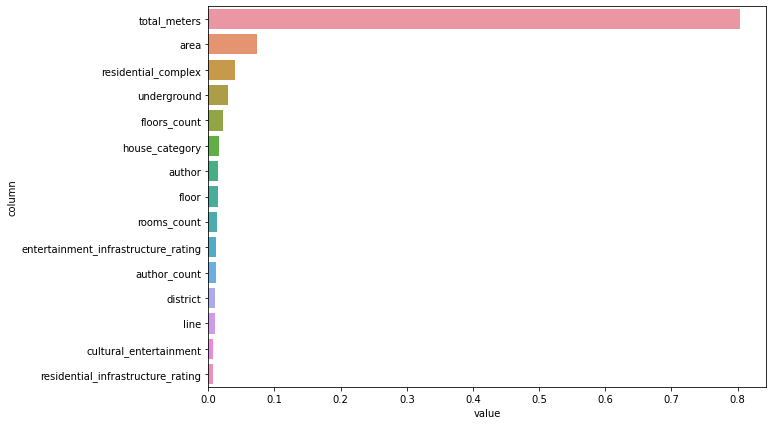

In [18]:
feature_imp = pd.DataFrame()
feature_imp['column'] = X_test.columns
feature_imp['value'] = r['importances_mean']
feature_imp['2_std'] = 2*r['importances_std']

feature_imp.sort_values(by='value', inplace=True, ascending=False)

plt.figure(figsize=(10, 7))
sns.barplot(data=feature_imp[:15], x='value', y='column');

## Holdout

In [19]:
def cross_validation(y_train: pd.DataFrame,
                     X_train: pd.DataFrame,
                     params: dict,
                     model,
                     eval_set: list,
                     eval_metric='MAE',
                     n_splits: int = 5,
                     random_state: int = RAND,
                     shuffle: bool = True,
                     cat_features: list = None,
                     early_stopping_rounds: int = None,
                     silent: bool = None):
    """
    Получение результатов при помощи кросс-валидации
    """

    folds = KFold(n_splits=n_splits,
                  random_state=random_state,
                  shuffle=shuffle)
    score_oof = []
    predictions_test = []

    for fold, (train_index,
               test_index) in enumerate(folds.split(X_train, y_train)):
        X_train_, X_val = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_, y_val = y_train[train_index], y_train[test_index]

        mod = model(**params, eval_metric=eval_metric)

        if silent == None:
            mod.fit(X_train_,
                    y_train_,
                    eval_set=eval_set,
                    early_stopping_rounds=early_stopping_rounds)
        else:
            mod.fit(X_train_,
                    y_train_,
                    eval_set=eval_set,
                    silent=silent,
                    cat_features=cat_features,
                    early_stopping_rounds=early_stopping_rounds)

        y_pred_val = mod.predict(X_val)
        y_pred = mod.predict(X_test)

        print("Fold:", fold + 1,
              "MAE SCORE %.3f" % mean_absolute_error(y_val, y_pred_val))
        print("---")

        # oof list
        score_oof.append(mean_absolute_error(y_val, y_pred_val))
        # holdout list
        predictions_test.append(y_pred)
    return score_oof, predictions_test, mod

In [20]:
score_oof, predictions_test, model = cross_validation(y_train=y_train,
                                               X_train=X_train,
                                               params=grid_search_result['params'],
                                               model=CatBoostRegressor,
                                               eval_set=eval_set,
                                               cat_features=cat_features,
                                               early_stopping_rounds=100,
                                               silent = True)

Fold: 1 MAE SCORE 5350964.586
---
Fold: 2 MAE SCORE 4861682.931
---
Fold: 3 MAE SCORE 5071664.222
---
Fold: 4 MAE SCORE 5271257.231
---
Fold: 5 MAE SCORE 4992170.787
---


In [21]:
test_pred = np.mean(predictions_test, axis=0)
metrics = metrics.append(get_metrics_regression(y_test=y_test,
                           y_pred=test_pred,
                           X_test=X_test,
                           name='CatBoost_Holdout1'))
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,CatBoost_RandGrid,4.967333e+06,8.276082e+13,9.097297e+06,0.20387,0.916035,-2.531507,15.054549,15.135094
0,CatBoost_Holdout1,4.756412e+06,7.890528e+13,8.882864e+06,0.18607,0.919947,-2.668756,13.895236,14.492433


In [22]:
overfitting = overfitting.append(check_overfitting_df(model, X_train, y_train, X_test,
                         y_test, mean_absolute_error, name='CatBoost_Holdout1'))
overfitting

,model,metric,value_train,value_test,overfitting
0,RandGrid,mean_absolute_error,3.633553e+06,4.967333e+06,26.851029
0,CatBoost_Holdout1,mean_absolute_error,3.838204e+06,5.250538e+06,26.898830


**Лучшие гиперпараметры после кросс-валидации**

{'border_count': 254,
 'depth': 9,
 'random_seed': 10,
 'iterations': 500,
 'learning_rate': 0.2945510204081633,
 'l2_leaf_reg': 46.41588833612773}
 
4.861167e+06	8.114826e+13	9.008233e+06	0.190663	0.917671	-2.817635	14.331004	14.811614
    
mean_absolute_error train: 4055778.014
mean_absolute_error test: 5319802.573
delta = 23.8 %

{'border_count': 128,
 'depth': 6,
 'random_seed': 10,
 'iterations': 700,
 'learning_rate': 0.2945510204081633,
 'l2_leaf_reg': 46.41588833612773}
 
 4.905495e+06	8.016202e+13	8.953324e+06	0.191675	0.918672	-3.07626	14.592394	14.946678
 
 mean_absolute_error train: 4168933.749
mean_absolute_error test: 5272064.241
delta = 20.9 %

{'border_count': 128,
 'depth': 6,
 'random_seed': 10,
 'iterations': 600,
 'learning_rate': 0.2945510204081633,
 'l2_leaf_reg': 46.41588833612773}

4.957574e+06	8.149200e+13	9.027292e+06	0.193383	0.917322	-3.053179	14.751694	15.105358

mean_absolute_error train: 4295351.570
mean_absolute_error test: 5312687.623
delta = 19.1 %

In [23]:
folds = KFold(n_splits=5, random_state=RAND, shuffle=True)
score_oof = []
predictions_test = []

for fold, (train_index,
           test_index) in enumerate(folds.split(X_train, y_train)):
    X_train_, X_val = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_, y_val = y_train[train_index], y_train[test_index]
    y_val_exp = np.exp(y_val) - 1

    model_ctb = CatBoostRegressor(border_count = 128,
                                  depth = 6,
                                  random_seed= 10,
                                  iterations = 700,
                                  learning_rate = 0.2945510204081633,
                                  l2_leaf_reg = 46.41588833612773,
                                  eval_metric='MAE')

    model_ctb.fit(X_train_,
                  y_train_,
                  eval_set=[(X_val, y_val)],
                  # eval_metric='mae',
                  silent=True,
                  cat_features=cat_features,
                  early_stopping_rounds=100)

    y_pred_val = model_ctb.predict(X_val)
    y_pred = model_ctb.predict(X_test)

    print(
        "Fold:", fold + 1,
        "MAE SCORE %.3f" % mean_absolute_error(y_val, y_pred_val))
    print("---")

    # oof list
    score_oof.append(mean_absolute_error(y_val, y_pred_val))
    # holdout list
    predictions_test.append(y_pred)

Fold: 1 MAE SCORE 5343766.642
---
Fold: 2 MAE SCORE 5189360.938
---
Fold: 3 MAE SCORE 5044720.305
---
Fold: 4 MAE SCORE 5370762.735
---
Fold: 5 MAE SCORE 5140866.860
---


In [24]:
params_ctb = {'border_count': 128,
              'depth': 6,
              'random_seed': 10,
              'iterations': 700,
              'learning_rate': 0.2945510204081633,
              'l2_leaf_reg': 46.41588833612773}

score_oof, predictions_test, model_ctb = cross_validation(y_train=y_train,
                                                      X_train=X_train,
                                                      params=params_ctb,
                                                      model=CatBoostRegressor,
                                                      eval_set=eval_set,
                                                      cat_features=cat_features,
                                                      early_stopping_rounds=100,
                                                      silent=True)

Fold: 1 MAE SCORE 5343766.642
---
Fold: 2 MAE SCORE 5193386.251
---
Fold: 3 MAE SCORE 5045621.903
---
Fold: 4 MAE SCORE 5373803.843
---
Fold: 5 MAE SCORE 5140866.860
---


In [25]:
test_pred = np.mean(predictions_test, axis=0)
metrics = metrics.append(get_metrics_regression(y_test=y_test,
                           y_pred=test_pred,
                           X_test=X_test,
                           name='CatBoost_Holdout2'))
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,CatBoost_RandGrid,4.967333e+06,8.276082e+13,9.097297e+06,0.203870,0.916035,-2.531507,15.054549,15.135094
0,CatBoost_Holdout1,4.756412e+06,7.890528e+13,8.882864e+06,0.186070,0.919947,-2.668756,13.895236,14.492433
0,CatBoost_Holdout2,4.893431e+06,7.993215e+13,8.940478e+06,0.191441,0.918905,-3.067982,14.564159,14.909922


In [26]:
overfitting = overfitting.append(check_overfitting_df(model_ctb, X_train, y_train, X_test,
                         y_test, mean_absolute_error, 'CatBoost_Holdout2'))
overfitting

,model,metric,value_train,value_test,overfitting
0,RandGrid,mean_absolute_error,3.633553e+06,4.967333e+06,26.851029
0,CatBoost_Holdout1,mean_absolute_error,3.838204e+06,5.250538e+06,26.898830
0,CatBoost_Holdout2,mean_absolute_error,4.168934e+06,5.272064e+06,20.924072


# Tuning LGBM

In [27]:
def objective_lgb(trial, X, y, N_FOLDS, random_state=RAND):
    lgb_params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [700]),
        #0.043951055006703106
        #0.16026842065243738
        "learning_rate": trial.suggest_categorical("learning_rate", [0.08266612818632631]),
         #"learning_rate": trial.suggest_float("learning_rate",
         #                                  0.001,
         #                                  0.3,
         #                                 log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 1000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "max_bin": trial.suggest_int("max_bin", 50, 300),
        "min_child_samples": trial.suggest_int("min_child_samples", 100, 70000, step=100),
        'bagging_freq': trial.suggest_int("bagging_freq", 1, 10),
        "reg_alpha": trial.suggest_int("reg_alpha", 0, 100),
        "reg_lambda": trial.suggest_int("reg_lambda", 0, 100),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "subsample_freq": trial.suggest_categorical("subsample_freq", [1]),
        'early_stopping_rounds': trial.suggest_categorical("early_stopping_rounds",
                                                   [100]),
        "random_state": trial.suggest_categorical("random_state",
                                                  [random_state])
    }

    N_FOLDS = 4
    cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)

    cv_predicts = np.empty(N_FOLDS)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        #X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        #y_train, y_test = y[train_idx], y[test_idx]

        pruning_callback = optuna.integration.LightGBMPruningCallback(
            trial, "l1")
        model = LGBMRegressor(**lgb_params)
        model.fit(X_train,
                  y_train,
                  eval_set=[(X_test, y_test)],
                  eval_metric="MAE",
                  callbacks=[pruning_callback],
                  verbose=0)

        preds = model.predict(X_test)
        cv_predicts[idx] = mean_absolute_error(y_test, preds)

    return np.mean(cv_predicts)

In [28]:
study_lgbm = optuna.create_study(direction="minimize", study_name="LGB")
func = lambda trial: objective_lgb(
    trial, X_train, y_train, N_FOLDS=N_FOLDS, random_state=RAND)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_lgbm.optimize(func, n_trials=30, show_progress_bar=True)

[I 2023-06-15 14:07:00,770] A new study created in memory with name: LGB


  0%|          | 0/30 [00:00<?, ?it/s]

[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=1 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=1 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=1 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=1 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning]

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=1 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=1 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=1 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=1 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning]

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=1 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=1 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=1 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=1 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning]

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=1 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=1 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=1 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=1 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning]

In [29]:
print(f"\tBest value: {study_lgbm.best_value:.5f}")
print(f"\tBest params: {study_lgbm.best_params}")

	Best value: 8069302.22352
	Best params: {'n_estimators': 700, 'learning_rate': 0.08266612818632631, 'num_leaves': 20, 'max_depth': 3, 'max_bin': 233, 'min_child_samples': 400, 'bagging_freq': 7, 'reg_alpha': 16, 'reg_lambda': 100, 'subsample': 0.2086389665597495, 'subsample_freq': 1, 'early_stopping_rounds': 100, 'random_state': 10}


In [30]:
lgb_opt = LGBMRegressor(**study_lgbm.best_params)
lgb_opt.fit(X_train_,
            y_train_,
            eval_metric="MAE",
            eval_set=eval_set,
            verbose=False,
            early_stopping_rounds=100)

y_pred = lgb_opt.predict(X_test)

metrics = metrics.append(get_metrics_regression(y_test=y_test,
                           y_pred=y_pred,
                           X_test=X_test,
                           name='LGBoost_Optuna'))
metrics

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=1 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100


,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,CatBoost_RandGrid,4.967333e+06,8.276082e+13,9.097297e+06,0.203870,0.916035,-2.531507,15.054549,15.135094
0,CatBoost_Holdout1,4.756412e+06,7.890528e+13,8.882864e+06,0.186070,0.919947,-2.668756,13.895236,14.492433
0,CatBoost_Holdout2,4.893431e+06,7.993215e+13,8.940478e+06,0.191441,0.918905,-3.067982,14.564159,14.909922
0,LGBoost_Optuna,9.072471e+06,2.053887e+14,1.433139e+07,NaN,0.791623,-8.101797,34.450539,27.643143


In [31]:
overfitting = overfitting.append(check_overfitting_df(lgb_opt, X_train, y_train, X_test,
                         y_test, mean_absolute_error, 'LGBoost_Optuna'))
overfitting

,model,metric,value_train,value_test,overfitting
0,RandGrid,mean_absolute_error,3.633553e+06,4.967333e+06,26.851029
0,CatBoost_Holdout1,mean_absolute_error,3.838204e+06,5.250538e+06,26.898830
0,CatBoost_Holdout2,mean_absolute_error,4.168934e+06,5.272064e+06,20.924072
0,LGBoost_Optuna,mean_absolute_error,8.953379e+06,9.072471e+06,1.312673


## Feature importances

In [32]:
r = permutation_importance(lgb_opt,
                           X_test,
                           y_test,
                           n_repeats=4,
                           random_state=RAND)

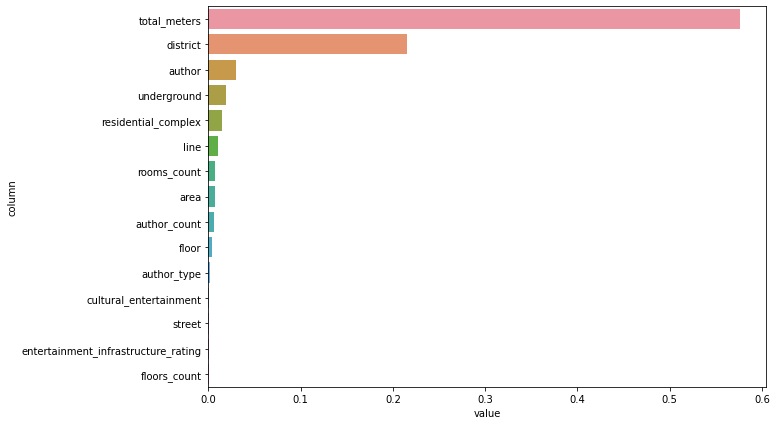

In [33]:
feature_imp = pd.DataFrame()
feature_imp['column'] = X_test.columns
feature_imp['value'] = r['importances_mean']
feature_imp['2_std'] = 2*r['importances_std']

feature_imp.sort_values(by='value', inplace=True, ascending=False)

plt.figure(figsize=(10, 7))
sns.barplot(data=feature_imp[:15], x='value', y='column');

## Holdout

In [34]:
score_oof, predictions_test, model = cross_validation(y_train=y_train,
                                               X_train=X_train,
                                               params=study_lgbm.best_params,
                                               model=LGBMRegressor,
                                               eval_set=eval_set,
                                               early_stopping_rounds=100)

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=1 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[1]	valid_0's l2: 1.01175e+15
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 9.42675e+14
[3]	valid_0's l2: 8.82446e+14
[4]	valid_0's l2: 8.31817e+14
[5]	valid_0's l2: 7.84314e+14
[6]	valid_0's l2: 7.43617e+14
[7]	valid_0's l2: 7.0721e+14
[8]	valid_0's l2: 6.76723e+14
[9]	valid_0's l2: 6.45596e+14
[10]	valid_0's l2: 6.16014e+14
[11]	valid_0's l2: 5.8967e+14
[12]	valid_0's l2: 5.65757e+14
[13]	valid_0's l2: 5.44316e+14
[14]	valid_0's l2: 5.25021e+14
[15]	valid_0's l2: 5.07738e+14
[16]	valid_0's l2: 4.92673e+14
[17]	valid_0's l2: 4.78745e+14
[18]	valid_0's l2: 4.6685e+14
[19]	valid_0's l2: 4.55487e+14
[20]	valid_0's l2: 4.44178e+14
[21]	valid_0's l2: 4.34588e+14
[2

[308]	valid_0's l2: 2.39149e+14
[309]	valid_0's l2: 2.38949e+14
[310]	valid_0's l2: 2.38769e+14
[311]	valid_0's l2: 2.38686e+14
[312]	valid_0's l2: 2.38598e+14
[313]	valid_0's l2: 2.38583e+14
[314]	valid_0's l2: 2.38582e+14
[315]	valid_0's l2: 2.38606e+14
[316]	valid_0's l2: 2.38182e+14
[317]	valid_0's l2: 2.37919e+14
[318]	valid_0's l2: 2.3771e+14
[319]	valid_0's l2: 2.37544e+14
[320]	valid_0's l2: 2.37529e+14
[321]	valid_0's l2: 2.3732e+14
[322]	valid_0's l2: 2.37236e+14
[323]	valid_0's l2: 2.37099e+14
[324]	valid_0's l2: 2.37052e+14
[325]	valid_0's l2: 2.36963e+14
[326]	valid_0's l2: 2.363e+14
[327]	valid_0's l2: 2.36248e+14
[328]	valid_0's l2: 2.35631e+14
[329]	valid_0's l2: 2.35663e+14
[330]	valid_0's l2: 2.35338e+14
[331]	valid_0's l2: 2.35431e+14
[332]	valid_0's l2: 2.35439e+14
[333]	valid_0's l2: 2.35487e+14
[334]	valid_0's l2: 2.35282e+14
[335]	valid_0's l2: 2.35447e+14
[336]	valid_0's l2: 2.35453e+14
[337]	valid_0's l2: 2.35502e+14
[338]	valid_0's l2: 2.35435e+14
[339]	valid_

[668]	valid_0's l2: 2.23546e+14
[669]	valid_0's l2: 2.23644e+14
[670]	valid_0's l2: 2.2369e+14
[671]	valid_0's l2: 2.23808e+14
[672]	valid_0's l2: 2.2392e+14
[673]	valid_0's l2: 2.23624e+14
[674]	valid_0's l2: 2.23567e+14
[675]	valid_0's l2: 2.22912e+14
[676]	valid_0's l2: 2.22746e+14
[677]	valid_0's l2: 2.22746e+14
[678]	valid_0's l2: 2.22274e+14
[679]	valid_0's l2: 2.21862e+14
[680]	valid_0's l2: 2.21705e+14
[681]	valid_0's l2: 2.21586e+14
[682]	valid_0's l2: 2.21472e+14
[683]	valid_0's l2: 2.21477e+14
[684]	valid_0's l2: 2.21441e+14
[685]	valid_0's l2: 2.21333e+14
[686]	valid_0's l2: 2.21377e+14
[687]	valid_0's l2: 2.21232e+14
[688]	valid_0's l2: 2.21132e+14
[689]	valid_0's l2: 2.2104e+14
[690]	valid_0's l2: 2.21028e+14
[691]	valid_0's l2: 2.21033e+14
[692]	valid_0's l2: 2.21085e+14
[693]	valid_0's l2: 2.21109e+14
[694]	valid_0's l2: 2.20993e+14
[695]	valid_0's l2: 2.20845e+14
[696]	valid_0's l2: 2.20733e+14
[697]	valid_0's l2: 2.20706e+14
[698]	valid_0's l2: 2.2062e+14
[699]	valid_

[488]	valid_0's l2: 2.192e+14
[489]	valid_0's l2: 2.19136e+14
[490]	valid_0's l2: 2.19044e+14
[491]	valid_0's l2: 2.18833e+14
[492]	valid_0's l2: 2.18571e+14
[493]	valid_0's l2: 2.18437e+14
[494]	valid_0's l2: 2.18354e+14
[495]	valid_0's l2: 2.18219e+14
[496]	valid_0's l2: 2.18165e+14
[497]	valid_0's l2: 2.18165e+14
[498]	valid_0's l2: 2.17972e+14
[499]	valid_0's l2: 2.1791e+14
[500]	valid_0's l2: 2.1789e+14
[501]	valid_0's l2: 2.17843e+14
[502]	valid_0's l2: 2.17791e+14
[503]	valid_0's l2: 2.1775e+14
[504]	valid_0's l2: 2.17814e+14
[505]	valid_0's l2: 2.17935e+14
[506]	valid_0's l2: 2.18026e+14
[507]	valid_0's l2: 2.18161e+14
[508]	valid_0's l2: 2.18117e+14
[509]	valid_0's l2: 2.18283e+14
[510]	valid_0's l2: 2.18265e+14
[511]	valid_0's l2: 2.18334e+14
[512]	valid_0's l2: 2.18011e+14
[513]	valid_0's l2: 2.17376e+14
[514]	valid_0's l2: 2.17123e+14
[515]	valid_0's l2: 2.16582e+14
[516]	valid_0's l2: 2.16476e+14
[517]	valid_0's l2: 2.16404e+14
[518]	valid_0's l2: 2.15951e+14
[519]	valid_0

[315]	valid_0's l2: 2.27869e+14
[316]	valid_0's l2: 2.27838e+14
[317]	valid_0's l2: 2.27847e+14
[318]	valid_0's l2: 2.27828e+14
[319]	valid_0's l2: 2.27822e+14
[320]	valid_0's l2: 2.2785e+14
[321]	valid_0's l2: 2.2789e+14
[322]	valid_0's l2: 2.28011e+14
[323]	valid_0's l2: 2.2767e+14
[324]	valid_0's l2: 2.27478e+14
[325]	valid_0's l2: 2.27233e+14
[326]	valid_0's l2: 2.27116e+14
[327]	valid_0's l2: 2.26914e+14
[328]	valid_0's l2: 2.2652e+14
[329]	valid_0's l2: 2.26356e+14
[330]	valid_0's l2: 2.26401e+14
[331]	valid_0's l2: 2.26453e+14
[332]	valid_0's l2: 2.26528e+14
[333]	valid_0's l2: 2.26592e+14
[334]	valid_0's l2: 2.26675e+14
[335]	valid_0's l2: 2.26755e+14
[336]	valid_0's l2: 2.26769e+14
[337]	valid_0's l2: 2.2654e+14
[338]	valid_0's l2: 2.26204e+14
[339]	valid_0's l2: 2.26039e+14
[340]	valid_0's l2: 2.25787e+14
[341]	valid_0's l2: 2.25534e+14
[342]	valid_0's l2: 2.2537e+14
[343]	valid_0's l2: 2.25169e+14
[344]	valid_0's l2: 2.25268e+14
[345]	valid_0's l2: 2.25392e+14
[346]	valid_0'

Fold: 3 MAE SCORE 9535861.280
---
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=1 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[1]	valid_0's l2: 1.00948e+15
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 9.37497e+14
[3]	valid_0's l2: 8.74782e+14
[4]	valid_0's l2: 8.20981e+14
[5]	valid_0's l2: 7.72818e+14
[6]	valid_0's l2: 7.3082e+14
[7]	valid_0's l2: 6.96414e+14
[8]	valid_0's l2: 6.62079e+14
[9]	valid_0's l2: 6.32253e+14
[10]	valid_0's l2: 6.04816e+14
[11]	valid_0's l2: 5.80508e+14
[12]	valid_0's l2: 5.57966e+14
[13]	valid_0's l2: 5.38617e+14
[14]	valid_0's l2: 5.19913e+14
[15]	valid_0's l2: 5.04015e+14
[16]	valid_0's l2: 4.89907e+14
[17]	valid_0's l2: 4.76615e+14
[18]	valid_0's l2: 4.65864e+14
[19]	valid_0's l2: 4.54731e+14
[20]	valid_0's l2: 4.44736e+

[263]	valid_0's l2: 2.30376e+14
[264]	valid_0's l2: 2.30319e+14
[265]	valid_0's l2: 2.3025e+14
[266]	valid_0's l2: 2.30216e+14
[267]	valid_0's l2: 2.30119e+14
[268]	valid_0's l2: 2.30019e+14
[269]	valid_0's l2: 2.29965e+14
[270]	valid_0's l2: 2.29965e+14
[271]	valid_0's l2: 2.30114e+14
[272]	valid_0's l2: 2.30177e+14
[273]	valid_0's l2: 2.30282e+14
[274]	valid_0's l2: 2.30056e+14
[275]	valid_0's l2: 2.29481e+14
[276]	valid_0's l2: 2.29337e+14
[277]	valid_0's l2: 2.28723e+14
[278]	valid_0's l2: 2.2868e+14
[279]	valid_0's l2: 2.282e+14
[280]	valid_0's l2: 2.28104e+14
[281]	valid_0's l2: 2.28124e+14
[282]	valid_0's l2: 2.28214e+14
[283]	valid_0's l2: 2.28305e+14
[284]	valid_0's l2: 2.28417e+14
[285]	valid_0's l2: 2.27997e+14
[286]	valid_0's l2: 2.28108e+14
[287]	valid_0's l2: 2.28276e+14
[288]	valid_0's l2: 2.28317e+14
[289]	valid_0's l2: 2.28527e+14
[290]	valid_0's l2: 2.28657e+14
[291]	valid_0's l2: 2.28774e+14
[292]	valid_0's l2: 2.28935e+14
[293]	valid_0's l2: 2.28882e+14
[294]	valid_

[655]	valid_0's l2: 2.13191e+14
[656]	valid_0's l2: 2.13318e+14
[657]	valid_0's l2: 2.13466e+14
[658]	valid_0's l2: 2.13603e+14
[659]	valid_0's l2: 2.13032e+14
[660]	valid_0's l2: 2.12678e+14
[661]	valid_0's l2: 2.1232e+14
[662]	valid_0's l2: 2.12046e+14
[663]	valid_0's l2: 2.11728e+14
[664]	valid_0's l2: 2.11595e+14
[665]	valid_0's l2: 2.11421e+14
[666]	valid_0's l2: 2.11172e+14
[667]	valid_0's l2: 2.10951e+14
[668]	valid_0's l2: 2.10797e+14
[669]	valid_0's l2: 2.1069e+14
[670]	valid_0's l2: 2.1059e+14
[671]	valid_0's l2: 2.10593e+14
[672]	valid_0's l2: 2.10499e+14
[673]	valid_0's l2: 2.10381e+14
[674]	valid_0's l2: 2.103e+14
[675]	valid_0's l2: 2.10311e+14
[676]	valid_0's l2: 2.10296e+14
[677]	valid_0's l2: 2.10266e+14
[678]	valid_0's l2: 2.10262e+14
[679]	valid_0's l2: 2.1018e+14
[680]	valid_0's l2: 2.10187e+14
[681]	valid_0's l2: 2.1015e+14
[682]	valid_0's l2: 2.10212e+14
[683]	valid_0's l2: 2.10213e+14
[684]	valid_0's l2: 2.10199e+14
[685]	valid_0's l2: 2.10286e+14
[686]	valid_0's

[437]	valid_0's l2: 2.11426e+14
[438]	valid_0's l2: 2.11355e+14
[439]	valid_0's l2: 2.11299e+14
[440]	valid_0's l2: 2.11268e+14
[441]	valid_0's l2: 2.11303e+14
[442]	valid_0's l2: 2.10921e+14
[443]	valid_0's l2: 2.10751e+14
[444]	valid_0's l2: 2.10437e+14
[445]	valid_0's l2: 2.10366e+14
[446]	valid_0's l2: 2.10256e+14
[447]	valid_0's l2: 2.10122e+14
[448]	valid_0's l2: 2.09983e+14
[449]	valid_0's l2: 2.09879e+14
[450]	valid_0's l2: 2.0961e+14
[451]	valid_0's l2: 2.094e+14
[452]	valid_0's l2: 2.09243e+14
[453]	valid_0's l2: 2.09123e+14
[454]	valid_0's l2: 2.0911e+14
[455]	valid_0's l2: 2.09024e+14
[456]	valid_0's l2: 2.09254e+14
[457]	valid_0's l2: 2.09415e+14
[458]	valid_0's l2: 2.09532e+14
[459]	valid_0's l2: 2.09672e+14
[460]	valid_0's l2: 2.09908e+14
[461]	valid_0's l2: 2.10131e+14
[462]	valid_0's l2: 2.10443e+14
[463]	valid_0's l2: 2.10311e+14
[464]	valid_0's l2: 2.1017e+14
[465]	valid_0's l2: 2.10151e+14
[466]	valid_0's l2: 2.10015e+14
[467]	valid_0's l2: 2.09924e+14
[468]	valid_0

Fold: 5 MAE SCORE 8848183.436
---


In [35]:
test_pred = np.mean(predictions_test, axis=0)
metrics = metrics.append(get_metrics_regression(y_test=y_test,
                           y_pred=test_pred,
                           X_test=X_test,
                           name='LGBoost_Holdout1'))

In [36]:
overfitting = overfitting.append(check_overfitting_df(model, X_train, y_train, X_test,
                         y_test, mean_absolute_error, 'LGBoost_Holdout1'))
overfitting

,model,metric,value_train,value_test,overfitting
0,RandGrid,mean_absolute_error,3.633553e+06,4.967333e+06,26.851029
0,CatBoost_Holdout1,mean_absolute_error,3.838204e+06,5.250538e+06,26.898830
0,CatBoost_Holdout2,mean_absolute_error,4.168934e+06,5.272064e+06,20.924072
0,LGBoost_Optuna,mean_absolute_error,8.953379e+06,9.072471e+06,1.312673
0,LGBoost_Holdout1,mean_absolute_error,8.905801e+06,9.020476e+06,1.271275


In [37]:
params = {
    'n_estimators': 300,
    'learning_rate': 0.043951055006703106,
    'num_leaves': 380,
    'max_depth': 11,
    'max_bin': 97,
    'min_child_samples': 100,
    'bagging_freq': 7,
    'reg_alpha': 4,
    'reg_lambda': 82,
    'subsample': 0.8840474433403047,
    'subsample_freq': 1,
    'random_state': 10
}

score_oof, predictions_test, model = cross_validation(
    y_train=y_train,
    X_train=X_train,
    params=params,
    model=LGBMRegressor,
    eval_set=eval_set,
    early_stopping_rounds=100)

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=1 will be ignored. Current value: bagging_freq=7
[1]	valid_0's l2: 1.02775e+15
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 9.67875e+14
[3]	valid_0's l2: 9.14542e+14
[4]	valid_0's l2: 8.6304e+14
[5]	valid_0's l2: 8.15824e+14
[6]	valid_0's l2: 7.72108e+14
[7]	valid_0's l2: 7.32627e+14
[8]	valid_0's l2: 6.9565e+14
[9]	valid_0's l2: 6.61467e+14
[10]	valid_0's l2: 6.30169e+14
[11]	valid_0's l2: 6.01541e+14
[12]	valid_0's l2: 5.74618e+14
[13]	valid_0's l2: 5.4988e+14
[14]	valid_0's l2: 5.25844e+14
[15]	valid_0's l2: 5.02683e+14
[16]	valid_0's l2: 4.81193e+14
[17]	valid_0's l2: 4.61818e+14
[18]	valid_0's l2: 4.43165e+14
[19]	valid_0's l2: 4.24962e+14
[20]	valid_0's l2: 4.09482e+14
[21]	valid_0's l2: 3.94549e+14
[22]	valid_0's l2: 3.8051e+14
[23]	valid_0's l2: 3.6759e+14
[24]	valid_0's l2: 3.55208e+14
[25]	valid_0's l2: 3.43731e+14
[26]	valid_0's l2

[292]	valid_0's l2: 1.07296e+14
[293]	valid_0's l2: 1.07266e+14
[294]	valid_0's l2: 1.07268e+14
[295]	valid_0's l2: 1.07194e+14
[296]	valid_0's l2: 1.07171e+14
[297]	valid_0's l2: 1.07113e+14
[298]	valid_0's l2: 1.07098e+14
[299]	valid_0's l2: 1.07096e+14
[300]	valid_0's l2: 1.06987e+14
Did not meet early stopping. Best iteration is:
[300]	valid_0's l2: 1.06987e+14
Fold: 1 MAE SCORE 5289465.817
---
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=1 will be ignored. Current value: bagging_freq=7
[1]	valid_0's l2: 1.02559e+15
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 9.66202e+14
[3]	valid_0's l2: 9.10409e+14
[4]	valid_0's l2: 8.58866e+14
[5]	valid_0's l2: 8.1197e+14
[6]	valid_0's l2: 7.68687e+14
[7]	valid_0's l2: 7.28258e+14
[8]	valid_0's l2: 6.89754e+14
[9]	valid_0's l2: 6.55315e+14
[10]	valid_0's l2: 6.21863e+14
[11]	valid_0's l2: 5.91815e+14
[12]	valid_0's l2: 5.62819e+14
[13]	valid_0's

[299]	valid_0's l2: 5.70041e+13
[300]	valid_0's l2: 5.68793e+13
Did not meet early stopping. Best iteration is:
[300]	valid_0's l2: 5.68793e+13
Fold: 2 MAE SCORE 5197922.250
---
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=1 will be ignored. Current value: bagging_freq=7
[1]	valid_0's l2: 1.02445e+15
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 9.64254e+14
[3]	valid_0's l2: 9.08612e+14
[4]	valid_0's l2: 8.56808e+14
[5]	valid_0's l2: 8.08922e+14
[6]	valid_0's l2: 7.6506e+14
[7]	valid_0's l2: 7.24665e+14
[8]	valid_0's l2: 6.86405e+14
[9]	valid_0's l2: 6.5094e+14
[10]	valid_0's l2: 6.18468e+14
[11]	valid_0's l2: 5.88584e+14
[12]	valid_0's l2: 5.60887e+14
[13]	valid_0's l2: 5.34695e+14
[14]	valid_0's l2: 5.10235e+14
[15]	valid_0's l2: 4.87424e+14
[16]	valid_0's l2: 4.66088e+14
[17]	valid_0's l2: 4.46441e+14
[18]	valid_0's l2: 4.27717e+14
[19]	valid_0's l2: 4.10663e+14
[20]	valid_0's l2: 3.9

[282]	valid_0's l2: 6.05068e+13
[283]	valid_0's l2: 6.04052e+13
[284]	valid_0's l2: 6.03125e+13
[285]	valid_0's l2: 6.01813e+13
[286]	valid_0's l2: 6.00721e+13
[287]	valid_0's l2: 5.99428e+13
[288]	valid_0's l2: 5.98565e+13
[289]	valid_0's l2: 5.97147e+13
[290]	valid_0's l2: 5.96361e+13
[291]	valid_0's l2: 5.95393e+13
[292]	valid_0's l2: 5.94194e+13
[293]	valid_0's l2: 5.92908e+13
[294]	valid_0's l2: 5.91906e+13
[295]	valid_0's l2: 5.90511e+13
[296]	valid_0's l2: 5.8929e+13
[297]	valid_0's l2: 5.88209e+13
[298]	valid_0's l2: 5.86978e+13
[299]	valid_0's l2: 5.85916e+13
[300]	valid_0's l2: 5.85335e+13
Did not meet early stopping. Best iteration is:
[300]	valid_0's l2: 5.85335e+13
Fold: 3 MAE SCORE 5133081.738
---
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=1 will be ignored. Current value: bagging_freq=7
[1]	valid_0's l2: 1.02564e+15
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 9.65599e+

[279]	valid_0's l2: 5.95526e+13
[280]	valid_0's l2: 5.94582e+13
[281]	valid_0's l2: 5.92533e+13
[282]	valid_0's l2: 5.90634e+13
[283]	valid_0's l2: 5.89333e+13
[284]	valid_0's l2: 5.87741e+13
[285]	valid_0's l2: 5.86493e+13
[286]	valid_0's l2: 5.8458e+13
[287]	valid_0's l2: 5.82821e+13
[288]	valid_0's l2: 5.81858e+13
[289]	valid_0's l2: 5.80484e+13
[290]	valid_0's l2: 5.79358e+13
[291]	valid_0's l2: 5.77974e+13
[292]	valid_0's l2: 5.76565e+13
[293]	valid_0's l2: 5.75398e+13
[294]	valid_0's l2: 5.74519e+13
[295]	valid_0's l2: 5.73564e+13
[296]	valid_0's l2: 5.7271e+13
[297]	valid_0's l2: 5.7202e+13
[298]	valid_0's l2: 5.71149e+13
[299]	valid_0's l2: 5.70418e+13
[300]	valid_0's l2: 5.69116e+13
Did not meet early stopping. Best iteration is:
[300]	valid_0's l2: 5.69116e+13
Fold: 4 MAE SCORE 5453865.264
---
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=1 will be ignored. Current value: bagging_freq=7
[1]	valid_0's l2: 1.02553

[262]	valid_0's l2: 6.30984e+13
[263]	valid_0's l2: 6.30221e+13
[264]	valid_0's l2: 6.28639e+13
[265]	valid_0's l2: 6.27648e+13
[266]	valid_0's l2: 6.25598e+13
[267]	valid_0's l2: 6.23847e+13
[268]	valid_0's l2: 6.22044e+13
[269]	valid_0's l2: 6.20089e+13
[270]	valid_0's l2: 6.18527e+13
[271]	valid_0's l2: 6.16996e+13
[272]	valid_0's l2: 6.15594e+13
[273]	valid_0's l2: 6.14036e+13
[274]	valid_0's l2: 6.12878e+13
[275]	valid_0's l2: 6.11548e+13
[276]	valid_0's l2: 6.10181e+13
[277]	valid_0's l2: 6.08951e+13
[278]	valid_0's l2: 6.0773e+13
[279]	valid_0's l2: 6.06142e+13
[280]	valid_0's l2: 6.05557e+13
[281]	valid_0's l2: 6.04531e+13
[282]	valid_0's l2: 6.03718e+13
[283]	valid_0's l2: 6.02298e+13
[284]	valid_0's l2: 6.01373e+13
[285]	valid_0's l2: 5.99964e+13
[286]	valid_0's l2: 5.98618e+13
[287]	valid_0's l2: 5.97402e+13
[288]	valid_0's l2: 5.95242e+13
[289]	valid_0's l2: 5.93241e+13
[290]	valid_0's l2: 5.91694e+13
[291]	valid_0's l2: 5.90401e+13
[292]	valid_0's l2: 5.88675e+13
[293]	val

In [38]:
test_pred = np.mean(predictions_test, axis=0)
metrics = metrics.append(get_metrics_regression(y_test=y_test,
                           y_pred=test_pred,
                           X_test=X_test,
                           name='LGBoost_Holdout2'))

In [39]:
overfitting = overfitting.append(check_overfitting_df(model, X_train, y_train, X_test,
                         y_test, mean_absolute_error, 'LGBoost_Holdout2'))
overfitting

,model,metric,value_train,value_test,overfitting
0,RandGrid,mean_absolute_error,3.633553e+06,4.967333e+06,26.851029
0,CatBoost_Holdout1,mean_absolute_error,3.838204e+06,5.250538e+06,26.898830
0,CatBoost_Holdout2,mean_absolute_error,4.168934e+06,5.272064e+06,20.924072
0,LGBoost_Optuna,mean_absolute_error,8.953379e+06,9.072471e+06,1.312673
0,LGBoost_Holdout1,mean_absolute_error,8.905801e+06,9.020476e+06,1.271275
0,LGBoost_Holdout2,mean_absolute_error,4.115072e+06,5.117229e+06,19.583968


**Лучшие гиперпараметры после кросс валидации**

{'n_estimators': 800, 'learning_rate': 0.07223032728857245, 'num_leaves': 980, 'max_depth': 3, 'max_bin': 300, 'min_child_samples': 100, 'bagging_freq': 4, 'reg_alpha': 100, 'reg_lambda': 25, 'subsample': 0.7321225777942602, 'subsample_freq': 1, 'early_stopping_rounds': 100, 'random_state': 10}

5.204497e+06	8.921973e+13	9.445619e+06	0.22006	0.909482	-3.761122	16.667139	15.857715

mean_absolute_error train: 4271842.743
mean_absolute_error test: 5373177.377
delta = 20.5 %

{'n_estimators': 300, 'learning_rate': 0.043951055006703106, 'num_leaves': 480, 'max_depth': 8, 'max_bin': 180, 'min_child_samples': 200, 'bagging_freq': 7, 'reg_alpha': 65, 'reg_lambda': 19, 'subsample': 0.8493178976412453, 'subsample_freq': 1, 'early_stopping_rounds': 100, 'random_state': 10}

LGBoost_Optuna	5.454023e+06	9.892188e+13	9.945948e+06	0.222044	0.899639	-4.250348	16.535562	16.618001

mean_absolute_error train: 4655210.049
mean_absolute_error test: 5501719.103
delta = 15.4 %

{'n_estimators': 300, 'learning_rate': 0.043951055006703106, 'num_leaves': 380, 'max_depth': 11, 'max_bin': 97, 'min_child_samples': 100, 'bagging_freq': 7, 'reg_alpha': 4, 'reg_lambda': 82, 'subsample': 0.8840474433403047, 'subsample_freq': 1, 'early_stopping_rounds': 100, 'random_state': 10}

5.061593e+06	9.063878e+13	9.520440e+06	0.196417	0.908043	-3.842215	14.532503	15.422297

mean_absolute_error train: 4115072.428
mean_absolute_error test: 5117228.898
delta = 19.6 %

# Stacking

In [40]:
meta_X = pd.DataFrame()
meta_X_test = pd.DataFrame()

pred_val = []

cv = KFold(n_splits=5)
for fold, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    X_train_, X_val = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_, y_val = y_train[train_idx], y_train[test_idx]

    model = LGBMRegressor(
        n_estimators = 300,
        learning_rate = 0.043951055006703106,
        num_leaves = 380,
        max_depth = 11,
        max_bin = 97,
        min_child_samples = 100,
        bagging_freq = 7,
        reg_alpha = 4,
        reg_lambda = 82,
        subsample = 0.8840474433403047,
        subsample_freq = 1,
        random_state = 10
    )
    model.fit(X_train_,
              y_train_,
              eval_set=[(X_val, y_val)],
              eval_metric="mae",
              early_stopping_rounds=100,
              verbose=0)

    y_pred_val = model.predict(X_val)

    print("Fold:", fold + 1,
          "MAE %.3f" % mean_absolute_error(y_val, y_pred_val))
    print("---")

    # holdout list
    pred_val.append(y_pred_val)

# обучаем модель для предсказания на test
model.fit(X_train, y_train)

meta_X['lgb_01'] = np.concatenate(pred_val)
meta_X_test['lgb_01'] = model.predict(X_test)

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=1 will be ignored. Current value: bagging_freq=7
Fold: 1 MAE 5301050.731
---
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=1 will be ignored. Current value: bagging_freq=7
Fold: 2 MAE 5094032.405
---
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=1 will be ignored. Current value: bagging_freq=7
Fold: 3 MAE 5329430.047
---
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=1 will be ignored. Current value: bagging_freq=7
Fold: 4 MAE 5217622.862
---
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=1 will be ignored. Current value: bagging_freq=7
Fold: 5 MAE 5173001.793
---
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=1 will be ignored. Current value: bagging_freq=7


In [41]:
pred_val = []

cv = KFold(n_splits=5)
for fold, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    X_train_, X_val = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_, y_val = y_train[train_idx], y_train[test_idx]

    model = LGBMRegressor(
        n_estimators = 800,
        learning_rate = 0.07223032728857245,
        num_leaves = 980,
        max_depth = 3,
        max_bin = 300,
        min_child_samples = 100,
        bagging_freq = 4,
        reg_alpha = 100,
        reg_lambda = 25,
        subsample = 0.7321225777942602,
        subsample_freq = 1,
        random_state = 10
    )
    model.fit(X_train_,
              y_train_,
              eval_set=[(X_val, y_val)],
              eval_metric="mae",
              early_stopping_rounds=100,
              verbose=0)

    y_pred_val = model.predict(X_val)

    print("Fold:", fold + 1,
          "MAE %.3f" % mean_absolute_error(y_val, y_pred_val))
    print("---")

    # holdout list
    pred_val.append(y_pred_val)

# обучаем модель для предсказания на test
model.fit(X_train, y_train)

meta_X['lgb_02'] = np.concatenate(pred_val)
meta_X_test['lgb_02'] = model.predict(X_test)

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=1 will be ignored. Current value: bagging_freq=4
Fold: 1 MAE 5491734.332
---
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=1 will be ignored. Current value: bagging_freq=4
Fold: 2 MAE 5410002.888
---
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=1 will be ignored. Current value: bagging_freq=4
Fold: 3 MAE 5537544.627
---
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=1 will be ignored. Current value: bagging_freq=4
Fold: 4 MAE 5420883.721
---
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=1 will be ignored. Current value: bagging_freq=4
Fold: 5 MAE 5403436.547
---
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=1 will be ignored. Current value: bagging_freq=4


In [42]:
pred_val = []

cv = KFold(n_splits=5)
for fold, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    X_train_, X_val = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_, y_val = y_train[train_idx], y_train[test_idx]

    model = LGBMRegressor(
        n_estimators = 300,
        learning_rate = 0.043951055006703106,
        num_leaves = 480,
        max_depth = 8,
        max_bin = 180,
        min_child_samples = 200,
        bagging_freq = 7,
        reg_alpha = 65,
        reg_lambda = 19,
        subsample = 0.8493178976412453,
        subsample_freq = 1,
        random_state = 10
    )
    model.fit(X_train_,
              y_train_,
              eval_set=[(X_val, y_val)],
              eval_metric="mae",
              early_stopping_rounds=100,
              verbose=0)

    y_pred_val = model.predict(X_val)

    print("Fold:", fold + 1,
          "MAE %.3f" % mean_absolute_error(y_val, y_pred_val))
    print("---")

    # holdout list
    pred_val.append(y_pred_val)

# обучаем модель для предсказания на test
model.fit(X_train, y_train)

meta_X['lgb_03'] = np.concatenate(pred_val)
meta_X_test['lgb_03'] = model.predict(X_test)

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=1 will be ignored. Current value: bagging_freq=7
Fold: 1 MAE 5743429.669
---
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=1 will be ignored. Current value: bagging_freq=7
Fold: 2 MAE 5497316.729
---
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=1 will be ignored. Current value: bagging_freq=7
Fold: 3 MAE 5717272.644
---
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=1 will be ignored. Current value: bagging_freq=7
Fold: 4 MAE 5492394.815
---
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=1 will be ignored. Current value: bagging_freq=7
Fold: 5 MAE 5548032.346
---
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=1 will be ignored. Current value: bagging_freq=7


In [43]:
pred_val = []

cv = KFold(n_splits=5)
for fold, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    X_train_, X_val = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_, y_val = y_train[train_idx], y_train[test_idx]

    model = CatBoostRegressor(border_count = 128,
                              depth = 6,
                              random_seed = 10,
                              iterations = 600,
                              learning_rate = 0.2945510204081633,
                              l2_leaf_reg = 46.41588833612773)
    model.fit(X_train_,
            y_train_,
            eval_set=[(X_val, y_val)],
            #eval_metric='mae',
            silent=True,
            cat_features=cat_features,
            early_stopping_rounds=100)

    y_pred_val = model.predict(X_val)

    print("Fold:", fold + 1,
          "MAE %.3f" % mean_absolute_error(y_val, y_pred_val))
    print("---")

    # holdout list
    pred_val.append(y_pred_val)

# обучаем модель для предсказания на test
model.fit(X_train, y_train, cat_features=cat_features)

meta_X['ctb_01'] = np.concatenate(pred_val)
meta_X_test['ctb_01'] = model.predict(X_test)

Fold: 1 MAE 5465334.659
---
Fold: 2 MAE 5246949.166
---
Fold: 3 MAE 5350969.095
---
Fold: 4 MAE 5027297.438
---
Fold: 5 MAE 5101684.423
---
0:	learn: 25709146.1926946	total: 25.5ms	remaining: 15.3s
1:	learn: 21905602.8083155	total: 52.6ms	remaining: 15.7s
2:	learn: 19157113.4840781	total: 80ms	remaining: 15.9s
3:	learn: 17125513.3938826	total: 108ms	remaining: 16.2s
4:	learn: 15796722.5241413	total: 137ms	remaining: 16.3s
5:	learn: 14658099.8879384	total: 165ms	remaining: 16.3s
6:	learn: 13816027.9406533	total: 195ms	remaining: 16.5s
7:	learn: 13218506.1480594	total: 233ms	remaining: 17.2s
8:	learn: 12891764.0403894	total: 252ms	remaining: 16.5s
9:	learn: 12533885.9283386	total: 282ms	remaining: 16.6s
10:	learn: 12314561.0803832	total: 310ms	remaining: 16.6s
11:	learn: 12141977.7154124	total: 354ms	remaining: 17.3s
12:	learn: 11925910.6945744	total: 383ms	remaining: 17.3s
13:	learn: 11787660.0019001	total: 413ms	remaining: 17.3s
14:	learn: 11705381.5500288	total: 444ms	remaining: 17.3s

143:	learn: 8788192.0725742	total: 4.17s	remaining: 13.2s
144:	learn: 8765429.1520390	total: 4.2s	remaining: 13.2s
145:	learn: 8751275.4206659	total: 4.23s	remaining: 13.2s
146:	learn: 8750675.0348222	total: 4.26s	remaining: 13.1s
147:	learn: 8736938.2990307	total: 4.29s	remaining: 13.1s
148:	learn: 8736278.9696567	total: 4.31s	remaining: 13.1s
149:	learn: 8735643.1983824	total: 4.34s	remaining: 13s
150:	learn: 8735066.0810873	total: 4.37s	remaining: 13s
151:	learn: 8725066.3328832	total: 4.39s	remaining: 13s
152:	learn: 8724456.7945490	total: 4.42s	remaining: 12.9s
153:	learn: 8703630.8114904	total: 4.45s	remaining: 12.9s
154:	learn: 8687098.4697867	total: 4.48s	remaining: 12.9s
155:	learn: 8655298.3513377	total: 4.51s	remaining: 12.8s
156:	learn: 8655018.4591758	total: 4.54s	remaining: 12.8s
157:	learn: 8652419.6571112	total: 4.57s	remaining: 12.8s
158:	learn: 8648471.4770355	total: 4.59s	remaining: 12.7s
159:	learn: 8634317.8541143	total: 4.63s	remaining: 12.7s
160:	learn: 8624496.7

290:	learn: 7682289.9769468	total: 8.42s	remaining: 8.94s
291:	learn: 7681959.6683102	total: 8.45s	remaining: 8.91s
292:	learn: 7677487.1827216	total: 8.47s	remaining: 8.88s
293:	learn: 7674699.9766871	total: 8.5s	remaining: 8.85s
294:	learn: 7665922.2062443	total: 8.53s	remaining: 8.82s
295:	learn: 7656730.6811967	total: 8.56s	remaining: 8.79s
296:	learn: 7655023.2601454	total: 8.59s	remaining: 8.76s
297:	learn: 7644888.0070863	total: 8.62s	remaining: 8.73s
298:	learn: 7638440.1070810	total: 8.65s	remaining: 8.71s
299:	learn: 7638224.7858269	total: 8.68s	remaining: 8.68s
300:	learn: 7629733.6567781	total: 8.71s	remaining: 8.65s
301:	learn: 7620349.9180285	total: 8.73s	remaining: 8.62s
302:	learn: 7620068.7017714	total: 8.76s	remaining: 8.59s
303:	learn: 7611113.5553779	total: 8.79s	remaining: 8.56s
304:	learn: 7601390.1739229	total: 8.82s	remaining: 8.53s
305:	learn: 7594388.4630796	total: 8.85s	remaining: 8.5s
306:	learn: 7592073.8568097	total: 8.88s	remaining: 8.47s
307:	learn: 7587

432:	learn: 7009640.6422054	total: 12.5s	remaining: 4.82s
433:	learn: 7005294.4913625	total: 12.5s	remaining: 4.79s
434:	learn: 7005170.1477548	total: 12.6s	remaining: 4.76s
435:	learn: 6999116.7002199	total: 12.6s	remaining: 4.74s
436:	learn: 6992817.6031496	total: 12.6s	remaining: 4.71s
437:	learn: 6987128.2820216	total: 12.7s	remaining: 4.68s
438:	learn: 6975042.8690199	total: 12.7s	remaining: 4.65s
439:	learn: 6974921.6689539	total: 12.7s	remaining: 4.62s
440:	learn: 6959212.1780180	total: 12.7s	remaining: 4.59s
441:	learn: 6959053.9343411	total: 12.8s	remaining: 4.56s
442:	learn: 6954590.5643100	total: 12.8s	remaining: 4.53s
443:	learn: 6953610.7622355	total: 12.8s	remaining: 4.5s
444:	learn: 6948142.0336064	total: 12.8s	remaining: 4.47s
445:	learn: 6943905.2891731	total: 12.9s	remaining: 4.45s
446:	learn: 6935305.2297688	total: 12.9s	remaining: 4.42s
447:	learn: 6923933.1739644	total: 12.9s	remaining: 4.39s
448:	learn: 6923127.4926022	total: 13s	remaining: 4.36s
449:	learn: 69169

579:	learn: 6367250.2809282	total: 16.8s	remaining: 578ms
580:	learn: 6360424.9657994	total: 16.8s	remaining: 549ms
581:	learn: 6355771.4488977	total: 16.8s	remaining: 520ms
582:	learn: 6349937.8569498	total: 16.8s	remaining: 491ms
583:	learn: 6344437.1380802	total: 16.9s	remaining: 462ms
584:	learn: 6341011.1257366	total: 16.9s	remaining: 433ms
585:	learn: 6338137.4274663	total: 16.9s	remaining: 405ms
586:	learn: 6337163.3755096	total: 17s	remaining: 376ms
587:	learn: 6334355.2153754	total: 17s	remaining: 347ms
588:	learn: 6326812.1890874	total: 17s	remaining: 318ms
589:	learn: 6324198.8716943	total: 17s	remaining: 289ms
590:	learn: 6318886.1560623	total: 17.1s	remaining: 260ms
591:	learn: 6315131.3782997	total: 17.1s	remaining: 231ms
592:	learn: 6311176.3564173	total: 17.1s	remaining: 202ms
593:	learn: 6298276.7212129	total: 17.2s	remaining: 173ms
594:	learn: 6296492.4041395	total: 17.2s	remaining: 144ms
595:	learn: 6295326.1376148	total: 17.2s	remaining: 116ms
596:	learn: 6287204.95

In [44]:
pred_val = []

cv = KFold(n_splits=5)
for fold, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    X_train_, X_val = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_, y_val = y_train[train_idx], y_train[test_idx]

    model = CatBoostRegressor(border_count = 128,
                              depth = 6,
                              random_seed = 10,
                              iterations = 700,
                              learning_rate = 0.2945510204081633,
                              l2_leaf_reg = 46.41588833612773)
    model.fit(X_train_,
            y_train_,
            eval_set=[(X_val, y_val)],
            #eval_metric='mae',
            silent=True,
            cat_features=cat_features,
            early_stopping_rounds=100)

    y_pred_val = model.predict(X_val)

    print("Fold:", fold + 1,
          "MAE %.3f" % mean_absolute_error(y_val, y_pred_val))
    print("---")

    # holdout list
    pred_val.append(y_pred_val)

# обучаем модель для предсказания на test
model.fit(X_train, y_train, cat_features=cat_features)

meta_X['ctb_02'] = np.concatenate(pred_val)
meta_X_test['ctb_02'] = model.predict(X_test)

Fold: 1 MAE 5436143.868
---
Fold: 2 MAE 5219397.848
---
Fold: 3 MAE 5321682.643
---
Fold: 4 MAE 4993924.094
---
Fold: 5 MAE 5062065.379
---
0:	learn: 25709146.1926946	total: 24.4ms	remaining: 17s
1:	learn: 21905602.8083155	total: 50.4ms	remaining: 17.6s
2:	learn: 19157113.4840781	total: 76.8ms	remaining: 17.8s
3:	learn: 17125513.3938826	total: 105ms	remaining: 18.3s
4:	learn: 15796722.5241413	total: 133ms	remaining: 18.5s
5:	learn: 14658099.8879384	total: 160ms	remaining: 18.5s
6:	learn: 13816027.9406533	total: 189ms	remaining: 18.7s
7:	learn: 13218506.1480594	total: 218ms	remaining: 18.9s
8:	learn: 12891764.0403894	total: 236ms	remaining: 18.1s
9:	learn: 12533885.9283386	total: 263ms	remaining: 18.2s
10:	learn: 12314561.0803832	total: 289ms	remaining: 18.1s
11:	learn: 12141977.7154124	total: 317ms	remaining: 18.1s
12:	learn: 11925910.6945744	total: 344ms	remaining: 18.2s
13:	learn: 11787660.0019001	total: 370ms	remaining: 18.1s
14:	learn: 11705381.5500288	total: 398ms	remaining: 18.2s

148:	learn: 8736278.9696567	total: 4.14s	remaining: 15.3s
149:	learn: 8735643.1983824	total: 4.17s	remaining: 15.3s
150:	learn: 8735066.0810873	total: 4.19s	remaining: 15.2s
151:	learn: 8725066.3328832	total: 4.22s	remaining: 15.2s
152:	learn: 8724456.7945490	total: 4.25s	remaining: 15.2s
153:	learn: 8703630.8114904	total: 4.28s	remaining: 15.2s
154:	learn: 8687098.4697867	total: 4.3s	remaining: 15.1s
155:	learn: 8655298.3513377	total: 4.33s	remaining: 15.1s
156:	learn: 8655018.4591758	total: 4.36s	remaining: 15.1s
157:	learn: 8652419.6571112	total: 4.39s	remaining: 15.1s
158:	learn: 8648471.4770355	total: 4.41s	remaining: 15s
159:	learn: 8634317.8541143	total: 4.44s	remaining: 15s
160:	learn: 8624496.7708733	total: 4.47s	remaining: 15s
161:	learn: 8622179.0377438	total: 4.5s	remaining: 14.9s
162:	learn: 8607222.1930476	total: 4.53s	remaining: 14.9s
163:	learn: 8598960.8714599	total: 4.56s	remaining: 14.9s
164:	learn: 8598049.8152890	total: 4.59s	remaining: 14.9s
165:	learn: 8567987.58

291:	learn: 7681959.6683102	total: 8.1s	remaining: 11.3s
292:	learn: 7677487.1827216	total: 8.12s	remaining: 11.3s
293:	learn: 7674699.9766871	total: 8.15s	remaining: 11.3s
294:	learn: 7665922.2062443	total: 8.18s	remaining: 11.2s
295:	learn: 7656730.6811967	total: 8.21s	remaining: 11.2s
296:	learn: 7655023.2601454	total: 8.24s	remaining: 11.2s
297:	learn: 7644888.0070863	total: 8.27s	remaining: 11.2s
298:	learn: 7638440.1070810	total: 8.29s	remaining: 11.1s
299:	learn: 7638224.7858269	total: 8.32s	remaining: 11.1s
300:	learn: 7629733.6567781	total: 8.36s	remaining: 11.1s
301:	learn: 7620349.9180285	total: 8.39s	remaining: 11.1s
302:	learn: 7620068.7017714	total: 8.42s	remaining: 11s
303:	learn: 7611113.5553779	total: 8.45s	remaining: 11s
304:	learn: 7601390.1739229	total: 8.48s	remaining: 11s
305:	learn: 7594388.4630796	total: 8.51s	remaining: 11s
306:	learn: 7592073.8568097	total: 8.53s	remaining: 10.9s
307:	learn: 7587968.8928202	total: 8.56s	remaining: 10.9s
308:	learn: 7587548.210

433:	learn: 7005294.4913625	total: 12.1s	remaining: 7.39s
434:	learn: 7005170.1477548	total: 12.1s	remaining: 7.36s
435:	learn: 6999116.7002199	total: 12.1s	remaining: 7.34s
436:	learn: 6992817.6031496	total: 12.1s	remaining: 7.31s
437:	learn: 6987128.2820216	total: 12.2s	remaining: 7.28s
438:	learn: 6975042.8690199	total: 12.2s	remaining: 7.25s
439:	learn: 6974921.6689539	total: 12.2s	remaining: 7.23s
440:	learn: 6959212.1780180	total: 12.3s	remaining: 7.2s
441:	learn: 6959053.9343411	total: 12.3s	remaining: 7.17s
442:	learn: 6954590.5643100	total: 12.3s	remaining: 7.14s
443:	learn: 6953610.7622355	total: 12.3s	remaining: 7.11s
444:	learn: 6948142.0336064	total: 12.4s	remaining: 7.09s
445:	learn: 6943905.2891731	total: 12.4s	remaining: 7.06s
446:	learn: 6935305.2297688	total: 12.4s	remaining: 7.03s
447:	learn: 6923933.1739644	total: 12.4s	remaining: 7s
448:	learn: 6923127.4926022	total: 12.5s	remaining: 6.97s
449:	learn: 6916921.1214558	total: 12.5s	remaining: 6.95s
450:	learn: 691394

577:	learn: 6377329.7888920	total: 16s	remaining: 3.38s
578:	learn: 6374710.7521987	total: 16.1s	remaining: 3.35s
579:	learn: 6367250.2809282	total: 16.1s	remaining: 3.33s
580:	learn: 6360424.9657994	total: 16.1s	remaining: 3.3s
581:	learn: 6355771.4488977	total: 16.1s	remaining: 3.27s
582:	learn: 6349937.8569498	total: 16.2s	remaining: 3.25s
583:	learn: 6344437.1380802	total: 16.2s	remaining: 3.22s
584:	learn: 6341011.1257366	total: 16.2s	remaining: 3.19s
585:	learn: 6338137.4274663	total: 16.3s	remaining: 3.16s
586:	learn: 6337163.3755096	total: 16.3s	remaining: 3.13s
587:	learn: 6334355.2153754	total: 16.3s	remaining: 3.11s
588:	learn: 6326812.1890874	total: 16.3s	remaining: 3.08s
589:	learn: 6324198.8716943	total: 16.4s	remaining: 3.05s
590:	learn: 6318886.1560623	total: 16.4s	remaining: 3.02s
591:	learn: 6315131.3782997	total: 16.4s	remaining: 3s
592:	learn: 6311176.3564173	total: 16.5s	remaining: 2.97s
593:	learn: 6298276.7212129	total: 16.5s	remaining: 2.94s
594:	learn: 6296492.

In [45]:
pred_val = []

cv = KFold(n_splits=5)
for fold, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    X_train_, X_val = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_, y_val = y_train[train_idx], y_train[test_idx]

    model = CatBoostRegressor(border_count = 254,
                              depth = 9,
                              random_seed = 10,
                              iterations = 500,
                              learning_rate = 0.2945510204081633,
                              l2_leaf_reg = 46.41588833612773)
    model.fit(X_train_,
            y_train_,
            eval_set=[(X_val, y_val)],
            #eval_metric='mae',
            silent=True,
            cat_features=cat_features,
            early_stopping_rounds=100)

    y_pred_val = model.predict(X_val)

    print("Fold:", fold + 1,
          "MAE %.3f" % mean_absolute_error(y_val, y_pred_val))
    print("---")

    # holdout list
    pred_val.append(y_pred_val)

# обучаем модель для предсказания на test
model.fit(X_train, y_train, cat_features=cat_features)

meta_X['ctb_03'] = np.concatenate(pred_val)
meta_X_test['ctb_03'] = model.predict(X_test)

Fold: 1 MAE 5523093.640
---
Fold: 2 MAE 5138438.857
---
Fold: 3 MAE 5328074.734
---
Fold: 4 MAE 5059913.922
---
Fold: 5 MAE 5016098.103
---
0:	learn: 26511661.5109691	total: 51.6ms	remaining: 25.8s
1:	learn: 22627149.0789148	total: 110ms	remaining: 27.4s
2:	learn: 19632057.4354938	total: 166ms	remaining: 27.5s
3:	learn: 17441033.8290876	total: 221ms	remaining: 27.3s
4:	learn: 16237211.9841435	total: 275ms	remaining: 27.2s
5:	learn: 15264174.4422730	total: 327ms	remaining: 26.9s
6:	learn: 14213839.0472729	total: 383ms	remaining: 27s
7:	learn: 13571012.4967236	total: 440ms	remaining: 27.1s
8:	learn: 13085891.9657016	total: 498ms	remaining: 27.2s
9:	learn: 12740421.5440764	total: 554ms	remaining: 27.2s
10:	learn: 12433381.0441200	total: 609ms	remaining: 27.1s
11:	learn: 12173973.7793643	total: 664ms	remaining: 27s
12:	learn: 11981782.9647630	total: 723ms	remaining: 27.1s
13:	learn: 11824902.3070886	total: 788ms	remaining: 27.4s
14:	learn: 11685947.4894074	total: 842ms	remaining: 27.2s
15:

143:	learn: 7904750.1998347	total: 7.85s	remaining: 19.4s
144:	learn: 7879357.7942771	total: 7.91s	remaining: 19.4s
145:	learn: 7843843.7676264	total: 7.97s	remaining: 19.3s
146:	learn: 7808540.3430025	total: 8.03s	remaining: 19.3s
147:	learn: 7785593.1226916	total: 8.1s	remaining: 19.3s
148:	learn: 7783835.8474849	total: 8.15s	remaining: 19.2s
149:	learn: 7756848.5853065	total: 8.21s	remaining: 19.2s
150:	learn: 7725119.9141063	total: 8.27s	remaining: 19.1s
151:	learn: 7722463.7974045	total: 8.33s	remaining: 19.1s
152:	learn: 7689637.8250600	total: 8.4s	remaining: 19.1s
153:	learn: 7663232.5830854	total: 8.46s	remaining: 19s
154:	learn: 7644180.1860921	total: 8.53s	remaining: 19s
155:	learn: 7615365.9117783	total: 8.59s	remaining: 18.9s
156:	learn: 7584901.3329131	total: 8.65s	remaining: 18.9s
157:	learn: 7575701.9354274	total: 8.71s	remaining: 18.9s
158:	learn: 7558231.1394809	total: 8.77s	remaining: 18.8s
159:	learn: 7548946.4426282	total: 8.84s	remaining: 18.8s
160:	learn: 7539270.

289:	learn: 6195585.2554863	total: 16.9s	remaining: 12.3s
290:	learn: 6181061.4094825	total: 17s	remaining: 12.2s
291:	learn: 6172322.9244404	total: 17s	remaining: 12.1s
292:	learn: 6170908.2709619	total: 17.1s	remaining: 12.1s
293:	learn: 6170681.9785509	total: 17.2s	remaining: 12s
294:	learn: 6169884.6845697	total: 17.2s	remaining: 12s
295:	learn: 6156198.2483573	total: 17.3s	remaining: 11.9s
296:	learn: 6137460.8488065	total: 17.3s	remaining: 11.9s
297:	learn: 6134708.2487353	total: 17.4s	remaining: 11.8s
298:	learn: 6125103.0228632	total: 17.5s	remaining: 11.7s
299:	learn: 6123259.4835842	total: 17.5s	remaining: 11.7s
300:	learn: 6117968.5425417	total: 17.6s	remaining: 11.6s
301:	learn: 6117357.1059801	total: 17.6s	remaining: 11.6s
302:	learn: 6100412.3258445	total: 17.7s	remaining: 11.5s
303:	learn: 6091350.5857067	total: 17.8s	remaining: 11.4s
304:	learn: 6086304.0246741	total: 17.8s	remaining: 11.4s
305:	learn: 6085328.5256517	total: 17.9s	remaining: 11.3s
306:	learn: 6078319.31

435:	learn: 5291289.5327191	total: 25.2s	remaining: 3.7s
436:	learn: 5291129.2813133	total: 25.3s	remaining: 3.64s
437:	learn: 5290001.5616127	total: 25.3s	remaining: 3.58s
438:	learn: 5288049.2710275	total: 25.4s	remaining: 3.52s
439:	learn: 5286891.3810734	total: 25.4s	remaining: 3.47s
440:	learn: 5286750.6723445	total: 25.5s	remaining: 3.41s
441:	learn: 5279023.7409857	total: 25.5s	remaining: 3.35s
442:	learn: 5278791.5864203	total: 25.6s	remaining: 3.29s
443:	learn: 5273973.7219820	total: 25.6s	remaining: 3.23s
444:	learn: 5273043.1086405	total: 25.7s	remaining: 3.17s
445:	learn: 5271866.2823144	total: 25.7s	remaining: 3.12s
446:	learn: 5269384.5922948	total: 25.8s	remaining: 3.06s
447:	learn: 5266824.1635107	total: 25.8s	remaining: 3s
448:	learn: 5262981.5525491	total: 25.9s	remaining: 2.94s
449:	learn: 5258372.6124893	total: 26s	remaining: 2.88s
450:	learn: 5256428.2020183	total: 26s	remaining: 2.83s
451:	learn: 5254369.3820717	total: 26.1s	remaining: 2.77s
452:	learn: 5239204.36

In [46]:
pred_val = []

cv = KFold(n_splits=5)
for fold, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    X_train_, X_val = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_, y_val = y_train[train_idx], y_train[test_idx]

    model = LGBMRegressor(
        random_state = RAND
    )
    model.fit(X_train_,
              y_train_,
              eval_set=[(X_val, y_val)],
              eval_metric="mae",
              early_stopping_rounds=100,
              verbose=0)

    y_pred_val = model.predict(X_val)

    print("Fold:", fold + 1,
          "MAE %.3f" % mean_absolute_error(y_val, y_pred_val))
    print("---")

    # holdout list
    pred_val.append(y_pred_val)

# обучаем модель для предсказания на test
model.fit(X_train, y_train)

meta_X['lgb_04'] = np.concatenate(pred_val)
meta_X_test['lgb_04'] = model.predict(X_test)

Fold: 1 MAE 5106768.886
---
Fold: 2 MAE 4977340.892
---
Fold: 3 MAE 5199367.968
---
Fold: 4 MAE 4899841.389
---
Fold: 5 MAE 4943330.109
---


In [47]:
pred_val = []

cv = KFold(n_splits=5)
for fold, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    X_train_, X_val = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_, y_val = y_train[train_idx], y_train[test_idx]

    model = LGBMRegressor(
        n_estimators= 500,
        learning_rate= 0.019238216423950055,
        num_leaves = 520,
        max_depth = 8,
        max_bin = 259,
        min_child_samples = 100,
        bagging_freq = 9,
        reg_alpha= 15,
        reg_lambda= 72,
        min_split_gain= 13,
        subsample= 0.21160098089243295,
        subsample_freq= 1,
        colsample_bytree= 0.7096487199144894,
        random_state= 10
    )
    model.fit(X_train_,
              y_train_,
              eval_set=[(X_val, y_val)],
              eval_metric="mae",
              early_stopping_rounds=100,
              verbose=0)

    y_pred_val = model.predict(X_val)

    print("Fold:", fold + 1,
          "MAE %.3f" % mean_absolute_error(y_val, y_pred_val))
    print("---")

    # holdout list
    pred_val.append(y_pred_val)

# обучаем модель для предсказания на test
model.fit(X_train, y_train)

meta_X['lgb_05'] = np.concatenate(pred_val)
meta_X_test['lgb_05'] = model.predict(X_test)

[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=1 will be ignored. Current value: bagging_freq=9
Fold: 1 MAE 7274635.406
---
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=1 will be ignored. Current value: bagging_freq=9
Fold: 2 MAE 7033141.222
---
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=1 will be ignored. Current value: bagging_freq=9
Fold: 3 MAE 7102417.698
---
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=1 will be ignored. Current value: bagging_freq=9
Fold: 4 MAE 7139693.294
---
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=1 will be ignored. Current value: bagging_freq=9
Fold: 5 MAE 6870189.767
---
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=1 will be ignored. Current value: bagging_freq=9


In [48]:
# если с этим алгоритмом, то метрика wape будет 13.58%, а переобучение 1.6%
pred_val = []

cv = KFold(n_splits=5)
for fold, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    X_train_, X_val = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_, y_val = y_train[train_idx], y_train[test_idx]

    model = LGBMRegressor(n_estimators = 1000,
                          learning_rate = 0.03834029992799236,
                          random_state = RAND)
    model.fit(X_train_,
              y_train_,
              eval_set=[(X_val, y_val)],
              eval_metric="mae",
              early_stopping_rounds=100,
              verbose=0)

    y_pred_val = model.predict(X_val)

    print("Fold:", fold + 1,
          "MAE %.3f" % mean_absolute_error(y_val, y_pred_val))
    print("---")

    # holdout list
    pred_val.append(y_pred_val)

# обучаем модель для предсказания на test
model.fit(X_train, y_train)

meta_X['lgb_06'] = np.concatenate(pred_val)
meta_X_test['lgb_06'] = model.predict(X_test)

Fold: 1 MAE 4702034.049
---
Fold: 2 MAE 4674006.211
---
Fold: 3 MAE 4825727.066
---
Fold: 4 MAE 4650549.464
---
Fold: 5 MAE 4578131.040
---


In [49]:
pred_val = []

cv = KFold(n_splits=5)
for fold, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    X_train_, X_val = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_, y_val = y_train[train_idx], y_train[test_idx]

    model = CatBoostRegressor(random_state=RAND)
    model.fit(X_train_,
            y_train_,
            eval_set=[(X_val, y_val)],
            #eval_metric='mae',
            silent=True,
            cat_features=cat_features,
            early_stopping_rounds=100)

    y_pred_val = model.predict(X_val)

    print("Fold:", fold + 1,
          "MAE %.3f" % mean_absolute_error(y_val, y_pred_val))
    print("---")

    # holdout list
    pred_val.append(y_pred_val)

# обучаем модель для предсказания на test
model.fit(X_train, y_train, cat_features=cat_features)

meta_X['ctb_04'] = np.concatenate(pred_val)
meta_X_test['ctb_04'] = model.predict(X_test)

Fold: 1 MAE 5231062.434
---
Fold: 2 MAE 4940587.944
---
Fold: 3 MAE 5201670.316
---
Fold: 4 MAE 4820059.138
---
Fold: 5 MAE 4838436.158
---
Learning rate set to 0.057686
0:	learn: 30367031.2002956	total: 24.7ms	remaining: 24.7s
1:	learn: 29108243.6409654	total: 50.7ms	remaining: 25.3s
2:	learn: 27943974.3451530	total: 78.2ms	remaining: 26s
3:	learn: 26833718.9754960	total: 106ms	remaining: 26.5s
4:	learn: 25806558.3742380	total: 133ms	remaining: 26.6s
5:	learn: 24831023.0429439	total: 160ms	remaining: 26.5s
6:	learn: 23926923.9798393	total: 187ms	remaining: 26.5s
7:	learn: 23089709.2187933	total: 214ms	remaining: 26.6s
8:	learn: 22341699.8373974	total: 240ms	remaining: 26.4s
9:	learn: 21589671.0244046	total: 268ms	remaining: 26.5s
10:	learn: 20904911.5992995	total: 295ms	remaining: 26.6s
11:	learn: 20272375.8757182	total: 323ms	remaining: 26.6s
12:	learn: 19718360.7719162	total: 351ms	remaining: 26.6s
13:	learn: 19234607.0559152	total: 378ms	remaining: 26.6s
14:	learn: 18734292.1999039

142:	learn: 9787757.7780271	total: 3.93s	remaining: 23.5s
143:	learn: 9781464.4867994	total: 3.96s	remaining: 23.5s
144:	learn: 9768586.1169117	total: 3.98s	remaining: 23.5s
145:	learn: 9758952.1441713	total: 4.01s	remaining: 23.5s
146:	learn: 9753097.9678178	total: 4.04s	remaining: 23.4s
147:	learn: 9742515.5281131	total: 4.07s	remaining: 23.4s
148:	learn: 9737879.4424603	total: 4.09s	remaining: 23.4s
149:	learn: 9732033.0877158	total: 4.12s	remaining: 23.3s
150:	learn: 9721162.0841732	total: 4.15s	remaining: 23.3s
151:	learn: 9701949.0988085	total: 4.17s	remaining: 23.3s
152:	learn: 9691081.6325458	total: 4.2s	remaining: 23.3s
153:	learn: 9680287.1747463	total: 4.23s	remaining: 23.2s
154:	learn: 9670581.3396242	total: 4.26s	remaining: 23.2s
155:	learn: 9659032.2163069	total: 4.29s	remaining: 23.2s
156:	learn: 9648116.0043810	total: 4.32s	remaining: 23.2s
157:	learn: 9640118.0466263	total: 4.34s	remaining: 23.1s
158:	learn: 9635130.5418577	total: 4.37s	remaining: 23.1s
159:	learn: 962

285:	learn: 8684456.8710700	total: 7.84s	remaining: 19.6s
286:	learn: 8682229.3797503	total: 7.87s	remaining: 19.6s
287:	learn: 8678633.5577938	total: 7.9s	remaining: 19.5s
288:	learn: 8675805.9432845	total: 7.93s	remaining: 19.5s
289:	learn: 8665016.5282055	total: 7.96s	remaining: 19.5s
290:	learn: 8662183.5808588	total: 8.01s	remaining: 19.5s
291:	learn: 8657163.8608648	total: 8.04s	remaining: 19.5s
292:	learn: 8652954.9432469	total: 8.07s	remaining: 19.5s
293:	learn: 8647208.5866680	total: 8.11s	remaining: 19.5s
294:	learn: 8640913.2893672	total: 8.14s	remaining: 19.4s
295:	learn: 8627708.1657159	total: 8.17s	remaining: 19.4s
296:	learn: 8620332.1632806	total: 8.2s	remaining: 19.4s
297:	learn: 8609700.1138934	total: 8.23s	remaining: 19.4s
298:	learn: 8607335.8104685	total: 8.26s	remaining: 19.4s
299:	learn: 8605594.3229144	total: 8.29s	remaining: 19.3s
300:	learn: 8594139.9710982	total: 8.33s	remaining: 19.4s
301:	learn: 8590735.0422006	total: 8.37s	remaining: 19.3s
302:	learn: 8584

431:	learn: 7896042.5610275	total: 12.1s	remaining: 15.9s
432:	learn: 7893212.9223338	total: 12.1s	remaining: 15.8s
433:	learn: 7882520.4740455	total: 12.1s	remaining: 15.8s
434:	learn: 7878976.1409444	total: 12.2s	remaining: 15.8s
435:	learn: 7873069.6998968	total: 12.2s	remaining: 15.8s
436:	learn: 7867155.7931259	total: 12.2s	remaining: 15.7s
437:	learn: 7860651.8044599	total: 12.2s	remaining: 15.7s
438:	learn: 7857536.8470977	total: 12.3s	remaining: 15.7s
439:	learn: 7853292.3194605	total: 12.3s	remaining: 15.7s
440:	learn: 7844028.5674996	total: 12.3s	remaining: 15.6s
441:	learn: 7838287.6407564	total: 12.4s	remaining: 15.6s
442:	learn: 7834163.9744001	total: 12.4s	remaining: 15.6s
443:	learn: 7828150.8944590	total: 12.4s	remaining: 15.6s
444:	learn: 7820710.2755003	total: 12.5s	remaining: 15.5s
445:	learn: 7815163.3333605	total: 12.5s	remaining: 15.5s
446:	learn: 7810975.0170120	total: 12.5s	remaining: 15.5s
447:	learn: 7806633.8041622	total: 12.6s	remaining: 15.5s
448:	learn: 78

575:	learn: 7281673.6409413	total: 16.6s	remaining: 12.2s
576:	learn: 7276536.9360435	total: 16.6s	remaining: 12.2s
577:	learn: 7271685.3032914	total: 16.6s	remaining: 12.1s
578:	learn: 7266057.0206289	total: 16.7s	remaining: 12.1s
579:	learn: 7264513.3646197	total: 16.7s	remaining: 12.1s
580:	learn: 7261990.3719287	total: 16.7s	remaining: 12.1s
581:	learn: 7257938.8067073	total: 16.7s	remaining: 12s
582:	learn: 7256014.9014072	total: 16.8s	remaining: 12s
583:	learn: 7250865.0474891	total: 16.8s	remaining: 12s
584:	learn: 7245382.8683716	total: 16.8s	remaining: 11.9s
585:	learn: 7243380.5139873	total: 16.9s	remaining: 11.9s
586:	learn: 7240483.1659430	total: 16.9s	remaining: 11.9s
587:	learn: 7237095.8794829	total: 16.9s	remaining: 11.8s
588:	learn: 7234432.9466563	total: 16.9s	remaining: 11.8s
589:	learn: 7231006.0267606	total: 17s	remaining: 11.8s
590:	learn: 7228511.7318576	total: 17s	remaining: 11.8s
591:	learn: 7223566.2780802	total: 17s	remaining: 11.7s
592:	learn: 7219707.544057

721:	learn: 6821365.9317569	total: 21s	remaining: 8.09s
722:	learn: 6818240.3006127	total: 21s	remaining: 8.06s
723:	learn: 6816630.4764426	total: 21.1s	remaining: 8.03s
724:	learn: 6811388.3648651	total: 21.1s	remaining: 8.01s
725:	learn: 6810102.3814208	total: 21.1s	remaining: 7.98s
726:	learn: 6805446.7247341	total: 21.2s	remaining: 7.95s
727:	learn: 6800337.9905156	total: 21.2s	remaining: 7.93s
728:	learn: 6796862.3012760	total: 21.3s	remaining: 7.9s
729:	learn: 6794198.8211228	total: 21.3s	remaining: 7.87s
730:	learn: 6788501.9619614	total: 21.3s	remaining: 7.84s
731:	learn: 6784799.9179595	total: 21.3s	remaining: 7.82s
732:	learn: 6783851.7478041	total: 21.4s	remaining: 7.79s
733:	learn: 6781299.8069895	total: 21.4s	remaining: 7.76s
734:	learn: 6778757.5401472	total: 21.4s	remaining: 7.73s
735:	learn: 6776267.5963459	total: 21.5s	remaining: 7.7s
736:	learn: 6773883.7487058	total: 21.5s	remaining: 7.67s
737:	learn: 6770534.3079715	total: 21.5s	remaining: 7.65s
738:	learn: 6769093.

866:	learn: 6470555.5776943	total: 25.7s	remaining: 3.94s
867:	learn: 6467598.9026163	total: 25.7s	remaining: 3.91s
868:	learn: 6465690.7922483	total: 25.7s	remaining: 3.88s
869:	learn: 6464129.2507725	total: 25.8s	remaining: 3.85s
870:	learn: 6462939.5645927	total: 25.8s	remaining: 3.82s
871:	learn: 6460958.4044173	total: 25.9s	remaining: 3.79s
872:	learn: 6458326.4789787	total: 25.9s	remaining: 3.77s
873:	learn: 6455392.8597543	total: 25.9s	remaining: 3.74s
874:	learn: 6454543.6381011	total: 25.9s	remaining: 3.71s
875:	learn: 6453849.9050238	total: 26s	remaining: 3.68s
876:	learn: 6452804.6859123	total: 26s	remaining: 3.65s
877:	learn: 6450015.3001316	total: 26.1s	remaining: 3.62s
878:	learn: 6448291.3561729	total: 26.1s	remaining: 3.59s
879:	learn: 6445629.8500753	total: 26.1s	remaining: 3.56s
880:	learn: 6442749.3470409	total: 26.2s	remaining: 3.53s
881:	learn: 6440809.9203481	total: 26.2s	remaining: 3.5s
882:	learn: 6439593.1646512	total: 26.2s	remaining: 3.47s
883:	learn: 6437669

In [50]:
final_clf = LinearRegression()
final_clf.fit(meta_X, y_train)

LinearRegression()

In [51]:
y_pred_test = final_clf.predict(meta_X_test)

y_pred_train = final_clf.predict(meta_X)

In [52]:
metrics = metrics.append(get_metrics_regression(y_test=y_test,
                           y_pred=y_pred_test,
                           X_test=X_test,
                           name='Stacking'))
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,CatBoost_RandGrid,4.967333e+06,8.276082e+13,9.097297e+06,0.203870,0.916035,-2.531507,15.054549,15.135094
0,CatBoost_Holdout1,4.756412e+06,7.890528e+13,8.882864e+06,0.186070,0.919947,-2.668756,13.895236,14.492433
0,CatBoost_Holdout2,4.893431e+06,7.993215e+13,8.940478e+06,0.191441,0.918905,-3.067982,14.564159,14.909922
0,LGBoost_Optuna,9.072471e+06,2.053887e+14,1.433139e+07,NaN,0.791623,-8.101797,34.450539,27.643143
0,LGBoost_Holdout1,9.041863e+06,2.067777e+14,1.437977e+07,NaN,0.790214,-10.489765,34.235131,27.549884
0,LGBoost_Holdout2,5.061593e+06,9.063878e+13,9.520440e+06,0.196417,0.908043,-3.842215,14.532503,15.422297
0,Stacking,4.458271e+06,7.197815e+13,8.483994e+06,0.175641,0.926975,-3.062517,12.905761,13.584019


In [53]:
def check_overfitting_stacing_df(metric_fun,
                      y_train,
                      y_test,
                      X_train=None,
                      X_test=None,
                      model=None,
                      y_train_proba=None,
                      y_test_proba=None,
                      name='model'):
    """
    Проверка на overfitting и добавление в таблицу
    """
    df_check_overfitting = pd.DataFrame()
    
    if model is None:
        value_train = metric_fun(y_train, y_train_proba)
        value_test = metric_fun(y_test, y_test_proba)
    else:
        if metric_fun.__name__ == 'roc_auc_score':
            y_pred_train = model.predict_proba(X_train)[:, 1]
            y_pred_test = model.predict_proba(X_test)[:, 1]
        else:
            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)
        value_train = metric_fun(y_train, y_pred_train)
        value_test = metric_fun(y_test, y_pred_test)
    
    df_check_overfitting['model'] = [name]

    df_check_overfitting['metric'] = [metric_fun.__name__]
    df_check_overfitting['value_train'] = [value_train]
    df_check_overfitting['value_test'] = [value_test]
    df_check_overfitting['overfitting'] = [abs(value_train - value_test)/value_test*100]
    
    return df_check_overfitting

In [54]:
overfitting = overfitting.append(check_overfitting_stacing_df(y_train=y_train,
                  y_test=y_test,
                  y_train_proba=y_pred_train,
                  y_test_proba=y_pred_test,
                  metric_fun=mean_absolute_error,
                             name='Stacing'))
overfitting

,model,metric,value_train,value_test,overfitting
0,RandGrid,mean_absolute_error,3.633553e+06,4.967333e+06,26.851029
0,CatBoost_Holdout1,mean_absolute_error,3.838204e+06,5.250538e+06,26.898830
0,CatBoost_Holdout2,mean_absolute_error,4.168934e+06,5.272064e+06,20.924072
0,LGBoost_Optuna,mean_absolute_error,8.953379e+06,9.072471e+06,1.312673
0,LGBoost_Holdout1,mean_absolute_error,8.905801e+06,9.020476e+06,1.271275
0,LGBoost_Holdout2,mean_absolute_error,4.115072e+06,5.117229e+06,19.583968
0,Stacing,mean_absolute_error,4.529152e+06,4.458271e+06,1.589882


Лучшим алогритмом оказался стекинг трёх моделей LightGMB и трёх моделей CatBoost с подобранными гиперпараметрами, а так же их basline 